In [41]:
import pprint
import copy
import arviz as az
import corner
import emcee
import matplotlib.pyplot as plt
import numpy as np
from george.gp import LinAlgError
import yaml
from matplotlib import cm
import rv_analysis_tools as rv
import importlib
importlib.reload(rv)
from astropy.timeseries import LombScargle
import dynesty
from dynesty import plotting as dyplot
import radvel

## Target selection

In [42]:
print('Welcome to the joint RV analysis tool!')
print('Which star would you like to analyze?')

star = input('Enter star name:')

print('Loading input file and data...')
### System info
working_path = f"stars/{star}/"

# Read input file
try: 
    with open(working_path + 'input.yaml', 'r') as file:
        yaml_file = yaml.safe_load(file)
except FileNotFoundError:
    print('This star does not exist in the database.')
    raise

Welcome to the joint RV analysis tool!
Which star would you like to analyze?
Loading input file and data...


For target with no Dtemp data

In [43]:
no_Dtemp = True

Do you want to run the activity indicator analysis and/or the search for planets

In [44]:
run_activity = False
run_planet_search = True

## Loading data

In [45]:
data = rv.DataLoader(yaml_file, no_Dtemp=no_Dtemp, raw=True)

i_shared = data.activity_priors['shared_params']
gp_labels = rv.generate_param_names(['mu', 'log_wn', 'log_amp', 'log_lambda', 'gamma', 'log_Prot'],
                                    i_shared, data.instruments)
print('Done.')

Done.


Substracting the mean

In [46]:
for instrument in data.instruments: 
    data.y_rv[instrument] -= np.mean(data.y_rv[instrument])

Matplotlib preferences

In [47]:
# Styling parameters
plt.style.use('ggplot')
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'legend.fontsize': 'small',
    'axes.labelsize': 'medium',
    'axes.titlesize':'large',
    'xtick.labelsize':'small',
    'ytick.labelsize':'small',
    'figure.autolayout': True,
})

colors = plt.cm.coolwarm(np.linspace(1, 0, len(data.instruments)))

## Periodogram 

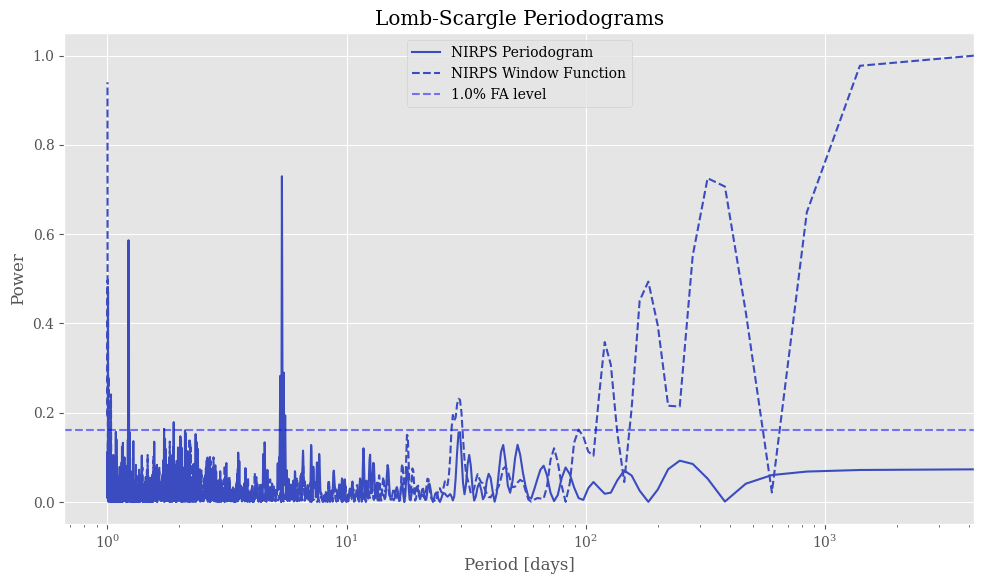

In [48]:
rv.plot_lombscargle_periodograms(data.t_rv, data.y_rv, data.yerr_rv)

# Activity indicators

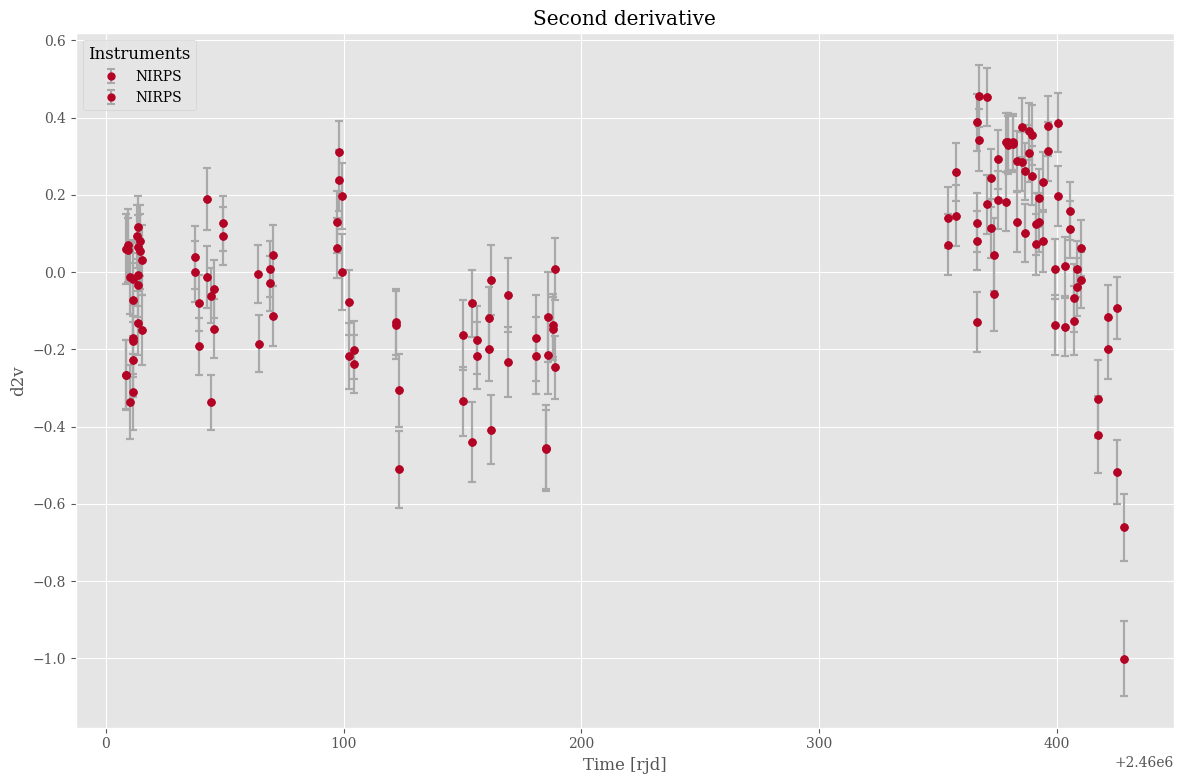

In [49]:
# Plot the chosen activity indicator
nfigs = 2 - no_Dtemp
fig, axes = plt.subplots(nfigs, 1, figsize=(12, 8), sharex=True)

for idx, instrument in enumerate(data.instruments):
    # Subtler error bars
    axes.errorbar(data.t_rv[instrument], data.d2v[instrument], yerr=data.sd2v[instrument], fmt='o', 
                label=instrument, color=colors[idx], 
                ecolor='darkgray', elinewidth=1.5, capsize=3, capthick=1.5)
    if not no_Dtemp:
        axes[0].errorbar(data.t_rv[instrument], data.d2v[instrument], yerr=data.sd2v[instrument], fmt='o', 
                label=instrument, color=colors[idx], 
                ecolor='darkgray', elinewidth=1.5, capsize=3, capthick=1.5)
        axes[1].errorbar(data.t_rv[instrument], data.Dtemp[instrument], yerr=data.sDtemp[instrument], fmt='o',
                        label=instrument, color=colors[idx], 
                    ecolor='darkgray', elinewidth=1.5, capsize=3, capthick=1.5)

        axes[1].set_xlabel('Time [rjd]')
        axes[0].set_ylabel('d2v')
        axes[0].legend(title='Instruments')
        axes[0].set_title('Second derivative')

        axes[1].set_title('Differential temperature')
        axes[1].legend(title='Instruments')
        axes[1].set_ylabel('Dtemp')
    else: 
        axes.errorbar(data.t_rv[instrument], data.d2v[instrument], yerr=data.sd2v[instrument], fmt='o', 
                label=instrument, color=colors[idx], 
                ecolor='darkgray', elinewidth=1.5, capsize=3, capthick=1.5)
        axes.set_xlabel('Time [rjd]')
        axes.set_ylabel('d2v')
        axes.legend(title='Instruments')
        axes.set_title('Second derivative')
plt.show()

Choose the activity indicator

In [50]:
if data.activity_priors['chosen_activity'] == 'd2v': 
    act, sact = data.d2v, data.sd2v

if data.activity_priors['chosen_activity'] == 'Dtemp': 
    act, sact = data.Dtemp, data.sDtemp
    
print(f'You chose to use the {data.activity_priors["chosen_activity"]} activity indicator.')

You chose to use the d2v activity indicator.


## Creating the GP object

GP params order: 

0. `mu` (offset)
1. `log_wn` (jitter noise)
2. `log_amp` (amplitude)
3. `log_lambda` (Coherence length)
4. `gamma` (Number of sub-structures)
5. `log_Prot` (Rotation period)

First Guess

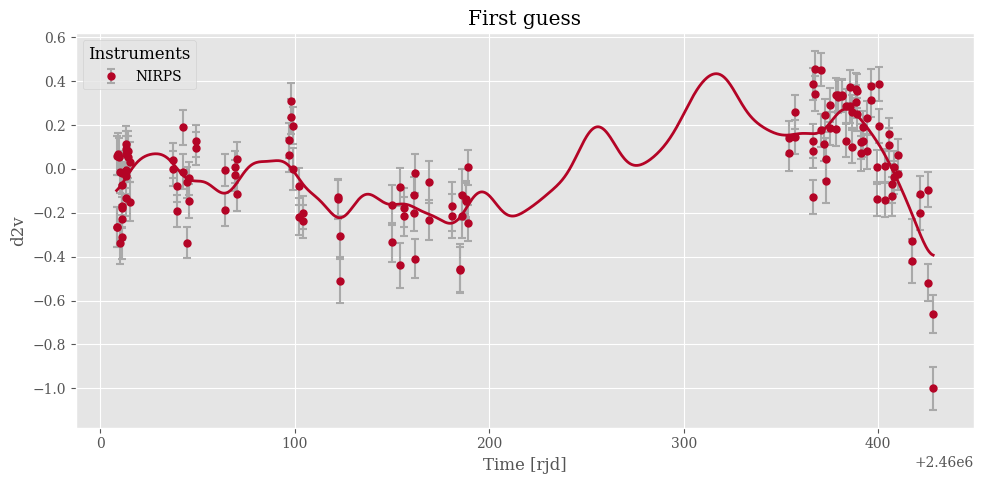

In [51]:
act_gp = {} # Dictionary to store the GP for each instrument
p0 = {} # Dictionary to store the initial guess for the hyperparameters

for instrument in data.instruments: 
    
    p0[instrument] = rv.juliet_to_george([np.mean(act[instrument]), 0.1, np.std(act[instrument]),
           data.activity_priors['GP_length']['guess'], data.activity_priors['GP_gamma']['guess'], data.activity_priors['GP_Prot']['guess']]) # Initial guess for the hyperparameters
    
    act_gp[instrument] = rv.QP_GP_Model(p0[instrument], data.t_rv[instrument], act[instrument], sact[instrument])
# Plot the first guess
# Plot the chosen activity indicator
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
                    
for idx, instrument in enumerate(data.instruments):
    # Subtler error bars
    ax.errorbar(data.t_rv[instrument], act[instrument], yerr=sact[instrument], fmt='o', 
                label=instrument, color=colors[idx], 
                ecolor='darkgray', elinewidth=1.5, capsize=3, capthick=1.5)
    ax.plot(data.t_mod[instrument], act_gp[instrument].predict(data.t_mod[instrument]), color=colors[idx], lw=2)

ax.set_xlabel('Time [rjd]')
ax.set_ylabel(data.activity_priors['chosen_activity'])
ax.legend(title='Instruments')
ax.set_title('First guess')
plt.show()

## Combining the shared parameters and computing initial guess

In [52]:
p0_separated = []

for instrument in data.instruments: 
    p0_separated += list(p0[instrument])

p0_vect = rv.params_vector(p0_separated, data.instruments, i_shared, num_planets = data.nplanets, gp_only=True)

comb_p0 = p0_vect.combine()

## Running `emcee`

In [53]:
# MCMC fit of the GP hyperparameters 
nwalkers, ndim = 32, len(comb_p0)
num_warmup = 600
num_post_samples = 2500
sampler = emcee.EnsembleSampler(
    nwalkers,
    ndim,
    rv.act_log_post,
    args=(act_gp, act, data, i_shared),
    # moves=[emcee.moves.StretchMove()]
    moves=[emcee.moves.DEMove()],
)
# Change the dimension of p0 with the number of walkers
comb_p0_emcee = np.array([comb_p0 + 1e-6 * np.random.randn(ndim) for i in range(nwalkers)])

$\color{red}{\textrm{RUNNING CELL}}$

In [54]:
if run_activity == True:
    print('Running MCMC fit for the activity indicator...')
    sampler.run_mcmc(comb_p0_emcee, num_post_samples + num_warmup, progress=True, store=True)
    act_post_samples = sampler.get_chain(discard=num_warmup)
    np.save(f'stars/{star}/joint_fit/act_post_samples.npy', act_post_samples)
    print('Done')

Load the already ran target

In [55]:
act_post_samples = np.load(f'stars/{star}/joint_fit/act_post_samples.npy', allow_pickle=True)

Traceplot

Plotting traceplot...
Done.


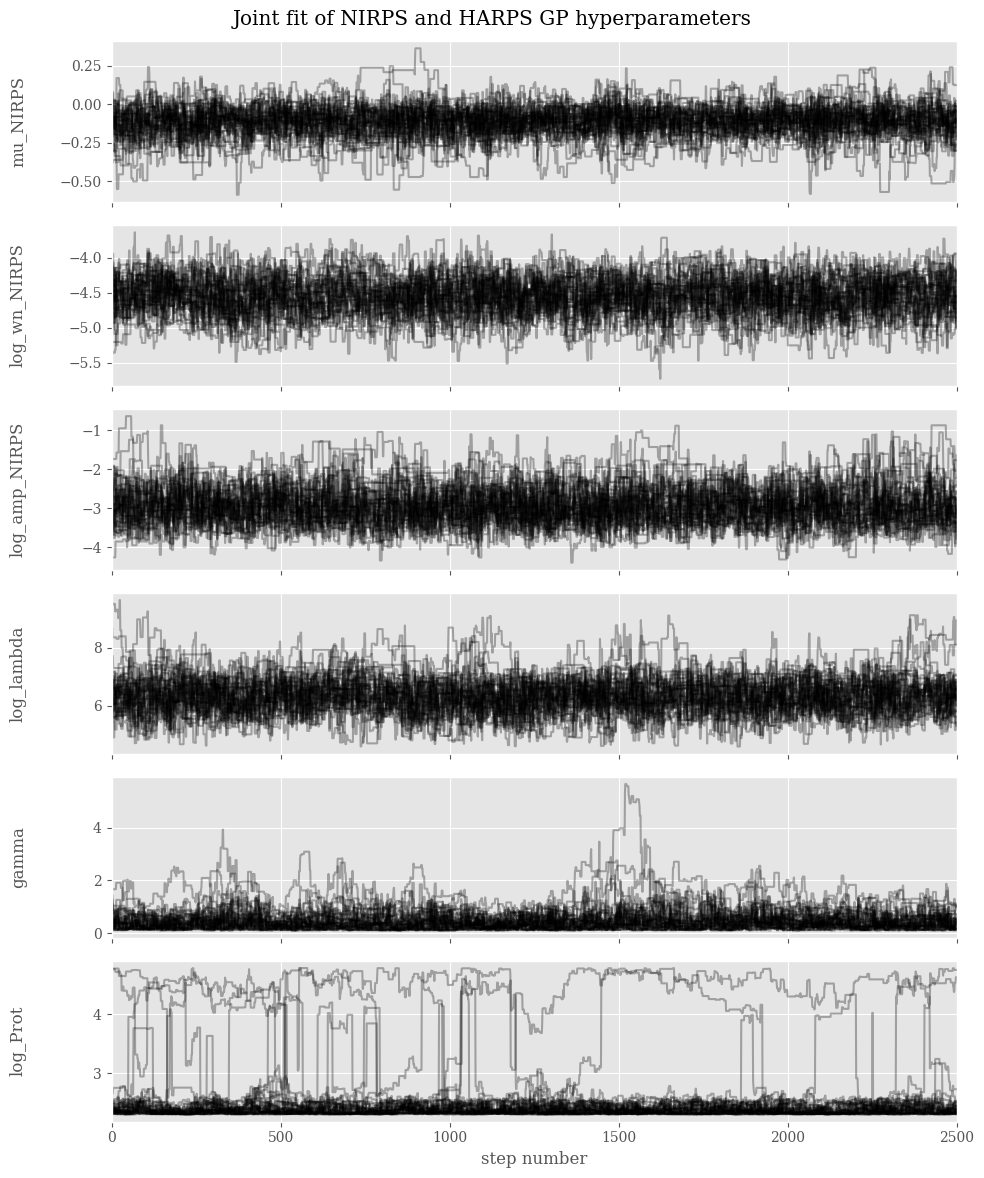

In [56]:
print('Plotting traceplot...')
fig, axes = plt.subplots(ndim, figsize=(10, ndim*2), sharex=True)


for i in range(ndim):
    ax = axes[i]
    ax.plot(act_post_samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(act_post_samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.set_ylabel(gp_labels[i])
axes[-1].set_xlabel("step number")
plt.suptitle('Joint fit of NIRPS and HARPS GP hyperparameters')
plt.savefig(f"stars/{star}/joint_fit/act_GP_traceplot.png")
print('Done.')

Corner plot

Creating corner plot for the activity indicator


Done.


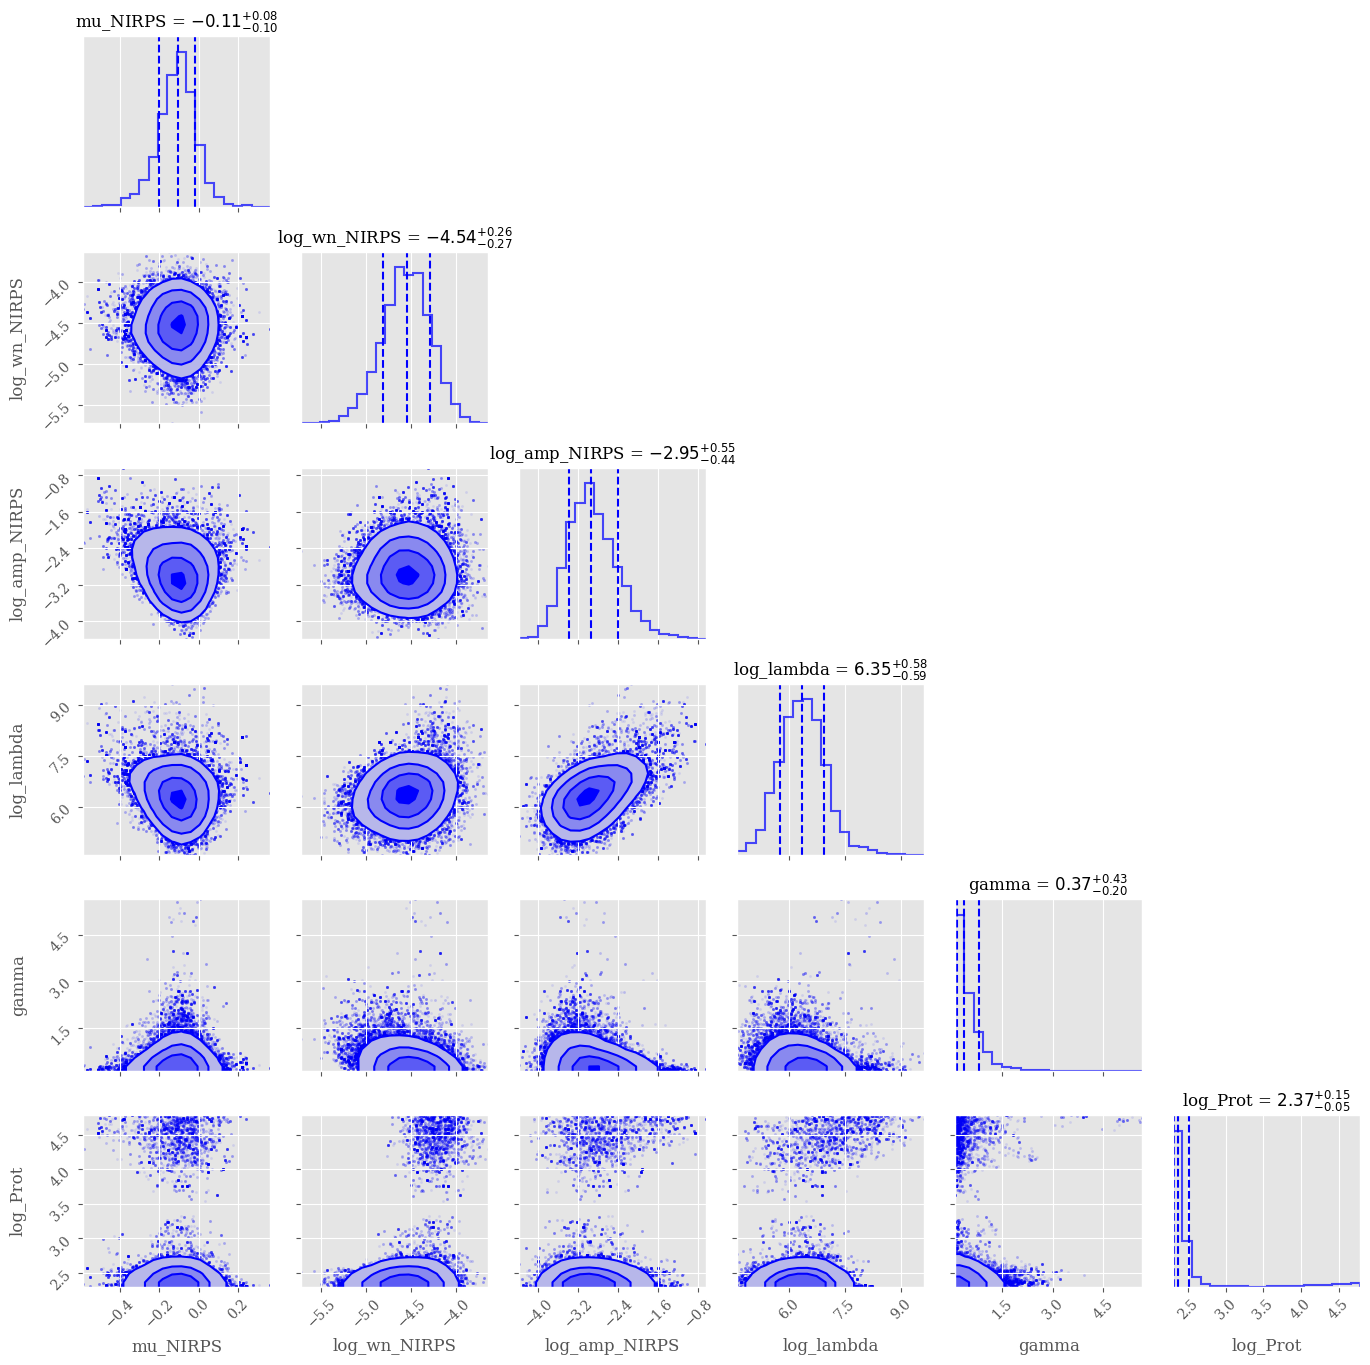

In [57]:
print('Creating corner plot for the activity indicator')
#truths = [None, None, None, None, None, None, None, None, np.log(data.data['star']['period'])]

corner.corner(act_post_samples.reshape(-1, ndim), quantiles=[0.16, 0.5, 0.84],
              show_titles=True,
              title_kwargs={"fontsize": 12},
              color="blue",  # Set a color scheme (optional)
              hist_kwargs={"linewidth": 1.5, "alpha": 0.7},  # Adjust histogram appearance
              fill_contours=True,  # Show contours for data density
              fill_kw={"cmap": "Blues"},  # Set colormap for contours (optional)
              smooth=True,  # Improve smoothness of contours
              fontsize=10,  # Set font size for labels and tick marks
              #truths=truths,
              #truth_color = 'orange',
              labels=gp_labels
)
plt.tight_layout()
plt.savefig(f"stars/{star}/joint_fit/act_GP_cornerplot.png")
print('Done.')

In [58]:
median_likelihood_params = np.median(act_post_samples, axis=(0,1))

print(f"Median likelihood parameters")
print('--------------------------')
# Show the median likelihood parameters
for i, label in enumerate(gp_labels):
    print(f'{label}: {median_likelihood_params[i]:.3f}')


Median likelihood parameters
--------------------------
mu_NIRPS: -0.106
log_wn_NIRPS: -4.545
log_amp_NIRPS: -2.952
log_lambda: 6.355
gamma: 0.372
log_Prot: 2.369


Creating posterior samples

In [59]:
# Visualize posterior samples and max/median likelihood models
print('Creating posterior samples...')

num_display = 20
maxiter = 100
niter = 0

# Initialize dictionaries to store posterior samples for each instrument
model_post_samples = {instrument: [] for instrument in act_gp.keys()}

while niter < maxiter and all(len(samples) < num_display for samples in model_post_samples.values()):
    w = np.random.randint(nwalkers)
    n = np.random.randint(num_post_samples)

    # Separate the parameters for each instrument
    _, act_post_samples_dict = rv.separate_gp_params(act_post_samples[n, w], i_shared, act_gp.keys())

    try:
        for instrument, gp_model in act_gp.items():
            gp_params = act_post_samples_dict[instrument]
            gp_model.gp.set_parameter_vector(gp_params)
            model_post_samples[instrument].append(gp_model.gp.sample_conditional(act[instrument], data.t_mod[instrument]))
    except LinAlgError:
        print("LinAlgError")
        print(f"iteration {niter}")
        print("GP hyperparameters:")
        for instrument, gp_model in act_gp.items():
            pprint.pprint(gp_model.gp.get_parameter_dict())
    
    niter += 1

# Convert lists to numpy arrays
model_post_samples = {instrument: np.array(samples) for instrument, samples in model_post_samples.items()}

print('Done.')

Creating posterior samples...


Done.


Plotting the best-fit results
Done.


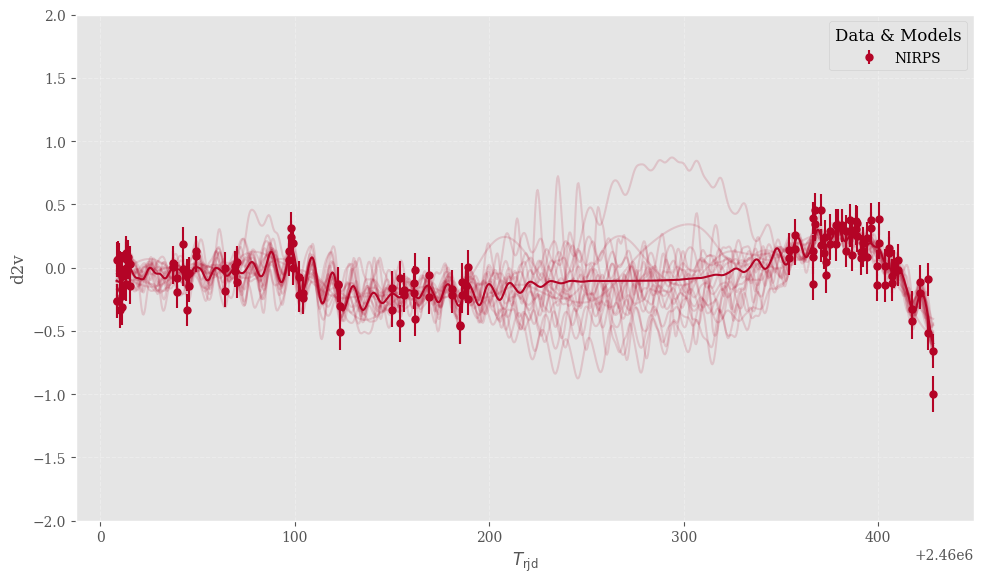

In [60]:
print('Plotting the best-fit results')

# Separate the parameters for each instrument
_, act_med_params = rv.separate_gp_params(median_likelihood_params, i_shared, act_gp.keys())

# Initialize dictionaries to store predictions and standard deviations
mu_med = {}
std_med = {}

# Predict for each instrument
for instrument, gp_model in act_gp.items():
    # Median likelihood parameters
    gp_model.gp.set_parameter_vector(act_med_params[instrument])
    mu_med[instrument], var_med = gp_model.gp.predict(act[instrument], data.t_mod[instrument], return_var=True)

# Plotting
fig, axes = plt.subplots(1, 1, figsize=(10, 6), sharex=True)
colors = cm.coolwarm(np.linspace(1, 0, len(act_gp)))  # Use coolwarm colormap for consistency

for idx, (instrument, color) in enumerate(zip(act_gp.keys(), colors)):
    # Plot data with error bars
    axes.errorbar(data.t_rv[instrument], act[instrument], yerr=np.sqrt(sact[instrument]**2 + np.exp(act_med_params[instrument][1])), 
                  fmt="o", ms=5, label=instrument, color=color)
    
    # Plot samples from posterior
    axes.plot(data.t_mod[instrument], model_post_samples[instrument].T, color=color, alpha=0.15)
    
    # Plot median likelihood
    axes.plot(data.t_mod[instrument], mu_med[instrument], color=color, linewidth=1.5)

# Axes and labels
axes.set_ylabel(f"{data.activity_priors['chosen_activity']}")
axes.set_xlabel(r"$T_{\rm rjd}$")  # Use Latex for unit

# Conditionally setting y-limits based on activity indicator
if data.activity_priors['chosen_activity'] == 'Dtemp': 
    plt.ylim(bottom=-50, top=50)
if data.activity_priors['chosen_activity'] == 'd2v': 
    plt.ylim(bottom=-2, top=2)

axes.grid(linestyle='--', alpha=0.3)
plt.legend(title="Data & Models", loc='upper right')  # Adjust legend position
plt.tight_layout()  # Adjust spacing

# Saving figure
star_name = data.data['star']['name']
file_path = f"stars/{star_name}/joint_fit/{data.activity_priors['chosen_activity']}_GP_MC_fit.png"
plt.savefig(file_path, dpi=300)  # Ensure high resolution

print('Done.')


# Planets + GP analysis

## Exemple of the parameter vector to enter in the Planet_GP_Model object: 

p = [planets parameters, GP parameters]

**p = [per1, tc1, k1, ... (other planets), mu_NIRPS, noise_NIRPS, amp_NIRPS, coherence_length_NIRPS, gamma_NIRPS, Prot_NIRPS, ... (other instruments) ]**

### Loading the initial guess parameter vector

In [61]:
import importlib
importlib.reload(rv)

<module 'rv_analysis_tools' from '/home/plamontagne/nirps/rv_analysis_tools.py'>

In [62]:
# Extract the number of planets from the RV priors
num_planets = data.nplanets

print(f'Creating initial guess for the RV parameters for {num_planets} planets and activity...')

# Initialize lists to hold planet parameters and labels
p0 = []
planet_labels = []
priors = {}  # Dictionary to store the priors
prior_params_names = ['mu', 'noise', 'GP_sigma', 'GP_length', 'GP_gamma', 'GP_Prot']
act_samples_dict = rv.separate_gp_params_samples(act_post_samples, i_shared, data.instruments) # Contains the samples for the parameters of each instrument

# Loop over the number of planets to construct the parameter and label lists
for i in range(1, num_planets + 1):

    p0.extend([
        data.RV_priors[f'per{i}']['guess'],
        data.RV_priors[f'tc{i}']['guess'],
        data.RV_priors[f'k{i}']['guess']
    ])
    planet_labels.extend([f'per{i}', f'tc{i}', f'k{i}'])

# Loop over the instruments to construct the GP parameter list
for inst in data.instruments: 
    priors[inst] = copy.deepcopy(data.RV_priors)
    
for instrument in data.instruments: 
    if data.use_indicator:
        # Create the initial vector from the activity indicator
        p0.extend(
            [np.mean(data.y_rv[instrument]), np.log(0.1**2), np.log(np.std(data.y_rv[instrument])**2),
            act_med_params[instrument][3], act_med_params[instrument][4], act_med_params[instrument][5]])
    
        # Add priors for GP parameters
        for idx, param_name in enumerate(prior_params_names):
            if param_name == 'GP_length':
                priors[instrument][param_name] = {
                    'distribution': 'Normal',
                    'mean': np.median(np.sqrt(np.exp(act_samples_dict[instrument][idx]))),
                    'std': np.std(np.sqrt(np.exp(act_samples_dict[instrument][idx])))
                }
            elif param_name == 'GP_gamma':
                priors[instrument][param_name] = {
                    'distribution': 'Normal',
                    'mean': np.median(act_samples_dict[instrument][idx]),
                    'std': np.std(act_samples_dict[instrument][idx])
                }
            elif param_name == 'GP_Prot':
                priors[instrument][param_name] = {
                    'distribution': 'Normal',
                    'mean': np.median(np.exp(act_samples_dict[instrument][idx])),
                    'std': np.std(np.exp(act_samples_dict[instrument][idx])), 
                    'min': np.median(np.exp(act_samples_dict[instrument][idx])) - 10,
                    'max': np.median(np.exp(act_samples_dict[instrument][idx])) + 10
                }
            else: 
                continue

    else:
        p0.extend(rv.juliet_to_george([
            np.mean(data.y_rv[instrument]), 0.1, np.std(data.y_rv[instrument]),
            data.RV_priors['GP_length']['guess'], data.RV_priors['GP_gamma']['guess'], data.RV_priors['GP_Prot']['guess']
        ]))
        
        priors[instrument] = data.RV_priors
# Create parameter vector
p0_vect = rv.params_vector(p0, data.instruments, i_shared, num_planets=num_planets)
comb_p0 = p0_vect.combine()
param_labels = np.concatenate([planet_labels, gp_labels]) 

print('Initial guess parameter vector:')
print('--------------------------')
for i, label in enumerate(param_labels):
    print(f'{label}: {comb_p0[i]:.3f}')

print('Priors:')
print('--------------------------')
print(priors) 

Creating initial guess for the RV parameters for 3 planets and activity...
Initial guess parameter vector:
--------------------------
per1: 5.360
tc1: 2454724.631
k1: 12.000
per2: 12.914
tc2: 2455183.690
k2: 1.300
per3: 3.149
tc3: 2455163.690
k3: 1.300
mu_NIRPS: 0.000
log_wn_NIRPS: -4.605
log_amp_NIRPS: 4.490
log_lambda: 4.605
gamma: 5.000
log_Prot: 4.868
Priors:
--------------------------
{'NIRPS': {'mu': {'guess': 0.0, 'distribution': 'Normal', 'mean': 0.0, 'std': 5.0, 'min': -10.0, 'max': 10.0}, 'noise': {'guess': 1.0, 'distribution': 'Uniform', 'mean': 1.0, 'std': 1.0, 'min': 0.001, 'max': 100.0}, 'GP_Prot': {'guess': 130.0, 'distribution': 'Uniform', 'mean': 130.0, 'std': 10.0, 'min': 10.0, 'max': 200.0}, 'GP_sigma': {'guess': 25.0, 'distribution': 'Uniform', 'mean': 1.0, 'std': 0.001, 'min': 1.0, 'max': 100.0}, 'GP_length': {'guess': 10.0, 'distribution': 'Uniform', 'mean': 20.0, 'std': 10.0, 'min': 1.0, 'max': 300.0}, 'GP_gamma': {'guess': 5.0, 'distribution': 'loguniform', 'mea

## Creating planet + GP model

In [63]:
# Create the Planet+GP model
model = rv.Planet_GP_Model(p0_vect, data.t_rv, data.y_rv, data.yerr_rv, num_planets = num_planets)

Look at first guess

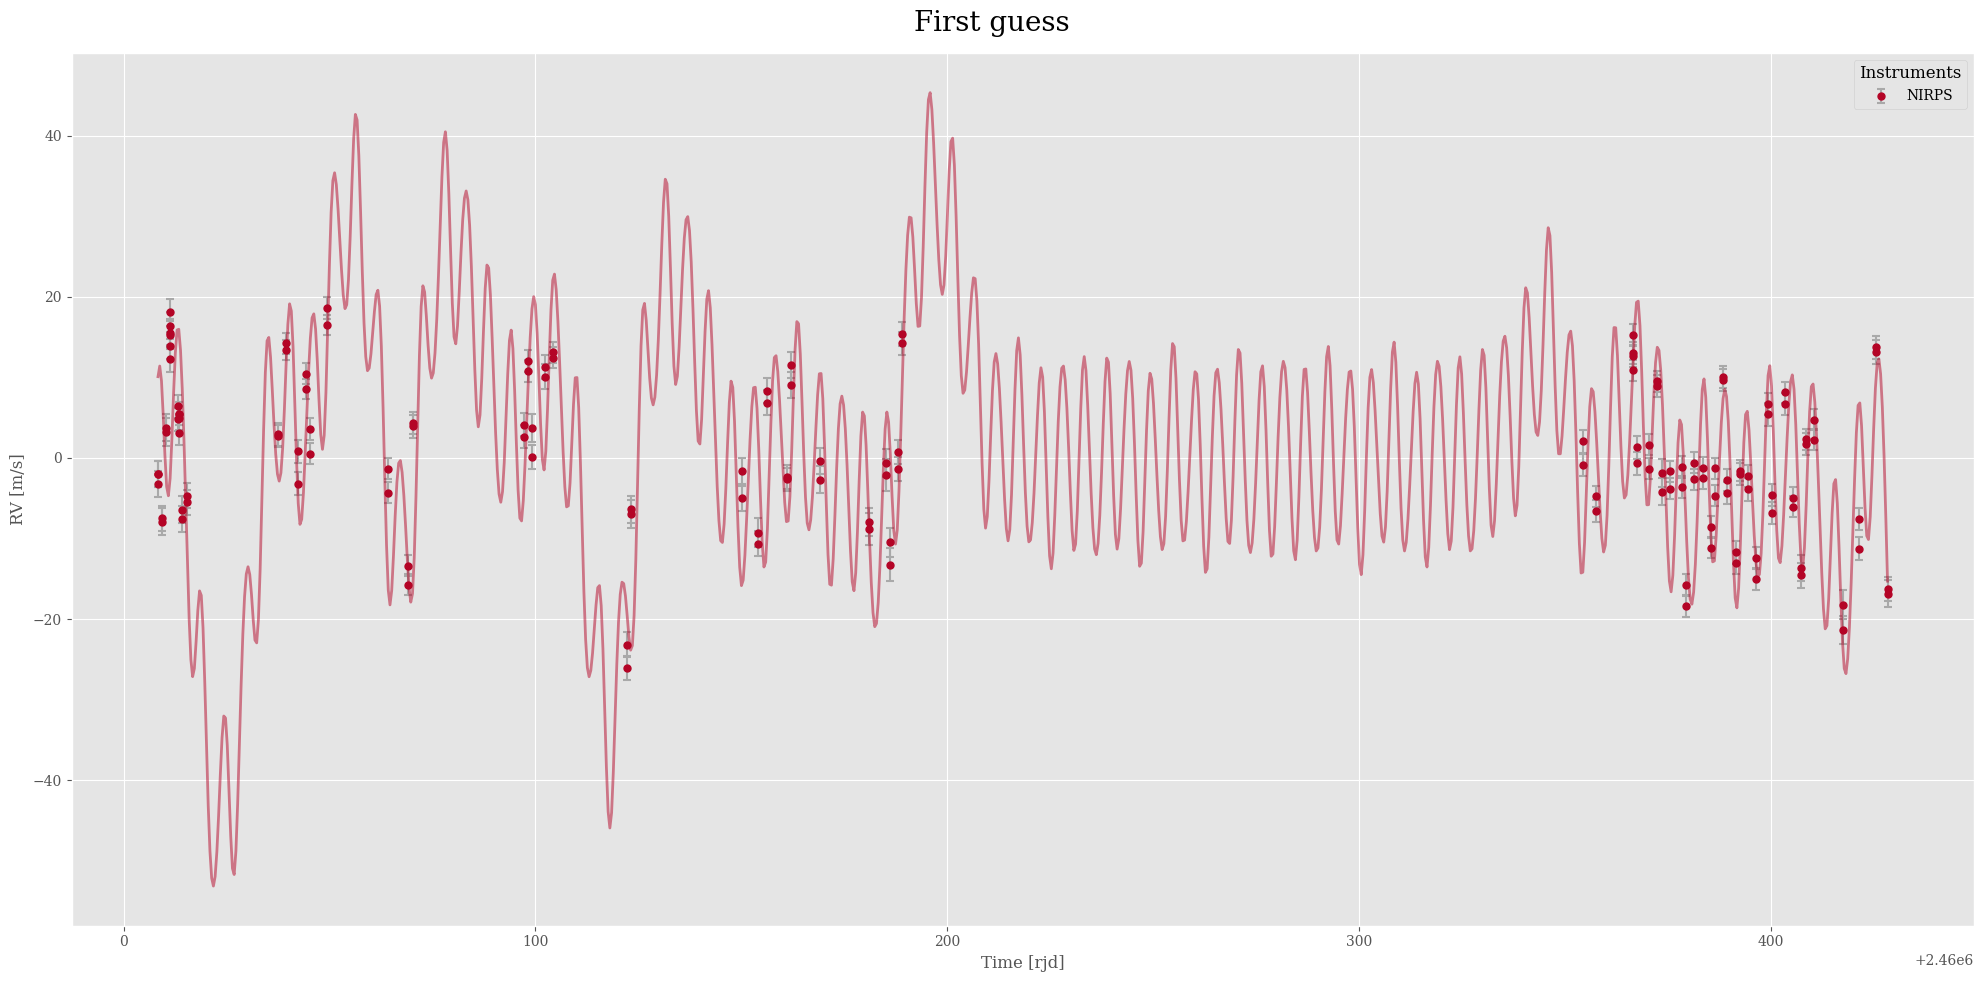

In [64]:
# Plot the RV data and the first guess
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
colors = cm.coolwarm(np.linspace(1, 0, len(data.instruments)))

model.update_params(p0_vect)
for idx, instrument in enumerate(data.instruments):
    # Subtler error bars
    ax.errorbar(data.t_rv[instrument], data.y_rv[instrument], yerr=data.yerr_rv[instrument], fmt='o', 
                label=instrument, color=colors[idx], 
                ecolor='darkgray', elinewidth=1.5, capsize=3, capthick=1.5)
    ax.plot(data.t_mod[instrument], model.predict(data.t_mod)[instrument], color=colors[idx], lw=2, alpha=0.5)
    
    ax.set_xlabel('Time [rjd]')
    ax.set_ylabel('RV [m/s]')
    
    ax.legend(title='Instruments')
plt.suptitle('First guess', fontsize=20)
plt.show()
    

## Run `emcee`

### Creating a combined parameter vector to use in the MCMC run
This is necessary because we want the shared GP parameters to be updated for all instruments at once.

In [65]:
comb_p0 = p0_vect.combine()

# MCMC fit of the GP hyperparameters 
nwalkers, ndim = 3*len(comb_p0), len(comb_p0)
num_warmup = 100 * ndim
num_post_samples = 1000 * ndim
sampler = emcee.EnsembleSampler(
    nwalkers,
    ndim,
    rv.emcee_log_post,
    args=(model, data, priors, i_shared, num_planets),
    moves=[emcee.moves.DEMove()]
)
# Change the dimension of p0 with the number of walkers
comb_p0_emcee = np.array([comb_p0 + np.random.randn(ndim) * 1e-4 for i in range(nwalkers)])


In [66]:
if run_planet_search == True:
    print('Running MCMC for the combined model...')
    sampler.run_mcmc(comb_p0_emcee, num_post_samples + num_warmup, progress=True)
    post_samples = sampler.get_chain(discard=num_warmup)
    np.save(f'stars/{star}/joint_fit/full_post_samples.npy', post_samples)
    print('Done.')

Running MCMC for the combined model...
-2.52837644564634
-5.664993983888341
-7.885320790256188
-10.319597517621741
-13.456235735501934
-14.553424435866884
-2.528376445856551
-5.664993984098553
-7.885320790466399
-10.319597517831951
-13.456228704879729
-14.553417405244678
-2.528376446182625
-5.664993984424626
-7.8853207907924725
-10.319597518158027
-13.456221801464851
-14.5534105018298
-2.528376445664289
-5.664993983906291
-7.885320790274137
-10.31959751763969
-13.456233795818477
-14.553422496183426
-2.5283764456540125
-5.664993983896014
-7.885320790263861
-10.319597517629415
-13.456250240361406
-14.553438940726355
-2.5283764456968285
-5.66499398393883
-7.885320790306676
-10.319597517672229
-13.456189794573286
-14.553378494938235
-2.5283764457185676
-5.664993983960569
-7.885320790328415
-10.319597517693968
-13.456207769594045
-14.553396469958994
-2.528376445702065
-5.664993983944067
-7.885320790311913
-10.319597517677465
-13.456230481966216
-14.553419182331165
-2.528376445680038
-5.6649

  0%|          | 0/16500 [00:00<?, ?it/s]

-2.528376445664833
-5.664993983906834
-7.8853207902746805
-10.319597517640233
-13.456217268620481
-14.55340596898543
-2.5283764457202005
-5.664993983962201
-7.885320790330048
-10.319597517695602
-13.456247658317277
-14.553436358682227
-2.528376445641539
-5.664993983883541
-7.885320790251387
-10.319597517616941
-13.456202792695587
-14.553391493060536
-2.5283764458292106
-5.664993984071212
-7.885320790439058
-10.319597517804612
-13.456243328721147
-14.553432029086096
-2.5283764456659927
-5.664993983907994
-7.88532079027584
-10.319597517641395
-13.456201503582562
-14.553390203947512
-2.5283764458215683
-5.664993984063569
-7.8853207904314155
-10.319597517796968
-13.456213866710264
-14.553402567075214
-2.5283764465173935
-5.664993984759395
-7.885320791127241
-10.319597518492795
-13.456225837197776
-14.553414537562725
-2.5283764456695628
-5.664993983911565
-7.885320790279411
-10.319597517644965
-13.456192307954142
-14.553381008319091
-2.5283764456811473
-5.664993983923148
-7.8853207902909945

  0%|          | 1/16500 [00:00<1:02:50,  4.38it/s]

-2.528376445780328
-5.664993984022329
-7.885320790390176
-10.319597517755728
-13.456223811493949
-14.553412511858898
-2.5283764463586142
-5.664993984600615
-7.8853207909684615
-10.319597518334014
-13.456193436470764
-14.553382136835713
-2.528376446896934
-5.664993985138935
-7.885320791506781
-10.319597518872335
-13.456183156502412
-14.553371856867361
-2.528376445676186
-5.664993983918187
-7.885320790286033
-10.319597517651587
-13.456215699718893
-14.553404400083842
-2.528376445659233
-5.664993983901234
-7.8853207902690805
-10.319597517634634
-13.456227343806393
-14.553416044171342
-2.5283764457127815
-5.664993983954783
-7.88532079032263
-10.319597517688184
-13.456181590819222
-14.553370291184171
-2.5283764464402756
-5.664993984682277
-7.885320791050123
-10.319597518415677
-13.456238094439883
-14.553426794804832
-2.528376445712281
-5.664993983954282
-7.885320790322129
-10.319597517687683
-13.45619127728736
-14.553379977652309
-2.5283764457464097
-5.664993983988412
-7.885320790356258
-10

-2.5283764457522513
-5.664993983994252
-7.8853207903620985
-10.31959751772765
-13.456183356846934
-14.553372057211883
-2.528376445995921
-5.664993984237922
-7.8853207906057685
-10.31959751797132
-13.456211381656376
-14.553400082021325
-2.528376445670371
-5.664993983912373
-7.885320790280219
-10.319597517645771
-13.456227674629709
-14.553416374994658
-2.5283764459482923
-5.664993984190294
-7.88532079055814
-10.319597517923693
-13.456234560821043
-14.553423261185992
-2.5283764458177114
-5.664993984059713
-7.885320790427559
-10.319597517793113
-13.456239583791962
-14.553428284156912
-2.528376445655557
-5.664993983897558
-7.885320790265404
-10.319597517630957
-13.456242911470532
-14.553431611835482
-2.528376445670912
-5.664993983912913
-7.885320790280759
-10.319597517646312
-13.45622238981641
-14.55341109018136
-2.5283764459252973
-5.664993984167299
-7.885320790535145
-10.319597517900698
-13.456254038954466
-14.553442739319415
-2.5283764459363973
-5.664993984178398
-7.885320790546245
-10.3

  0%|          | 2/16500 [00:00<1:03:06,  4.36it/s]

-2.528376445647829
-5.664993983889831
-7.885320790257677
-10.31959751762323
-13.456222315446492
-14.553411015811442
-2.5283764456875293
-5.664993983929531
-7.885320790297377
-10.319597517662931
-13.456235992159531
-14.55342469252448
-2.528376445746254
-5.664993983988255
-7.885320790356102
-10.319597517721654
-13.456198702678268
-14.553387403043217
-2.528376445997352
-5.664993984239354
-7.8853207906072
-10.319597517972753
-13.456202187530767
-14.553390887895716
-2.528376445639165
-5.664993983881166
-7.885320790249012
-10.319597517614564
-13.456161349834916
-14.553350050199866
-2.5283764456391564
-5.664993983881158
-7.885320790249004
-10.319597517614557
-13.456198345370751
-14.5533870457357
-2.528376446493805
-5.664993984735807
-7.885320791103653
-10.319597518469205
-13.456188880464474
-14.553377580829423
-2.528376446130535
-5.664993984372536
-7.885320790740383
-10.319597518105937
-13.456172352907984
-14.553361053272933
-2.5283764457237417
-5.6649939839657435
-7.88532079033359
-10.319597

  0%|          | 3/16500 [00:00<1:00:46,  4.52it/s]

-2.52837644579547
-5.664993984037471
-7.885320790405317
-10.31959751777087
-13.456197844332701
-14.55338654469765
-2.528376445675462
-5.664993983917464
-7.88532079028531
-10.319597517650863
-13.456187318475365
-14.553376018840314
-2.5283764458212827
-5.664993984063284
-7.88532079043113
-10.319597517796684
-13.456205988883813
-14.553394689248762
-2.528376445667648
-5.66499398390965
-7.885320790277496
-10.31959751764305
-13.456233891861476
-14.553422592226426
-2.528376446469201
-5.664993984711202
-7.885320791079049
-10.319597518444603
-13.456249090317463
-14.553437790682413
-2.528376445959711
-5.664993984201713
-7.885320790569559
-10.319597517935112
-13.456222991655196
-14.553411692020145
-2.5283764456983584
-5.664993983940359
-7.885320790308206
-10.31959751767376
-13.45622995514523
-14.553418655510178
-2.528376445800394
-5.664993984042395
-7.885320790410241
-10.319597517775794
-13.456219535930469
-14.553408236295418
-2.5283764472312735
-5.664993985473275
-7.885320791841122
-10.319597519

  0%|          | 4/16500 [00:00<59:26,  4.63it/s]  

-2.5283764466282075
-5.664993984870209
-7.885320791238056
-10.319597518603608
-13.456263985875506
-14.553452686240455
-2.5283764457299585
-5.66499398397196
-7.885320790339806
-10.31959751770536
-13.456187402571762
-14.553376102936712
-2.5283764461642693
-5.664993984406271
-7.885320790774117
-10.31959751813967
-13.456220626231543
-14.553409326596492
-2.5283764457217237
-5.6649939839637256
-7.885320790331572
-10.319597517697126
-13.45625627406978
-14.55344497443473
-2.5283764460219174
-5.664993984263919
-7.8853207906317655
-10.31959751799732
-13.456264794207746
-14.553453494572695
-2.528376445639635
-5.6649939838816366
-7.885320790249483
-10.319597517615037
-13.456234099466148
-14.553422799831097
-2.5283764456714546
-5.664993983913456
-7.885320790281303
-10.319597517646855
-13.456209766250668
-14.553398466615617
-2.5283764456728735
-5.664993983914875
-7.885320790282721
-10.319597517648274
-13.456227029077876
-14.553415729442825
-2.528376446577812
-5.664993984819813
-7.8853207911876595
-1

  0%|          | 5/16500 [00:01<1:00:51,  4.52it/s]

-2.5283764466297387
-5.6649939848717406
-7.885320791239587
-10.31959751860514
-13.456203317744983
-14.553392018109932
-2.528376445741575
-5.664993983983576
-7.885320790351423
-10.319597517716975
-13.456210234463608
-14.553398934828557
-2.5283764462093763
-5.664993984451378
-7.885320790819224
-10.319597518184779
-13.456219000219981
-14.55340770058493
-2.528376446688824
-5.664993984930826
-7.885320791298672
-10.319597518664224
-13.456195018872194
-14.553383719237143
-2.528376445939393
-5.664993984181395
-7.885320790549241
-10.319597517914794
-13.456177068057965
-14.553365768422914
-2.5283764458925737
-5.6649939841345756
-7.885320790502422
-10.319597517867976
-13.456252903392912
-14.553441603757861
-2.5283764460205624
-5.664993984262564
-7.88532079063041
-10.319597517995962
-13.456266348265832
-14.55345504863078
-2.528376446315649
-5.6649939845576505
-7.885320790925497
-10.31959751829105
-13.456168909312145
-14.553357609677095
-2.5283764459753146
-5.6649939842173165
-7.885320790585163
-10

  0%|          | 6/16500 [00:01<1:00:45,  4.52it/s]

-2.528376445936208
-5.66499398417821
-7.885320790546056
-10.31959751791161
-13.456201607048166
-14.553390307413116
-2.528376445686167
-5.664993983928168
-7.8853207902960145
-10.319597517661567
-13.456187295261259
-14.553375995626208
-2.528376445819513
-5.664993984061514
-7.88532079042936
-10.319597517794914
-13.456216011733137
-14.553404712098086
-2.5283764457348163
-5.664993983976817
-7.885320790344664
-10.319597517710218
-13.456192529597882
-14.553381229962831
-2.5283764456848443
-5.664993983926846
-7.885320790294692
-10.319597517660245
-13.456202882461788
-14.553391582826738
-2.528376445841848
-5.66499398408385
-7.885320790451696
-10.31959751781725
-13.456252404752897
-14.553441105117846
-2.528376446109746
-5.664993984351748
-7.885320790719594
-10.319597518085146
-13.45617653619766
-14.553365236562609
-2.528376446060539
-5.664993984302541
-7.885320790670387
-10.319597518035941
-13.456243049311222
-14.553431749676172
-2.5283764466919787
-5.6649939849339805
-7.885320791301827
-10.3195

  0%|          | 7/16500 [00:01<1:00:24,  4.55it/s]

-2.528376445642938
-5.664993983884939
-7.885320790252785
-10.319597517618337
-13.456195477310699
-14.553384177675648
-2.528376446408109
-5.66499398465011
-7.885320791017956
-10.31959751838351
-13.456213195885294
-14.553401896250243
-2.52837644588522
-5.664993984127221
-7.885320790495068
-10.319597517860622
-13.456200069876475
-14.553388770241424
-2.528376446044262
-5.664993984286264
-7.88532079065411
-10.319597518019663
-13.456205497989618
-14.553394198354567
-2.5283764456817677
-5.664993983923769
-7.885320790291615
-10.319597517657169
-13.456270976907696
-14.553459677272645
-2.528376449975526
-5.664993988217527
-7.885320794585374
-10.319597521950927
-13.456222952843644
-14.553411653208594
-2.5283764469372616
-5.6649939851792634
-7.88532079154711
-10.319597518912662
-13.456182153863232
-14.55337085422818
-2.5283764457508604
-5.664993983992861
-7.885320790360708
-10.319597517726262
-13.456187007121665
-14.553375707486614
-2.528376445721684
-5.664993983963686
-7.885320790331532
-10.31959

  0%|          | 8/16500 [00:01<1:02:54,  4.37it/s]

-2.5283764456694655
-5.664993983911467
-7.885320790279313
-10.319597517644866
-13.456291595094358
-14.553480295459307
-2.528376446431748
-5.66499398467375
-7.885320791041596
-10.31959751840715
-13.456282816478096
-14.553471516843045
-2.528376445954588
-5.66499398419659
-7.885320790564436
-10.319597517929989
-13.456222432750554
-14.553411133115503
-2.528376445700657
-5.664993983942658
-7.885320790310504
-10.319597517676058
-13.45625173240298
-14.553440432767928
-2.528376446429571
-5.664993984671572
-7.885320791039418
-10.319597518404972
-13.456222968810579
-14.553411669175528
-2.5283764458000606
-5.664993984042062
-7.885320790409908
-10.319597517775462
-13.456273237302595
-14.553461937667544
-2.528376445824879
-5.66499398406688
-7.885320790434727
-10.319597517800279
-13.456196639098149
-14.553385339463098
-2.5283764460448492
-5.66499398428685
-7.8853207906546965
-10.319597518020249
-13.456190668568096
-14.553379368933046
-2.528376446004286
-5.664993984246287
-7.885320790614133
-10.31959

  0%|          | 9/16500 [00:02<1:02:02,  4.43it/s]

-2.5283764456428606
-5.664993983884862
-7.885320790252709
-10.319597517618263
-13.45623858151541
-14.55342728188036
-2.5283764460094282
-5.66499398425143
-7.885320790619276
-10.319597517984828
-13.456245736071873
-14.553434436436822
-2.5283764460488474
-5.664993984290849
-7.885320790658695
-10.31959751802425
-13.4562354342678
-14.553424134632749
-2.528376445641835
-5.664993983883837
-7.885320790251683
-10.319597517617236
-13.456174818564769
-14.553363518929718
-2.5283764467735383
-5.66499398501554
-7.8853207913833865
-10.319597518748939
-13.456312855364189
-14.553501555729138
-2.528376446766195
-5.664993985008197
-7.885320791376043
-10.319597518741595
-13.456237738865795
-14.553426439230744
-2.5283764480192636
-5.6649939862612655
-7.885320792629112
-10.319597519994666
-13.45629247826331
-14.553481178628259
-2.5283764457809723
-5.664993984022974
-7.8853207903908205
-10.319597517756375
-13.456189481571087
-14.553378181936036
-2.528376445731924
-5.664993983973925
-7.885320790341772
-10.31

  0%|          | 10/16500 [00:02<1:00:23,  4.55it/s]

-2.528376445838068
-5.66499398408007
-7.885320790447916
-10.31959751781347
-13.456253414116155
-14.553442114481104
-2.5283764459469134
-5.664993984188914
-7.885320790556761
-10.319597517922315
-13.456254539223869
-14.553443239588818
-2.5283764457173987
-5.6649939839594
-7.885320790327246
-10.319597517692799
-13.456254277999975
-14.553442978364924
-2.5283764468756087
-5.66499398511761
-7.885320791485456
-10.319597518851008
-13.45616100684554
-14.55334970721049
-2.5283764463935303
-5.664993984635531
-7.885320791003378
-10.31959751836893
-13.456230861383952
-14.553419561748902
-2.5283764474453125
-5.664993985687314
-7.88532079205516
-10.319597519420714
-13.456276652592797
-14.553465352957746
-2.528376448585147
-5.664993986827149
-7.885320793194995
-10.31959752056055
-13.456204180278501
-14.55339288064345
-2.5283764457321256
-5.664993983974127
-7.885320790341973
-10.319597517707527
-13.45618619638486
-14.553374896749808
-2.528376447717638
-5.664993985959639
-7.8853207923274855
-10.31959751

  0%|          | 11/16500 [00:02<1:02:04,  4.43it/s]

-2.528376445643043
-5.6649939838850445
-7.885320790252891
-10.319597517618444
-13.456225519081293
-14.553414219446243
-2.5283764463227745
-5.664993984564775
-7.885320790932622
-10.319597518298174
-13.456218172956884
-14.553406873321833
-2.5283764461082487
-5.66499398435025
-7.885320790718096
-10.31959751808365
-13.456224885343051
-14.553413585708
-2.528376445815989
-5.664993984057991
-7.885320790425837
-10.31959751779139
-13.456116076323973
-14.553304776688922
-2.5283764462347484
-5.66499398447675
-7.885320790844596
-10.319597518210148
-13.456175325659313
-14.553364026024262
-2.5283764467807988
-5.6649939850228
-7.8853207913906465
-10.3195975187562
-13.45623901896716
-14.55342771933211
-2.52837644568054
-5.664993983922542
-7.885320790290388
-10.319597517655941
-13.456194189155124
-14.553382889520073
-2.52837644571799
-5.664993983959992
-7.885320790327838
-10.319597517693392
-13.456264241795203
-14.553452942160153
-2.5283764461790144
-5.664993984421016
-7.885320790788862
-10.31959751815

  0%|          | 12/16500 [00:02<1:02:29,  4.40it/s]

-2.528376448104989
-5.664993986346991
-7.885320792714837
-10.31959752008039
-13.456258428182311
-14.55344712854726
-2.5283764459693416
-5.664993984211343
-7.885320790579189
-10.319597517944743
-13.456257349871665
-14.553446050236614
-2.5283764459383695
-5.664993984180371
-7.885320790548217
-10.31959751791377
-13.456204228729703
-14.553392929094652
-2.5283764457637323
-5.664993984005734
-7.88532079037358
-10.319597517739133
-13.456232032671881
-14.55342073303683
-2.528376447170095
-5.664993985412096
-7.885320791779942
-10.319597519145496
-13.456372425044126
-14.553561125409075
-2.528376445661145
-5.6649939839031465
-7.885320790270993
-10.319597517636545
-13.456290701462278
-14.553479401827227
-2.5283764478780064
-5.664993986120008
-7.885320792487854
-10.319597519853406
-13.456252133279893
-14.553440833644842
-2.5283764456502618
-5.664993983892263
-7.885320790260109
-10.319597517625663
-13.456203005343053
-14.553391705708002
-2.5283764479525423
-5.664993986194544
-7.88532079256239
-10.31

  0%|          | 13/16500 [00:02<1:02:00,  4.43it/s]

-2.5283764484356404
-5.664993986677642
-7.885320793045488
-10.31959752041104
-13.456178727617555
-14.553367427982504
-2.5283764459267397
-5.664993984168741
-7.885320790536587
-10.31959751790214
-13.456110305771073
-14.553299006136022
-2.528376448351128
-5.66499398659313
-7.885320792960976
-10.319597520326528
-13.456125386737067
-14.553314087102017
-2.528376446046714
-5.664993984288715
-7.885320790656562
-10.319597518022114
-13.456266202489717
-14.553454902854666
-2.528376446437462
-5.664993984679463
-7.8853207910473095
-10.319597518412863
-13.456214184648442
-14.55340288501339
-2.5283764458422073
-5.664993984084209
-7.885320790452055
-10.31959751781761
-13.456199908460594
-14.553388608825543
-2.5283764457167917
-5.664993983958793
-7.885320790326639
-10.319597517692191
-13.456314210162404
-14.553502910527353
-2.5283764456624507
-5.664993983904452
-7.885320790272298
-10.319597517637852
-13.456196784863257
-14.553385485228207
-2.528376445642749
-5.6649939838847505
-7.885320790252597
-10.3

  0%|          | 14/16500 [00:03<1:02:43,  4.38it/s]

-2.528376445786715
-5.664993984028716
-7.8853207903965625
-10.319597517762116
-13.456342785059212
-14.55353148542416
-2.5283764456414173
-5.664993983883418
-7.8853207902512645
-10.319597517616817
-13.456216634510502
-14.553405334875452
-2.528376452101681
-5.664993990343683
-7.885320796711529
-10.319597524077082
-13.456154684065444
-14.553343384430393
-2.528376445648902
-5.664993983890904
-7.88532079025875
-10.319597517624302
-13.456286912225915
-14.553475612590864
-2.5283764467205985
-5.664993984962599
-7.885320791330446
-10.319597518696
-13.456173987552383
-14.553362687917332
-2.5283764460865834
-5.664993984328585
-7.885320790696431
-10.319597518061984
-13.456329010314347
-14.553517710679296
-2.528376445680172
-5.664993983922173
-7.885320790290019
-10.319597517655573
-13.456236780881987
-14.553425481246936
-2.5283764480220303
-5.664993986264031
-7.885320792631878
-10.31959751999743
-13.45627055445436
-14.553459254819309
-2.52837644690523
-5.664993985147231
-7.885320791515078
-10.31959

  0%|          | 15/16500 [00:03<1:01:06,  4.50it/s]

-2.5283764461128517
-5.664993984354853
-7.885320790722699
-10.319597518088251
-13.456230416254645
-14.553419116619594
-2.528376446955119
-5.66499398519712
-7.885320791564967
-10.31959751893052
-13.456210447463077
-14.553399147828026
-2.5283764456549886
-5.66499398389699
-7.885320790264836
-10.319597517630388
-13.456241427750454
-14.553430128115403
-2.5283764470941557
-5.664993985336157
-7.885320791704003
-10.319597519069557
-13.45620131340696
-14.553390013771908
-2.528376448734284
-5.6649939869762855
-7.885320793344132
-10.319597520709685
-13.456232079401797
-14.553420779766746
-2.5283764580796206
-5.664993996321622
-7.885320802689468
-10.31959753005502
-13.456332129210768
-14.553520829575717
-2.5283764486021996
-5.664993986844201
-7.885320793212047
-10.3195975205776
-13.456299626420737
-14.553488326785686
-2.5283764467783962
-5.664993985020398
-7.885320791388244
-10.319597518753797
-13.456358568965056
-14.553547269330005
-2.5283764473120405
-5.664993985554042
-7.885320791921888
-10.31

  0%|          | 16/16500 [00:03<1:00:04,  4.57it/s]

-2.528376445999561
-5.664993984241562
-7.885320790609408
-10.319597517974962
-13.456353482948593
-14.553542183313542
-2.528376445826675
-5.664993984068676
-7.885320790436523
-10.319597517802077
-13.456256751492141
-14.55344545185709
-2.5283764547595875
-5.664993993001589
-7.885320799369436
-10.319597526734988
-13.45620245046296
-14.55339115082791
-2.528376446418949
-5.664993984660951
-7.885320791028797
-10.31959751839435
-13.456201772405702
-14.553390472770651
-2.528376446295795
-5.664993984537796
-7.885320790905642
-10.319597518271195
-13.456126821926897
-14.553315522291847
-2.5283764618602214
-5.664994000102222
-7.885320806470069
-10.319597533835623
-13.456272969530836
-14.553461669895785
-2.528376446163631
-5.6649939844056325
-7.885320790773479
-10.319597518139032
-13.456180393619617
-14.553369093984566
-2.5283764459890503
-5.664993984231051
-7.885320790598898
-10.31959751796445
-13.456342286974994
-14.553530987339943
-2.528376454378384
-5.664993992620385
-7.885320798988231
-10.3195

  0%|          | 17/16500 [00:03<1:01:19,  4.48it/s]

-2.528376445674307
-5.664993983916308
-7.885320790284155
-10.319597517649708
-13.456148643158079
-14.553337343523028
-2.528376445702986
-5.664993983944987
-7.885320790312833
-10.319597517678385
-13.45623379567187
-14.55342249603682
-2.528376446674674
-5.664993984916675
-7.885320791284522
-10.319597518650074
-13.456375488833931
-14.55356418919888
-2.5283764469775325
-5.6649939852195335
-7.88532079158738
-10.319597518952932
-13.45620967837957
-14.55339837874452
-2.528376448066891
-5.664993986308892
-7.885320792676739
-10.319597520042292
-13.456396104325192
-14.553584804690141
-2.528376445992191
-5.664993984234192
-7.885320790602038
-10.31959751796759
-13.456251774356252
-14.553440474721201
-2.528376447348484
-5.664993985590486
-7.885320791958332
-10.319597519323885
-13.456159083389004
-14.553347783753953
-2.5283764464673304
-5.664993984709332
-7.885320791077178
-10.31959751844273
-13.45627290990252
-14.553461610267469
-2.528376445641097
-5.6649939838830985
-7.885320790250945
-10.31959751

  0%|          | 18/16500 [00:04<1:02:58,  4.36it/s]

-2.528376446386779
-5.66499398462878
-7.8853207909966265
-10.31959751836218
-13.456338050714013
-14.553526751078962
-2.5283764478052606
-5.6649939860472625
-7.885320792415109
-10.319597519780661
-13.456164587531998
-14.553353287896947
-2.5283764491144947
-5.664993987356496
-7.885320793724342
-10.319597521089896
-13.456329363859853
-14.553518064224802
-2.528376445686637
-5.664993983928639
-7.885320790296485
-10.31959751766204
-13.456334586242603
-14.553523286607552
-2.5283764499346377
-5.664993988176639
-7.885320794544485
-10.319597521910039
-13.456417210429258
-14.553605910794207
-2.5283764545715632
-5.664993992813565
-7.885320799181411
-10.319597526546964
-13.456179821302829
-14.553368521667778
-2.528376447939398
-5.6649939861814
-7.885320792549246
-10.3195975199148
-13.45615613181685
-14.5533448321818
-2.528376447204061
-5.6649939854460625
-7.885320791813909
-10.319597519179462
-13.456479571537699
-14.553668271902648
-2.5283764508963937
-5.664993989138395
-7.885320795506241
-10.31959

  0%|          | 19/16500 [00:04<1:02:08,  4.42it/s]

-2.5283764457955935
-5.664993984037595
-7.885320790405442
-10.319597517770994
-13.456318411851061
-14.55350711221601
-2.5283764539411058
-5.664993992183107
-7.8853207985509535
-10.319597525916507
-13.45612766828555
-14.5533163686505
-2.5283764457015794
-5.664993983943581
-7.885320790311427
-10.31959751767698
-13.4563228032768
-14.553511503641749
-2.528376450597808
-5.664993988839809
-7.885320795207655
-10.319597522573208
-13.456260666538647
-14.553449366903596
-2.528376449653458
-5.66499398789546
-7.885320794263306
-10.31959752162886
-13.456209582214624
-14.553398282579574
-2.5283764507300184
-5.66499398897202
-7.885320795339866
-10.319597522705418
-13.456187753722913
-14.553376454087863
-2.5283764475710333
-5.664993985813035
-7.885320792180881
-10.319597519546434
-13.456172071747996
-14.553360772112946
-2.5283764457924502
-5.664993984034451
-7.8853207904022975
-10.31959751776785
-13.456399581607055
-14.553588281972004
-2.52837644601359
-5.664993984255592
-7.885320790623438
-10.3195975

  0%|          | 20/16500 [00:04<1:03:01,  4.36it/s]

-2.528376446637024
-5.664993984879025
-7.885320791246872
-10.319597518612426
-13.456365864935949
-14.553554565300898
-2.5283764456727784
-5.66499398391478
-7.885320790282626
-10.31959751764818
-13.456214015605742
-14.553402715970691
-2.528376445754583
-5.664993983996585
-7.885320790364431
-10.319597517729985
-13.456391900603307
-14.553580600968257
-2.5283764561556277
-5.664993994397629
-7.885320800765475
-10.319597528131029
-13.456301574664105
-14.553490275029054
-2.5283764493019856
-5.664993987543987
-7.885320793911833
-10.319597521277387
-13.456158997564533
-14.553347697929482
-2.528376445738188
-5.664993983980189
-7.885320790348035
-10.31959751771359
-13.45649267233662
-14.553681372701568
-2.5283764460677176
-5.664993984309719
-7.885320790677565
-10.319597518043118
-13.456127204308356
-14.553315904673305
-2.5283764456805837
-5.664993983922585
-7.885320790290431
-10.319597517655986
-13.456263466024625
-14.553452166389574
-2.5283764464330565
-5.664993984675058
-7.885320791042904
-10.3

  0%|          | 21/16500 [00:04<1:04:08,  4.28it/s]

-2.528376446113037
-5.664993984355038
-7.885320790722885
-10.319597518088438
-13.456236698126158
-14.553425398491108
-2.528376446138174
-5.6649939843801755
-7.885320790748022
-10.319597518113575
-13.456246810924277
-14.553435511289226
-2.5283764499939383
-5.66499398823594
-7.885320794603786
-10.319597521969339
-13.456267802398912
-14.553456502763861
-2.52837644565891
-5.664993983900912
-7.885320790268758
-10.31959751763431
-13.456363767507503
-14.553552467872452
-2.5283764497995085
-5.66499398804151
-7.885320794409356
-10.31959752177491
-13.456509104178533
-14.553697804543482
-2.5283764475478243
-5.664993985789826
-7.885320792157672
-10.319597519523224
-13.456462400172502
-14.55365110053745
-2.5283764456616424
-5.664993983903644
-7.88532079027149
-10.319597517637042
-13.455993847901166
-14.553182548266115
-2.528376447825638
-5.664993986067639
-7.885320792435485
-10.31959751980104
-13.456202052148498
-14.553390752513447
-2.5283764505003883
-5.66499398874239
-7.885320795110236
-10.319597

  0%|          | 22/16500 [00:04<1:03:07,  4.35it/s]

-2.5283764457408324
-5.664993983982834
-7.88532079035068
-10.319597517716232
-13.456495017832744
-14.553683718197693
-2.5283764573948915
-5.664993995636893
-7.885320802004739
-10.319597529370292
-13.45627376803532
-14.55346246840027
-2.528376445742003
-5.6649939839840044
-7.885320790351851
-10.319597517717405
-13.45632599626369
-14.553514696628639
-2.5283764471600225
-5.664993985402024
-7.88532079176987
-10.319597519135424
-13.45621330413573
-14.55340200450068
-2.528376454063469
-5.664993992305471
-7.885320798673317
-10.31959752603887
-13.456158555992715
-14.553347256357664
-2.5283764474749595
-5.664993985716961
-7.885320792084808
-10.319597519450362
-13.456215801557649
-14.553404501922598
-2.528376450952022
-5.6649939891940235
-7.88532079556187
-10.319597522927424
-13.456362193845322
-14.553550894210272
-2.5283764473080232
-5.664993985550025
-7.885320791917871
-10.319597519283423
-13.456061393337457
-14.553250093702406
-2.5283764460438327
-5.664993984285834
-7.88532079065368
-10.31959

  0%|          | 23/16500 [00:05<1:02:18,  4.41it/s]

-2.5283764591041025
-5.664993997346103
-7.88532080371395
-10.319597531079502
-13.456288591410354
-14.553477291775303
-2.528376446378002
-5.664993984620003
-7.8853207909878495
-10.319597518353403
-13.45616618701299
-14.553354887377939
-2.528376446535935
-5.6649939847779365
-7.885320791145783
-10.319597518511337
-13.45651060761399
-14.55369930797894
-2.528376446336681
-5.6649939845786825
-7.885320790946529
-10.319597518312083
-13.456505636570483
-14.553694336935433
-2.5283764457611273
-5.664993984003129
-7.885320790370975
-10.31959751773653
-13.456278640881026
-14.553467341245975
-2.528376450321283
-5.6649939885632845
-7.885320794931131
-10.319597522296684
-13.456533403928853
-14.553722104293803
-2.5283764642604623
-5.664994002502464
-7.88532080887031
-10.319597536235865
-13.456341722142412
-14.553530422507361
-2.528376454360792
-5.664993992602794
-7.88532079897064
-10.319597526336192
-13.456113084316382
-14.55330178468133
-2.528376452655559
-5.66499399089756
-7.885320797265407
-10.31959

  0%|          | 24/16500 [00:05<1:03:17,  4.34it/s]

-2.528376445639088
-5.664993983881089
-7.885320790248936
-10.31959751761449
-13.456294277992011
-14.55348297835696
-2.5283764459528473
-5.664993984194849
-7.885320790562695
-10.319597517928248
-13.456415190425824
-14.553603890790773
-2.5283764520911873
-5.664993990333189
-7.885320796701035
-10.319597524066587
-13.456537994761074
-14.553726695126024
-2.528376446621227
-5.664993984863228
-7.8853207912310745
-10.319597518596627
-13.456429784163902
-14.553618484528851
-2.528376446372314
-5.664993984614315
-7.885320790982162
-10.319597518347715
-13.45644987868658
-14.55363857905153
-2.528376445655205
-5.664993983897206
-7.885320790265053
-10.319597517630605
-13.456504688540125
-14.553693388905074
-2.528376454769754
-5.664993993011755
-7.885320799379602
-10.319597526745156
-13.456091140706945
-14.553279841071895
-2.52837644742874
-5.664993985670741
-7.885320792038588
-10.319597519404141
-13.456328503741702
-14.553517204106651
-2.528376445882323
-5.664993984124324
-7.8853207904921705
-10.3195

  0%|          | 25/16500 [00:05<1:03:02,  4.36it/s]

-2.5283764676924636
-5.6649940059344654
-7.885320812302312
-10.319597539667864
-13.456105421905605
-14.553294122270554
-2.5283764461541867
-5.6649939843961885
-7.885320790764035
-10.319597518129587
-13.456428038899652
-14.553616739264601
-2.5283764464785876
-5.664993984720589
-7.885320791088435
-10.319597518453989
-13.456235466229256
-14.553424166594205
-2.5283764457272833
-5.664993983969285
-7.885320790337131
-10.319597517702684
-13.456460147754155
-14.553648848119105
-2.528376452721905
-5.664993990963906
-7.885320797331753
-10.319597524697306
-13.456654882796737
-14.553843583161687
-2.528376445821929
-5.66499398406393
-7.885320790431776
-10.31959751779733
-13.45673060509465
-14.5539193054596
-2.528376454142369
-5.66499399238437
-7.8853207987522165
-10.31959752611777
-13.45641135633862
-14.55360005670357
-2.528376455564179
-5.66499399380618
-7.885320800174027
-10.31959752753958
-13.456620725111197
-14.553809425476146
-2.528376445804096
-5.664993984046097
-7.885320790413943
-10.3195975

  0%|          | 26/16500 [00:05<1:02:58,  4.36it/s]

-2.528376451245249
-5.66499398948725
-7.885320795855097
-10.31959752322065
-13.456167064157027
-14.553355764521976
-2.5283764490573137
-5.664993987299315
-7.885320793667161
-10.319597521032716
-13.456754027822747
-14.553942728187696
-2.5283764460232883
-5.66499398426529
-7.885320790633136
-10.31959751799869
-13.456259389134003
-14.553448089498952
-2.5283764456702644
-5.664993983912266
-7.885320790280113
-10.319597517645665
-13.456548671293032
-14.55373737165798
-2.5283764457259257
-5.664993983967927
-7.885320790335773
-10.319597517701325
-13.456369062142421
-14.55355776250737
-2.52837644736716
-5.664993985609161
-7.885320791977008
-10.319597519342562
-13.456411249674023
-14.553599950038972
-2.5283764505130937
-5.664993988755095
-7.885320795122941
-10.319597522488493
-13.456358090403402
-14.553546790768351
-2.5283764466440686
-5.66499398488607
-7.885320791253917
-10.31959751861947
-13.45602201973247
-14.55321072009742
-2.52837644704093
-5.664993985282932
-7.885320791650778
-10.319597519

  0%|          | 27/16500 [00:06<1:02:47,  4.37it/s]

-2.5283764491728347
-5.664993987414836
-7.885320793782682
-10.319597521148236
-13.456152504916385
-14.553341205281335
-2.528376449576105
-5.664993987818106
-7.885320794185953
-10.319597521551506
-13.456377112315042
-14.553565812679992
-2.528376477857976
-5.664994016099977
-7.885320822467824
-10.319597549833377
-13.45605765268083
-14.553246353045779
-2.5283764468770786
-5.6649939851190805
-7.885320791486927
-10.31959751885248
-13.45615197316081
-14.55334067352576
-2.5283764465285445
-5.664993984770546
-7.885320791138392
-10.319597518503945
-13.456066428881915
-14.553255129246864
-2.5283764510662587
-5.66499398930826
-7.885320795676106
-10.31959752304166
-13.455997293685613
-14.553185994050562
-2.528376451727553
-5.664993989969554
-7.885320796337401
-10.319597523702953
-13.456492107323726
-14.553680807688675
-2.52837645581132
-5.664993994053321
-7.885320800421168
-10.319597527786721
-13.456187592025497
-14.553376292390446
-2.5283764498226726
-5.6649939880646745
-7.885320794432521
-10.319

  0%|          | 28/16500 [00:06<1:01:51,  4.44it/s]

-2.5283764463212917
-5.664993984563293
-7.885320790931139
-10.319597518296693
-13.456437610798414
-14.553626311163363
-2.528376447212745
-5.664993985454746
-7.8853207918225925
-10.319597519188147
-13.45625593758424
-14.55344463794919
-2.5283764491612555
-5.664993987403257
-7.885320793771103
-10.319597521136657
-13.45608611531573
-14.553274815680679
-2.5283764623607157
-5.664994000602717
-7.885320806970563
-10.319597534336117
-13.45581514379688
-14.553003844161829
-2.52837647082814
-5.664994009070142
-7.885320815437988
-10.319597542803542
-13.456466041371653
-14.553654741736603
-2.5283764520836325
-5.664993990325634
-7.88532079669348
-10.319597524059034
-13.456236023217986
-14.553424723582935
-2.52837644763275
-5.664993985874752
-7.885320792242598
-10.319597519608152
-13.456448399997232
-14.553637100362181
-2.5283764457741755
-5.664993984016177
-7.885320790384023
-10.319597517749576
-13.456458774279259
-14.553647474644208
-2.528376445639031
-5.664993983881033
-7.885320790248879
-10.3195

  0%|          | 29/16500 [00:06<1:02:46,  4.37it/s]

-2.5283764651532454
-5.664994003395247
-7.885320809763093
-10.319597537128647
-13.45621393444145
-14.5534026348064
-2.5283764456538353
-5.664993983895837
-7.885320790263683
-10.319597517629237
-13.456056215250353
-14.553244915615302
-2.5283764538588476
-5.6649939921008485
-7.885320798468695
-10.319597525834247
-13.456722153857383
-14.553910854222332
-2.5283764519065595
-5.664993990148561
-7.885320796516408
-10.31959752388196
-13.45627526942997
-14.553463969794919
-2.5283764490216494
-5.664993987263651
-7.8853207936314975
-10.31959752099705
-13.456075984938552
-14.553264685303501
-2.5283764493453105
-5.664993987587312
-7.885320793955159
-10.319597521320713
-13.455852576081261
-14.55304127644621
-2.528376455427706
-5.664993993669707
-7.885320800037554
-10.319597527403108
-13.456412382713065
-14.553601083078014
-2.5283764527176245
-5.664993990959626
-7.885320797327473
-10.319597524693027
-13.456556037984832
-14.553744738349781
-2.5283764464008653
-5.664993984642867
-7.885320791010713
-10.

  0%|          | 30/16500 [00:06<1:01:53,  4.44it/s]

-2.5283764891451193
-5.66499402738712
-7.8853208337549665
-10.31959756112052
-13.45609635937954
-14.55328505974449
-2.528376450750171
-5.6649939889921725
-7.885320795360019
-10.319597522725573
-13.456648643871475
-14.553837344236424
-2.5283764757014464
-5.664994013943447
-7.885320820311294
-10.319597547676846
-13.456443505733406
-14.553632206098355
-2.5283764457920315
-5.664993984034033
-7.885320790401879
-10.319597517767432
-13.455667399108604
-14.552856099473553
-2.52837646018307
-5.6649939984250715
-7.885320804792918
-10.319597532158472
-13.456683826276825
-14.553872526641774
-2.5283764552206747
-5.6649939934626765
-7.885320799830523
-10.319597527196077
-13.456356255411425
-14.553544955776374
-2.5283764456407263
-5.664993983882727
-7.8853207902505735
-10.319597517616128
-13.456201376084055
-14.553390076449004
-2.528376452809223
-5.664993991051224
-7.88532079741907
-10.319597524784623
-13.45662600575031
-14.55381470611526
-2.5283764628511713
-5.664994001093173
-7.885320807461019
-10.

  0%|          | 31/16500 [00:06<1:01:28,  4.47it/s]

-2.5283764463423815
-5.664993984584383
-7.885320790952229
-10.319597518317781
-13.455975876844638
-14.553164577209587
-2.5283764532300976
-5.664993991472099
-7.885320797839945
-10.319597525205499
-13.45645136701463
-14.553640067379579
-2.528376475557258
-5.66499401379926
-7.885320820167106
-10.31959754753266
-13.455891075159084
-14.553079775524033
-2.5283764603143055
-5.664993998556307
-7.885320804924153
-10.319597532289706
-13.45640617116269
-14.55359487152764
-2.5283764548508207
-5.664993993092822
-7.885320799460668
-10.319597526826222
-13.45646851363757
-14.55365721400252
-2.528376445688956
-5.664993983930957
-7.885320790298803
-10.319597517664356
-13.456451712523103
-14.553640412888052
-2.528376446748936
-5.664993984990938
-7.885320791358784
-10.319597518724336
-13.456393922365333
-14.553582622730282
-2.5283764485894853
-5.664993986831487
-7.885320793199333
-10.319597520564887
-13.456504871413747
-14.553693571778696
-2.5283764566072624
-5.664993994849263
-7.88532080121711
-10.31959

  0%|          | 32/16500 [00:07<1:03:18,  4.34it/s]

-2.5283764474678994
-5.6649939857099
-7.885320792077747
-10.319597519443299
-13.456295525447548
-14.553484225812497
-2.5283764473324313
-5.664993985574433
-7.885320791942279
-10.319597519307832
-13.456142591247426
-14.553331291612375
-2.5283764560541884
-5.664993994296189
-7.885320800664036
-10.31959752802959
-13.456218432988539
-14.553407133353488
-2.5283764478445727
-5.664993986086574
-7.88532079245442
-10.319597519819974
-13.456715596852462
-14.55390429721741
-2.5283764458596227
-5.664993984101624
-7.88532079046947
-10.319597517835025
-13.456502375489166
-14.553691075854115
-2.5283764463531977
-5.664993984595199
-7.885320790963045
-10.3195975183286
-13.45575908260776
-14.552947782972709
-2.528376446620079
-5.664993984862081
-7.885320791229927
-10.31959751859548
-13.455941406335311
-14.55313010670026
-2.528376446325248
-5.66499398456725
-7.885320790935096
-10.31959751830065
-13.455801454980044
-14.552990155344993
-2.528376449136898
-5.6649939873788995
-7.885320793746746
-10.319597521

  0%|          | 33/16500 [00:07<1:03:36,  4.31it/s]

-2.5283764926919132
-5.664994030933915
-7.885320837301761
-10.319597564667315
-13.456245971429663
-14.553434671794612
-2.528376446654278
-5.664993984896279
-7.885320791264125
-10.319597518629678
-13.456736308159439
-14.553925008524388
-2.5283764757527907
-5.664994013994792
-7.885320820362638
-10.319597547728192
-13.456383166539911
-14.55357186690486
-2.5283764458583553
-5.664993984100357
-7.885320790468203
-10.319597517833756
-13.455999449968246
-14.553188150333195
-2.528376448174424
-5.664993986416425
-7.885320792784271
-10.319597520149824
-13.456615253647378
-14.553803954012327
-2.528376450421473
-5.664993988663475
-7.885320795031321
-10.319597522396874
-13.455929849470134
-14.553118549835084
-2.5283764461741627
-5.664993984416164
-7.88532079078401
-10.319597518149564
-13.45654305254443
-14.553731752909378
-2.528376447787057
-5.664993986029058
-7.885320792396905
-10.319597519762457
-13.456530476732318
-14.553719177097268
-2.528376459413186
-5.664993997655188
-7.885320804023034
-10.31

  0%|          | 34/16500 [00:07<1:02:48,  4.37it/s]

-2.528376447831366
-5.664993986073368
-7.885320792441214
-10.319597519806766
-13.456050209628692
-14.553238909993642
-2.5283764956737347
-5.664994033915736
-7.885320840283582
-10.319597567649136
-13.456071015138608
-14.553259715503557
-2.528376446428327
-5.664993984670328
-7.885320791038175
-10.319597518403729
-13.45623658645316
-14.55342528681811
-2.528376446447302
-5.664993984689303
-7.88532079105715
-10.319597518422704
-13.456460107971973
-14.553648808336922
-2.5283764461721123
-5.664993984414114
-7.88532079078196
-10.319597518147514
-13.456189742911443
-14.553378443276392
-2.5283764553137362
-5.664993993555738
-7.885320799923584
-10.319597527289137
-13.456717828801995
-14.553906529166944
-2.5283764457473037
-5.664993983989305
-7.885320790357151
-10.319597517722706
-13.455616083102878
-14.552804783467828
-2.5283764457265905
-5.664993983968592
-7.885320790336438
-10.319597517701991
-13.4560866766836
-14.55327537704855
-2.528376446595715
-5.664993984837716
-7.8853207912055625
-10.3195

  0%|          | 35/16500 [00:07<1:03:27,  4.32it/s]

-2.5283764552109167
-5.664993993452918
-7.885320799820764
-10.319597527186318
-13.45639986303713
-14.55358856340208
-2.5283764457885223
-5.664993984030524
-7.88532079039837
-10.319597517763924
-13.456317195870058
-14.553505896235007
-2.528376448538549
-5.6649939867805506
-7.885320793148397
-10.31959752051395
-13.456388924921995
-14.553577625286945
-2.5283764470342005
-5.664993985276202
-7.885320791644048
-10.319597519009601
-13.455766221821445
-14.552954922186395
-2.528376474200934
-5.664994012442936
-7.885320818810782
-10.319597546176336
-13.456632920158107
-14.553821620523056
-2.528376462083485
-5.664994000325486
-7.885320806693333
-10.319597534058886
-13.45602310453111
-14.553211804896058
-2.5283764939441165
-5.664994032186118
-7.885320838553964
-10.319597565919517
-13.455856969510524
-14.553045669875473
-2.528376477350528
-5.66499401559253
-7.885320821960376
-10.31959754932593
-13.456452078775763
-14.553640779140713
-2.5283764535931517
-5.6649939918351535
-7.885320798203
-10.319597

  0%|          | 36/16500 [00:08<1:03:46,  4.30it/s]

-2.528376462643445
-5.6649940008854465
-7.885320807253293
-10.319597534618847
-13.456129249948784
-14.553317950313733
-2.528376449247631
-5.664993987489632
-7.8853207938574785
-10.31959752122303
-13.456451169254876
-14.553639869619825
-2.528376450508363
-5.664993988750364
-7.8853207951182105
-10.319597522483765
-13.456419595284991
-14.55360829564994
-2.5283764476003996
-5.6649939858424005
-7.885320792210247
-10.319597519575801
-13.45564576508787
-14.552834465452818
-2.5283764516521727
-5.664993989894175
-7.885320796262021
-10.319597523627575
-13.45604542904557
-14.55323412941052
-2.528376445850221
-5.664993984092222
-7.885320790460068
-10.31959751782562
-13.456371971002547
-14.553560671367496
-2.528376447576317
-5.6649939858183185
-7.885320792186165
-10.319597519551717
-13.456654382747717
-14.553843083112666
-2.528376467902998
-5.664994006144999
-7.885320812512846
-10.319597539878398
-13.456299960056315
-14.553488660421264
-2.5283764482827675
-5.6649939865247685
-7.885320792892615
-10.

  0%|          | 37/16500 [00:08<1:02:57,  4.36it/s]

-2.528376463547053
-5.664994001789054
-7.885320808156901
-10.319597535522455
-13.456468661723502
-14.553657362088451
-2.528376476347975
-5.664994014589976
-7.885320820957823
-10.319597548323376
-13.45636005780305
-14.553548758167999
-2.5283764483353126
-5.664993986577314
-7.88532079294516
-10.319597520310714
-13.456133194008126
-14.553321894373076
-2.5283764596645937
-5.6649939979065955
-7.885320804274442
-10.319597531639996
-13.456260136542037
-14.553448836906986
-2.5283764631176395
-5.664994001359641
-7.885320807727488
-10.319597535093042
-13.456716420123911
-14.55390512048886
-2.528376445997553
-5.664993984239555
-7.885320790607401
-10.319597517972955
-13.456529085040954
-14.553717785405903
-2.5283764654778675
-5.664994003719869
-7.885320810087715
-10.31959753745327
-13.45645623183051
-14.553644932195459
-2.5283764602776353
-5.664993998519637
-7.885320804887483
-10.319597532253036
-13.456282216860851
-14.5534709172258
-2.5283764487817906
-5.6649939870237915
-7.885320793391638
-10.31

  0%|          | 38/16500 [00:08<1:02:47,  4.37it/s]

-2.5283764691562265
-5.664994007398228
-7.885320813766074
-10.319597541131628
-13.45623771382103
-14.55342641418598
-2.528376448771719
-5.6649939870137205
-7.885320793381567
-10.31959752074712
-13.456346765558035
-14.553535465922984
-2.528376455113818
-5.66499399335582
-7.885320799723666
-10.319597527089218
-13.456580259462246
-14.553768959827195
-2.528376453463396
-5.664993991705398
-7.885320798073244
-10.319597525438798
-13.456032465412598
-14.553221165777547
-2.528376478548495
-5.664994016790496
-7.8853208231583425
-10.319597550523895
-13.456372567855771
-14.55356126822072
-2.52837646461961
-5.6649940028616115
-7.885320809229458
-10.319597536595012
-13.456802346535866
-14.553991046900816
-2.5283764682245153
-5.664994006466516
-7.885320812834363
-10.319597540199915
-13.456053055959408
-14.553241756324358
-2.528376445640125
-5.664993983882127
-7.885320790249973
-10.319597517615527
-13.456471134909037
-14.553659835273987
-2.5283764497058705
-5.664993987947872
-7.885320794315718
-10.319

  0%|          | 39/16500 [00:08<1:03:22,  4.33it/s]

-2.528376480282893
-5.664994018524895
-7.885320824892741
-10.319597552258294
-13.45631730082022
-14.55350600118517
-2.5283764498254997
-5.664993988067501
-7.885320794435347
-10.319597521800901
-13.455856174111211
-14.55304487447616
-2.5283764457842324
-5.664993984026234
-7.88532079039408
-10.319597517759632
-13.456671381348718
-14.553860081713667
-2.528376445868128
-5.664993984110129
-7.885320790477976
-10.31959751784353
-13.456217596242587
-14.553406296607536
-2.5283764493481327
-5.664993987590134
-7.88532079395798
-10.319597521323534
-13.4564836505329
-14.55367235089785
-2.528376459084239
-5.66499399732624
-7.8853208036940865
-10.319597531059639
-13.456570724375204
-14.553759424740154
-2.528376459143538
-5.664993997385539
-7.885320803753386
-10.319597531118939
-13.455822223959851
-14.5530109243248
-2.5283764519322554
-5.664993990174256
-7.885320796542103
-10.319597523907657
-13.45609357667233
-14.55328227703728
-2.5283764626839345
-5.664994000925936
-7.885320807293782
-10.31959753465

  0%|          | 40/16500 [00:09<1:04:46,  4.24it/s]

-2.528376446912001
-5.664993985154002
-7.885320791521848
-10.319597518887402
-13.45569058408418
-14.55287928444913
-2.5283764463917544
-5.664993984633756
-7.885320791001602
-10.319597518367155
-13.456181363354851
-14.5533700637198
-2.5283764688776635
-5.664994007119665
-7.885320813487511
-10.319597540853064
-13.456604594896099
-14.553793295261048
-2.5283764525276338
-5.664993990769635
-7.8853207971374815
-10.319597524503035
-13.455908134495214
-14.553096834860163
-2.528376446333075
-5.6649939845750765
-7.885320790942923
-10.319597518308477
-13.456072687276452
-14.5532613876414
-2.5283764458767655
-5.664993984118767
-7.885320790486613
-10.319597517852166
-13.456746309288278
-14.553935009653227
-2.528376448870842
-5.664993987112844
-7.88532079348069
-10.319597520846244
-13.45616092736773
-14.553349627732679
-2.528376445655432
-5.664993983897434
-7.88532079026528
-10.319597517630832
-13.45577602578047
-14.552964726145419
-2.5283764460122202
-5.664993984254222
-7.885320790622068
-10.319597

  0%|          | 41/16500 [00:09<1:03:49,  4.30it/s]

-2.5283764816740764
-5.664994019916078
-7.885320826283924
-10.319597553649476
-13.455849217492801
-14.55303791785775
-2.5283764608574426
-5.664993999099444
-7.88532080546729
-10.319597532832844
-13.455732686282506
-14.552921386647455
-2.5283764474183252
-5.664993985660327
-7.885320792028173
-10.319597519393726
-13.456537231945916
-14.553725932310865
-2.528376447332381
-5.664993985574382
-7.885320791942228
-10.31959751930778
-13.456472333436302
-14.553661033801252
-2.5283764523577497
-5.664993990599751
-7.885320796967597
-10.319597524333151
-13.456463594107134
-14.553652294472084
-2.5283764584169965
-5.664993996658998
-7.885320803026844
-10.319597530392397
-13.456402978433708
-14.553591678798657
-2.5283764463600535
-5.664993984602055
-7.885320790969901
-10.319597518335454
-13.456090933586328
-14.553279633951277
-2.528376476173218
-5.664994014415219
-7.885320820783066
-10.319597548148618
-13.45671747416415
-14.5539061745291
-2.528376447712862
-5.6649939859548635
-7.88532079232271
-10.319

  0%|          | 42/16500 [00:09<1:03:22,  4.33it/s]

-2.5283764483777955
-5.6649939866197965
-7.885320792987643
-10.319597520353195
-13.45657251773084
-14.55376121809579
-2.52837645263016
-5.664993990872162
-7.885320797240008
-10.319597524605562
-13.456361436646333
-14.553550137011282
-2.52837644759049
-5.664993985832492
-7.885320792200338
-10.319597519565892
-13.45653891151092
-14.55372761187587
-2.5283764497244623
-5.664993987966463
-7.8853207943343095
-10.319597521699862
-13.455857285306054
-14.553045985671003
-2.528376486391173
-5.664994024633174
-7.88532083100102
-10.319597558366574
-13.456099259590514
-14.553287959955464
-2.5283764483508904
-5.664993986592892
-7.885320792960738
-10.31959752032629
-13.45664484558398
-14.55383354594893
-2.528376457908124
-5.664993996150125
-7.885320802517971
-10.319597529883524
-13.456050318662838
-14.553239019027787
-2.52837645077478
-5.664993989016781
-7.885320795384628
-10.31959752275018
-13.456592563024422
-14.553781263389372
-2.528376476074322
-5.664994014316323
-7.88532082068417
-10.31959754804

  0%|          | 43/16500 [00:09<1:04:59,  4.22it/s]

-2.5283764496685976
-5.664993987910599
-7.885320794278445
-10.319597521643999
-13.45598621454691
-14.553174914911859
-2.5283764456471336
-5.6649939838891346
-7.885320790256981
-10.319597517622533
-13.456119190588833
-14.553307890953782
-2.5283764585052864
-5.664993996747288
-7.8853208031151345
-10.319597530480689
-13.456376097330248
-14.553564797695197
-2.528376448498425
-5.664993986740426
-7.8853207931082725
-10.319597520473826
-13.456217376675777
-14.553406077040727
-2.5283764458709617
-5.664993984112963
-7.885320790480809
-10.319597517846361
-13.456042553396198
-14.553231253761147
-2.5283764506778805
-5.664993988919882
-7.885320795287728
-10.319597522653282
-13.455816041431385
-14.553004741796334
-2.5283764591151736
-5.6649939973571755
-7.885320803725022
-10.319597531090576
-13.456767603016973
-14.553956303381922
-2.5283764459212845
-5.664993984163286
-7.885320790531132
-10.319597517896685
-13.456382071123082
-14.553570771488031
-2.5283764712520655
-5.664994009494067
-7.885320815861

  0%|          | 44/16500 [00:10<1:04:08,  4.28it/s]

-2.5283764557595054
-5.664993994001507
-7.885320800369353
-10.319597527734906
-13.456603401938413
-14.553792102303362
-2.5283764459905926
-5.664993984232594
-7.88532079060044
-10.319597517965994
-13.455522907817159
-14.552711608182108
-2.5283764968311826
-5.6649940350731836
-7.88532084144103
-10.319597568806582
-13.455972282607597
-14.553160982972546
-2.528376447600961
-5.664993985842962
-7.885320792210808
-10.319597519576362
-13.456869450676454
-14.554058151041403
-2.5283764456691737
-5.664993983911176
-7.885320790279022
-10.319597517644574
-13.455779675186758
-14.552968375551707
-2.5283764534206177
-5.6649939916626195
-7.885320798030466
-10.31959752539602
-13.456451204533648
-14.553639904898597
-2.5283764593620583
-5.66499399760406
-7.885320803971906
-10.31959753133746
-13.456536388444192
-14.553725088809141
-2.5283764831778957
-5.664994021419897
-7.885320827787743
-10.319597555153297
-13.456668998624354
-14.553857698989303
-2.5283764535261017
-5.664993991768103
-7.885320798135949
-1

  0%|          | 45/16500 [00:10<1:04:16,  4.27it/s]

-2.528376451005559
-5.66499398924756
-7.8853207956154066
-10.31959752298096
-13.456079692077209
-14.553268392442158
-2.5283764456472966
-5.664993983889298
-7.885320790257144
-10.319597517622697
-13.455308611377525
-14.552497311742474
-2.528376453751018
-5.664993991993019
-7.8853207983608655
-10.319597525726419
-13.456286968765152
-14.553475669130101
-2.5283764508175626
-5.664993989059564
-7.88532079542741
-10.319597522792964
-13.456565337573082
-14.553754037938031
-2.5283764456624893
-5.664993983904491
-7.8853207902723375
-10.319597517637892
-13.456500292883668
-14.553688993248617
-2.5283764560231186
-5.66499399426512
-7.885320800632966
-10.31959752799852
-13.456235437217238
-14.553424137582187
-2.528376448877631
-5.664993987119632
-7.8853207934874785
-10.319597520853032
-13.456392518518086
-14.553581218883036
-2.5283764479075224
-5.664993986149524
-7.88532079251737
-10.319597519882922
-13.45550642601472
-14.55269512637967
-2.528376448641303
-5.664993986883305
-7.885320793251151
-10.31

  0%|          | 46/16500 [00:10<1:03:52,  4.29it/s]

-2.5283764539641553
-5.664993992206156
-7.885320798574003
-10.319597525939557
-13.455486851928297
-14.552675552293246
-2.5283764456635254
-5.664993983905527
-7.885320790273373
-10.319597517638925
-13.45709633695435
-14.5542850373193
-2.5283764487975597
-5.664993987039561
-7.885320793407407
-10.31959752077296
-13.456305387141917
-14.553494087506866
-2.5283764515798164
-5.664993989821818
-7.8853207961896645
-10.319597523555217
-13.456501289139531
-14.55368998950448
-2.528376446365767
-5.664993984607769
-7.885320790975615
-10.319597518341169
-13.455598218641713
-14.552786919006662
-2.528376447980581
-5.664993986222582
-7.885320792590428
-10.31959751995598
-13.45622606357197
-14.55341476393692
-2.5283764468859866
-5.664993985127988
-7.885320791495834
-10.319597518861388
-13.456141952955168
-14.553330653320117
-2.5283764760640337
-5.6649940143060356
-7.885320820673882
-10.319597548039436
-13.456180375093515
-14.553369075458464
-2.528376470305947
-5.664994008547948
-7.8853208149157945
-10.31

  0%|          | 47/16500 [00:10<1:02:24,  4.39it/s]

-2.5283764631798844
-5.664994001421886
-7.885320807789732
-10.319597535155285
-13.455883495083782
-14.553072195448731
-2.528376447914757
-5.664993986156759
-7.885320792524605
-10.31959751989016
-13.456718576925322
-14.553907277290271
-2.5283764770452795
-5.664994015287281
-7.885320821655127
-10.319597549020681
-13.456034148686669
-14.553222849051618
-2.5283764466825085
-5.66499398492451
-7.885320791292356
-10.31959751865791
-13.45598531112599
-14.55317401149094
-2.528376447220525
-5.664993985462527
-7.885320791830373
-10.319597519195927
-13.456224823745078
-14.553413524110027
-2.5283764460996285
-5.6649939843416295
-7.885320790709476
-10.319597518075028
-13.456407652224843
-14.553596352589793
-2.528376448581799
-5.6649939868238
-7.885320793191647
-10.319597520557199
-13.455789300445154
-14.552978000810104
-2.5283764456429667
-5.664993983884968
-7.885320790252814
-10.319597517618368
-13.456762650243931
-14.55395135060888
-2.5283765396628195
-5.6649940779048205
-7.885320884272667
-10.319

  0%|          | 48/16500 [00:10<1:02:03,  4.42it/s]

-2.52837644564439
-5.664993983886392
-7.885320790254238
-10.31959751761979
-13.456753788897764
-14.553942489262713
-2.528376454864474
-5.664993993106475
-7.8853207994743215
-10.319597526839875
-13.456550937513947
-14.553739637878897
-2.528376454466905
-5.664993992708906
-7.885320799076752
-10.319597526442305
-13.456388775176812
-14.553577475541761
-2.5283764515162304
-5.664993989758232
-7.885320796126078
-10.31959752349163
-13.45595969405833
-14.55314839442328
-2.5283764557899953
-5.664993994031997
-7.885320800399843
-10.319597527765396
-13.45524673043553
-14.552435430800479
-2.5283764515112317
-5.664993989753233
-7.885320796121079
-10.319597523486632
-13.456244148745379
-14.553432849110328
-2.528376511639984
-5.664994049881985
-7.885320856249831
-10.319597583615383
-13.456667154067004
-14.553855854431953
-2.5283764629189176
-5.664994001160919
-7.885320807528765
-10.319597534894317
-13.45578398697252
-14.55297268733747
-2.528376447764336
-5.664993986006337
-7.885320792374183
-10.319597

  0%|          | 49/16500 [00:11<1:03:36,  4.31it/s]

-2.528376470636128
-5.664994008878129
-7.885320815245976
-10.319597542611529
-13.456444551358867
-14.553633251723816
-2.5283764560536004
-5.664993994295601
-7.885320800663448
-10.319597528029
-13.456514593842082
-14.55370329420703
-2.528376469136269
-5.6649940073782705
-7.885320813746117
-10.31959754111167
-13.455624387524995
-14.552813087889945
-2.5283764556888797
-5.6649939939308815
-7.885320800298728
-10.319597527664282
-13.455823564387805
-14.553012264752754
-2.5283764476819033
-5.664993985923905
-7.885320792291751
-10.319597519657304
-13.456357917687203
-14.553546618052152
-2.5283764680864533
-5.664994006328454
-7.885320812696301
-10.319597540061853
-13.45628292537885
-14.5534716257438
-2.528376446777025
-5.664993985019026
-7.885320791386873
-10.319597518752426
-13.456349603740986
-14.553538304105935
-2.528376448726091
-5.664993986968092
-7.885320793335938
-10.319597520701492
-13.456348966353076
-14.553537666718025
-2.5283764477309645
-5.664993985972966
-7.885320792340813
-10.3195

  0%|          | 50/16500 [00:11<1:03:10,  4.34it/s]

-2.528376454143826
-5.664993992385828
-7.885320798753674
-10.319597526119228
-13.45691880047221
-14.554107500837159
-2.5283764568140707
-5.664993995056072
-7.8853208014239184
-10.319597528789473
-13.455945352602393
-14.553134052967343
-2.5283764605910277
-5.66499399883303
-7.885320805200876
-10.31959753256643
-13.45604004837091
-14.55322874873586
-2.528376490081783
-5.664994028323784
-7.885320834691631
-10.319597562057183
-13.455970105205584
-14.553158805570533
-2.5283764456389908
-5.664993983880992
-7.885320790248838
-10.31959751761439
-13.456145917758812
-14.553334618123762
-2.528376446631898
-5.664993984873899
-7.885320791241745
-10.3195975186073
-13.456096025980267
-14.553284726345217
-2.528376461858242
-5.6649940001002435
-7.88532080646809
-10.319597533833644
-13.455993569582997
-14.553182269947946
-2.5283764475164068
-5.664993985758408
-7.8853207921262545
-10.319597519491808
-13.455480898100019
-14.552669598464968
-2.5283764751632085
-5.6649940134052095
-7.885320819773056
-10.319

  0%|          | 51/16500 [00:11<1:03:18,  4.33it/s]

-2.5283764519910514
-5.664993990233053
-7.885320796600899
-10.319597523966452
-13.4566075981787
-14.553796298543649
-2.528376454033023
-5.664993992275024
-7.88532079864287
-10.319597526008423
-13.456744992951695
-14.553933693316644
-2.528376448498869
-5.66499398674087
-7.885320793108717
-10.31959752047427
-13.456478139989489
-14.553666840354438
-2.5283764461156424
-5.664993984357643
-7.88532079072549
-10.319597518091044
-13.455469838783992
-14.552658539148942
-2.5283766345759853
-5.664994172817987
-7.885320979185833
-10.319597706551386
-13.455959294894866
-14.553147995259815
-2.528376445896228
-5.6649939841382295
-7.885320790506076
-10.319597517871628
-13.45600043355896
-14.55318913392391
-2.5283764457129663
-5.664993983954968
-7.885320790322814
-10.319597517688369
-13.456013704936982
-14.553202405301931
-2.528376446444422
-5.664993984686424
-7.88532079105427
-10.319597518419823
-13.456121673897155
-14.553310374262104
-2.5283764462040974
-5.664993984446099
-7.885320790813945
-10.319597

  0%|          | 52/16500 [00:11<1:04:13,  4.27it/s]

-2.528376449377726
-5.664993987619727
-7.885320793987574
-10.319597521353128
-13.456293991906918
-14.553482692271867
-2.5283764469138927
-5.664993985155894
-7.88532079152374
-10.319597518889292
-13.456724756543341
-14.55391345690829
-2.528376452933115
-5.664993991175116
-7.8853207975429624
-10.319597524908517
-13.456077747649461
-14.55326644801441
-2.528376446452837
-5.6649939846948385
-7.885320791062685
-10.319597518428239
-13.455931998667921
-14.55312069903287
-2.52837646863428
-5.664994006876281
-7.885320813244127
-10.319597540609681
-13.456127865063472
-14.553316565428421
-2.5283764488455263
-5.664993987087527
-7.8853207934553735
-10.319597520820928
-13.456432171108933
-14.553620871473882
-2.5283764457774294
-5.66499398401943
-7.885320790387277
-10.319597517752829
-13.456065673958829
-14.553254374323778
-2.528376453309919
-5.6649939915519205
-7.885320797919767
-10.319597525285321
-13.456306682124616
-14.553495382489565
-2.528376446612646
-5.664993984854648
-7.885320791222494
-10.31

  0%|          | 53/16500 [00:12<1:04:26,  4.25it/s]

-2.528376446262135
-5.664993984504136
-7.885320790871982
-10.319597518237536
-13.455467947560004
-14.552656647924954
-2.5283764467902774
-5.664993985032279
-7.885320791400125
-10.31959751876568
-13.455841359704406
-14.553030060069355
-2.5283764773171544
-5.664994015559156
-7.885320821927002
-10.319597549292556
-13.45601321023395
-14.553201910598899
-2.5283764464085055
-5.664993984650507
-7.885320791018353
-10.319597518383906
-13.456053163117055
-14.553241863482004
-2.5283764469802037
-5.664993985222205
-7.885320791590051
-10.319597518955604
-13.456021479955691
-14.55321018032064
-2.528376448689511
-5.6649939869315125
-7.885320793299359
-10.319597520664912
-13.456319570784956
-14.553508271149905
-2.5283764874101347
-5.6649940256521365
-7.885320832019983
-10.319597559385535
-13.455725372256152
-14.552914072621101
-2.5283764457551343
-5.664993983997135
-7.885320790364982
-10.319597517730536
-13.455936058696304
-14.553124759061253
-2.528376445793338
-5.664993984035339
-7.885320790403186
-1

  0%|          | 54/16500 [00:12<1:04:20,  4.26it/s]

-2.528376489573377
-5.6649940278153785
-7.885320834183225
-10.319597561548779
-13.456242925306615
-14.553431625671564
-2.5283764733015075
-5.664994011543509
-7.885320817911356
-10.31959754527691
-13.456618229917161
-14.55380693028211
-2.5283764475900865
-5.664993985832088
-7.885320792199934
-10.319597519565487
-13.456290697342123
-14.553479397707072
-2.5283764522109986
-5.6649939904530004
-7.885320796820847
-10.319597524186399
-13.456600110014634
-14.553788810379583
-2.528376447328375
-5.664993985570376
-7.885320791938223
-10.319597519303777
-13.456602858903548
-14.553791559268497
-2.5283764457320586
-5.66499398397406
-7.885320790341907
-10.31959751770746
-13.456862347015234
-14.554051047380183
-2.528376446508287
-5.664993984750288
-7.885320791118135
-10.319597518483688
-13.45606573228055
-14.553254432645499
-2.528376459386248
-5.664993997628249
-7.885320803996096
-10.319597531361648
-13.456239785163453
-14.553428485528402
-2.52837649256715
-5.664994030809151
-7.885320837176997
-10.319

  0%|          | 55/16500 [00:12<1:04:18,  4.26it/s]

-2.528376474053546
-5.664994012295548
-7.885320818663394
-10.319597546028948
-13.456264530447507
-14.553453230812456
-2.528376458734709
-5.66499399697671
-7.885320803344556
-10.319597530710109
-13.455967148950455
-14.553155849315404
-2.5283764466036995
-5.664993984845701
-7.885320791213547
-10.319597518579101
-13.456941257912547
-14.554129958277496
-2.5283764762083716
-5.664994014450373
-7.88532082081822
-10.319597548183772
-13.45596490707012
-14.55315360743507
-2.5283764747861883
-5.66499401302819
-7.8853208193960365
-10.319597546761589
-13.45608206522989
-14.553270765594839
-2.528376450015868
-5.664993988257869
-7.885320794625716
-10.31959752199127
-13.456229758451375
-14.553418458816324
-2.5283764773112343
-5.664994015553235
-7.8853208219210815
-10.319597549286634
-13.456045226588252
-14.553233926953201
-2.528376445833514
-5.664993984075515
-7.8853207904433615
-10.319597517808916
-13.45592211437166
-14.553110814736609
-2.528376464331797
-5.664994002573799
-7.885320808941645
-10.3195

  0%|          | 56/16500 [00:12<1:04:01,  4.28it/s]

-2.5283767436110796
-5.664994281853081
-7.885321088220928
-10.31959781558648
-13.455809089520104
-14.552997789885053
-2.528376458782328
-5.664993997024329
-7.885320803392175
-10.31959753075773
-13.455904379559763
-14.553093079924713
-2.5283764531978834
-5.664993991439885
-7.885320797807731
-10.319597525173284
-13.455380069245269
-14.552568769610218
-2.528376452146113
-5.664993990388115
-7.885320796755961
-10.319597524121514
-13.456510715070442
-14.553699415435391
-2.528376463254821
-5.664994001496822
-7.885320807864669
-10.319597535230223
-13.45610133821003
-14.553290038574978
-2.528376446157413
-5.664993984399414
-7.885320790767261
-10.319597518132813
-13.456321741989385
-14.553510442354334
-2.528376458639021
-5.664993996881023
-7.885320803248869
-10.319597530614423
-13.456606711273603
-14.553795411638552
-2.5283764531964827
-5.664993991438484
-7.88532079780633
-10.319597525171883
-13.456276669005224
-14.553465369370173
-2.5283765294337797
-5.6649940676757815
-7.885320874043628
-10.31

  0%|          | 57/16500 [00:13<1:02:22,  4.39it/s]

-2.5283764639694146
-5.664994002211416
-7.885320808579262
-10.319597535944816
-13.456702031455151
-14.5538907318201
-2.528376445935023
-5.664993984177024
-7.885320790544871
-10.319597517910424
-13.456690903444057
-14.553879603809007
-2.5283764608198758
-5.664993999061878
-7.885320805429724
-10.319597532795278
-13.45705717727115
-14.554245877636099
-2.528376459476433
-5.664993997718435
-7.885320804086281
-10.319597531451834
-13.456757473568418
-14.553946173933367
-2.528376465913389
-5.664994004155391
-7.885320810523237
-10.31959753788879
-13.456719379960846
-14.553908080325796
-2.5283764513883185
-5.66499398963032
-7.885320795998166
-10.319597523363718
-13.45602358385787
-14.55321228422282
-2.5283764456617703
-5.664993983903772
-7.885320790271618
-10.31959751763717
-13.455725695508331
-14.55291439587328
-2.528376448988995
-5.6649939872309965
-7.885320793598843
-10.319597520964397
-13.456367149936522
-14.553555850301471
-2.5283764490350507
-5.664993987277052
-7.885320793644898
-10.319597

  0%|          | 58/16500 [00:13<1:03:24,  4.32it/s]

-2.5283764461932727
-5.664993984435274
-7.88532079080312
-10.319597518168674
-13.45595417799758
-14.553142878362529
-2.528376447523728
-5.664993985765729
-7.885320792133576
-10.31959751949913
-13.455780835786157
-14.552969536151107
-2.5283764623840437
-5.664994000626045
-7.885320806993891
-10.319597534359445
-13.456553397381704
-14.553742097746653
-2.5283764465860012
-5.664993984828003
-7.885320791195849
-10.319597518561402
-13.456496813125678
-14.553685513490628
-2.5283764786332434
-5.664994016875244
-7.885320823243091
-10.319597550608645
-13.45708795296982
-14.55427665333477
-2.5283765247674537
-5.6649940630094555
-7.885320869377302
-10.319597596742856
-13.456030477606621
-14.55321917797157
-2.5283764574754866
-5.664993995717488
-7.885320802085334
-10.319597529450888
-13.455597193662031
-14.55278589402698
-2.5283765049148506
-5.664994043156852
-7.885320849524699
-10.319597576890253
-13.456855477361874
-14.554044177726823
-2.528376446967719
-5.664993985209721
-7.885320791577567
-10.31

  0%|          | 59/16500 [00:13<1:04:08,  4.27it/s]

-2.5283764550049144
-5.664993993246916
-7.885320799614762
-10.319597526980315
-13.457267175033431
-14.55445587539838
-2.528376472886674
-5.664994011128675
-7.885320817496521
-10.319597544862074
-13.455788581491642
-14.552977281856592
-2.528376489580809
-5.664994027822811
-7.885320834190657
-10.319597561556211
-13.456052667292997
-14.553241367657947
-2.5283764582400927
-5.664993996482094
-7.88532080284994
-10.319597530215493
-13.456058541118459
-14.553247241483408
-2.5283764671424587
-5.66499400538446
-7.885320811752306
-10.31959753911786
-13.455312664961
-14.552501365325949
-2.528376472868565
-5.664994011110567
-7.885320817478413
-10.319597544843965
-13.456764651981452
-14.5539533523464
-2.528376445862188
-5.664993984104189
-7.8853207904720355
-10.31959751783759
-13.456539703334371
-14.55372840369932
-2.5283765822414503
-5.664994120483452
-7.885320926851298
-10.319597654216851
-13.456582254174126
-14.553770954539075
-2.528376445638809
-5.6649939838808105
-7.885320790248657
-10.31959751

  0%|          | 60/16500 [00:13<1:03:56,  4.28it/s]

-2.5283766016338096
-5.664994139875811
-7.885320946243657
-10.31959767360921
-13.456321670896104
-14.553510371261053
-2.5283765588065874
-5.664994097048589
-7.885320903416435
-10.319597630781988
-13.455947013336818
-14.553135713701767
-2.528376517771227
-5.664994056013228
-7.885320862381074
-10.319597589746628
-13.455609529759904
-14.552798230124854
-2.528376450372482
-5.6649939886144836
-7.88532079498233
-10.319597522347884
-13.456526756913116
-14.553715457278065
-2.528376450054842
-5.664993988296843
-7.88532079466469
-10.319597522030243
-13.456073021193445
-14.553261721558394
-2.528376512990163
-5.664994051232164
-7.885320857600011
-10.319597584965564
-13.455694169800381
-14.55288287016533
-2.528376487443028
-5.664994025685029
-7.885320832052876
-10.31959755941843
-13.456751803826904
-14.553940504191853
-2.52837644979492
-5.664993988036922
-7.885320794404768
-10.319597521770321
-13.456427840860872
-14.553616541225821
-2.52837649788399
-5.664994036125991
-7.8853208424938375
-10.319597

  0%|          | 61/16500 [00:13<1:03:15,  4.33it/s]

-2.528376445795283
-5.6649939840372845
-7.885320790405131
-10.319597517770685
-13.456207178892921
-14.55339587925787
-2.528376492800998
-5.664994031042999
-7.885320837410846
-10.319597564776398
-13.45514828194325
-14.5523369823082
-2.528376447970537
-5.664993986212538
-7.8853207925803845
-10.319597519945937
-13.45604182710251
-14.55323052746746
-2.5283764648087486
-5.66499400305075
-7.885320809418596
-10.31959753678415
-13.456121309237737
-14.553310009602686
-2.5283767296534587
-5.664994267895461
-7.885321074263307
-10.31959780162886
-13.455749309630779
-14.552938009995728
-2.528376446261831
-5.664993984503832
-7.8853207908716785
-10.31959751823723
-13.456648507605822
-14.553837207970771
-2.5283764706590883
-5.66499400890109
-7.885320815268936
-10.31959754263449
-13.455746603507814
-14.552935303872763
-2.5283764456456836
-5.664993983887685
-7.885320790255531
-10.319597517621084
-13.456652120187684
-14.553840820552633
-2.528376481832288
-5.664994020074289
-7.885320826442135
-10.31959755

  0%|          | 62/16500 [00:14<1:04:01,  4.28it/s]

-2.528376555464278
-5.664994093706279
-7.885320900074126
-10.319597627439679
-13.456700651279258
-14.553889351644207
-2.528376445821207
-5.664993984063209
-7.885320790431055
-10.319597517796609
-13.456441164164834
-14.553629864529784
-2.528376445913148
-5.664993984155149
-7.885320790522996
-10.31959751788855
-13.45577945205906
-14.55296815242401
-2.5283764473749972
-5.664993985616999
-7.885320791984845
-10.319597519350399
-13.456024284661165
-14.553212985026114
-2.5283764465261007
-5.664993984768103
-7.885320791135949
-10.319597518501503
-13.456653984650545
-14.553842685015494
-2.5283764863237863
-5.664994024565788
-7.885320830933634
-10.319597558299186
-13.456241218002898
-14.553429918367847
-2.52837645904224
-5.664993997284242
-7.885320803652088
-10.319597531017642
-13.456091561068554
-14.553280261433503
-2.5283764777999833
-5.664994016041985
-7.885320822409831
-10.319597549775384
-13.455966410267884
-14.553155110632833
-2.528376462217349
-5.66499400045935
-7.885320806827196
-10.3195

  0%|          | 63/16500 [00:14<1:04:04,  4.28it/s]

-2.5283764456742532
-5.664993983916254
-7.8853207902841005
-10.319597517649655
-13.455460052336818
-14.552648752701767
-2.528376446643767
-5.664993984885768
-7.885320791253615
-10.319597518619169
-13.456547712989389
-14.553736413354338
-2.5283764698703677
-5.6649940081123695
-7.885320814480216
-10.31959754184577
-13.456015794274125
-14.553204494639074
-2.5283764462344576
-5.6649939844764585
-7.885320790844305
-10.319597518209857
-13.456761958147808
-14.553950658512758
-2.528376467159581
-5.664994005401582
-7.885320811769429
-10.319597539134982
-13.456535974511677
-14.553724674876626
-2.52837644574768
-5.664993983989682
-7.885320790357528
-10.319597517723082
-13.456515675336052
-14.553704375701
-2.5283764460995286
-5.66499398434153
-7.885320790709376
-10.319597518074929
-13.456394817428674
-14.553583517793623
-2.5283765498451327
-5.664994088087134
-7.88532089445498
-10.319597621820535
-13.455767263241404
-14.552955963606353
-2.5283765099048807
-5.664994048146882
-7.885320854514728
-10.3

  0%|          | 64/16500 [00:14<1:04:21,  4.26it/s]

-2.52837644728869
-5.664993985530691
-7.885320791898537
-10.31959751926409
-13.455825856043054
-14.553014556408003
-2.528376450954542
-5.664993989196543
-7.88532079556439
-10.319597522929943
-13.455721499090009
-14.552910199454958
-2.52837650806171
-5.664994046303711
-7.8853208526715575
-10.319597580037112
-13.4560433754855
-14.553232075850449
-2.528376445675835
-5.664993983917837
-7.885320790285683
-10.319597517651236
-13.456613106507216
-14.553801806872166
-2.5283764659081123
-5.664994004150113
-7.8853208105179595
-10.319597537883514
-13.455998600609004
-14.553187300973953
-2.5283764458458027
-5.664993984087804
-7.88532079045565
-10.319597517821204
-13.456700429139895
-14.553889129504844
-2.5283765576835764
-5.664994095925578
-7.885320902293424
-10.319597629658977
-13.456286130474268
-14.553474830839217
-2.5283764515213765
-5.664993989763378
-7.885320796131224
-10.319597523496778
-13.455884703733545
-14.553073404098495
-2.528376461444848
-5.66499399968685
-7.885320806054696
-10.31959

  0%|          | 65/16500 [00:14<1:04:02,  4.28it/s]

-2.5283764590151105
-5.6649939972571115
-7.885320803624958
-10.31959753099051
-13.456393660282078
-14.553582360647027
-2.528376453479677
-5.664993991721678
-7.885320798089524
-10.319597525455077
-13.455573488465815
-14.552762188830764
-2.5283764523546486
-5.66499399059665
-7.885320796964496
-10.31959752433005
-13.455789112364348
-14.552977812729297
-2.528376566265733
-5.664994104507734
-7.88532091087558
-10.319597638241135
-13.455680451613333
-14.552869151978282
-2.528376505699449
-5.664994043941451
-7.885320850309297
-10.31959757767485
-13.457331818590351
-14.5545205189553
-2.5283764490192304
-5.664993987261232
-7.885320793629078
-10.31959752099463
-13.455415950260349
-14.552604650625298
-2.528376536096143
-5.664994074338145
-7.885320880705991
-10.319597608071543
-13.456332417588253
-14.553521117953203
-2.528376446447058
-5.66499398468906
-7.885320791056906
-10.319597518422459
-13.456109348987368
-14.553298049352318
-2.528376455922208
-5.66499399416421
-7.885320800532056
-10.319597527

  0%|          | 66/16500 [00:15<1:03:16,  4.33it/s]

-2.5283764487852665
-5.664993987027268
-7.885320793395114
-10.319597520760666
-13.455787558996825
-14.552976259361774
-2.5283764548631793
-5.664993993105181
-7.885320799473027
-10.319597526838582
-13.455652442432342
-14.552841142797291
-2.528376545116009
-5.66499408335801
-7.885320889725857
-10.31959761709141
-13.455820881544305
-14.553009581909254
-2.528376447709326
-5.664993985951327
-7.885320792319173
-10.319597519684727
-13.456460074946765
-14.553648775311714
-2.5283764471209635
-5.664993985362965
-7.885320791730812
-10.319597519096366
-13.456237619834775
-14.553426320199724
-2.5283764468324503
-5.664993985074451
-7.885320791442298
-10.31959751880785
-13.455234191388966
-14.552422891753915
-2.528376477740493
-5.6649940159824945
-7.885320822350341
-10.319597549715894
-13.456212873810957
-14.553401574175906
-2.528376459938941
-5.664993998180942
-7.885320804548789
-10.319597531914342
-13.457143151350706
-14.554331851715656
-2.5283764504390076
-5.664993988681009
-7.885320795048855
-10.

  0%|          | 67/16500 [00:15<1:02:59,  4.35it/s]

-2.5283764499109402
-5.664993988152942
-7.885320794520788
-10.31959752188634
-13.454980573394362
-14.552169273759311
-2.5283765517939965
-5.664994090035998
-7.885320896403845
-10.319597623769397
-13.456640650479123
-14.553829350844072
-2.5283766098529976
-5.6649941480949995
-7.885320954462846
-10.319597681828398
-13.456456499661883
-14.553645200026832
-2.5283766557442013
-5.664994193986203
-7.8853210003540495
-10.319597727719604
-13.456195484238705
-14.553384184603654
-2.528376452829197
-5.664993991071198
-7.885320797439045
-10.319597524804598
-13.456260941053776
-14.553449641418725
-2.528376455743832
-5.664993993985833
-7.885320800353679
-10.319597527719232
-13.456426575070713
-14.553615275435662
-2.5283765200662804
-5.664994058308282
-7.885320864676128
-10.319597592041681
-13.456291392859502
-14.55348009322445
-2.52837646922161
-5.664994007463612
-7.885320813831458
-10.319597541197012
-13.456194990334478
-14.553383690699427
-2.5283764705747083
-5.664994008816709
-7.8853208151845555
-

  0%|          | 68/16500 [00:15<1:04:13,  4.26it/s]

-2.5283765537449083
-5.66499409198691
-7.885320898354756
-10.31959762572031
-13.455990291249636
-14.553178991614585
-2.5283764849064587
-5.66499402314846
-7.885320829516306
-10.31959755688186
-13.456055402397578
-14.553244102762527
-2.52837644574845
-5.664993983990451
-7.885320790358297
-10.31959751772385
-13.45651615345828
-14.553704853823229
-2.5283764789127705
-5.664994017154772
-7.885320823522618
-10.319597550888172
-13.455516897756072
-14.55270559812102
-2.5283764466511114
-5.664993984893113
-7.885320791260959
-10.319597518626512
-13.454463410022512
-14.551652110387462
-2.528376489370805
-5.664994027612806
-7.885320833980653
-10.319597561346207
-13.455901925004191
-14.55309062536914
-2.5283765338513526
-5.664994072093354
-7.8853208784612
-10.319597605826754
-13.455956932435814
-14.553145632800764
-2.5283764887376647
-5.664994026979667
-7.885320833347513
-10.319597560713067
-13.457100504961222
-14.554289205326171
-2.528376500135651
-5.664994038377652
-7.8853208447454985
-10.3195975

  0%|          | 69/16500 [00:15<1:05:03,  4.21it/s]

-2.5283764464835365
-5.6649939847255375
-7.885320791093384
-10.319597518458938
-13.455547446562477
-14.552736146927426
-2.5283764473184935
-5.6649939855604945
-7.885320791928341
-10.319597519293893
-13.45594275518115
-14.553131455546099
-2.528376446837789
-5.664993985079791
-7.885320791447637
-10.31959751881319
-13.45636247214969
-14.55355117251464
-2.5283766482018826
-5.664994186443884
-7.885320992811731
-10.319597720177285
-13.45731799832137
-14.55450669868632
-2.5283764483669016
-5.664993986608903
-7.885320792976749
-10.319597520342302
-13.455964935168652
-14.5531536355336
-2.5283765525051662
-5.664994090747168
-7.885320897115014
-10.319597624480568
-13.455830006943247
-14.553018707308196
-2.5283765284824766
-5.6649940667244785
-7.885320873092325
-10.319597600457879
-13.455659496000518
-14.552848196365467
-2.528376539381418
-5.664994077623419
-7.885320883991265
-10.31959761135682
-13.45583290965375
-14.5530216100187
-2.5283764475487684
-5.66499398579077
-7.885320792158616
-10.319597

  0%|          | 70/16500 [00:16<1:06:01,  4.15it/s]

-2.5283764508914723
-5.664993989133474
-7.88532079550132
-10.319597522866873
-13.45624390564583
-14.553432606010778
-2.5283764633739194
-5.664994001615921
-7.885320807983767
-10.31959753534932
-13.45573478933555
-14.552923489700499
-2.5283765559417812
-5.664994094183783
-7.885320900551629
-10.319597627917183
-13.45524199101814
-14.552430691383089
-2.528376469451521
-5.664994007693522
-7.885320814061369
-10.319597541426923
-13.45757583130883
-14.55476453167378
-2.5283764572149283
-5.66499399545693
-7.8853208018247765
-10.319597529190329
-13.4565485325491
-14.553737232914049
-2.5283764814476704
-5.664994019689672
-7.8853208260575185
-10.319597553423073
-13.456254259589787
-14.553442959954737
-2.528376698468049
-5.664994236710051
-7.885321043077897
-10.319597770443451
-13.45625655744647
-14.553445257811418
-2.5283764617081763
-5.664993999950178
-7.885320806318024
-10.319597533683577
-13.456180846161192
-14.553369546526142
-2.528376457736711
-5.664993995978712
-7.885320802346558
-10.319597

  0%|          | 71/16500 [00:16<1:05:07,  4.20it/s]

-2.5283764804194524
-5.664994018661454
-7.8853208250293
-10.319597552394853
-13.454788604915322
-14.551977305280271
-2.5283764583691766
-5.664993996611178
-7.885320802979025
-10.319597530344577
-13.45754759739947
-14.55473629776442
-2.52837644645876
-5.664993984700761
-7.885320791068607
-10.319597518434161
-13.455225221822278
-14.552413922187228
-2.5283765084849907
-5.664994046726992
-7.885320853094838
-10.319597580460393
-13.456543619787233
-14.553732320152182
-2.5283764737149834
-5.664994011956985
-7.885320818324831
-10.319597545690385
-13.455848379955604
-14.553037080320554
-2.5283764498161965
-5.664993988058198
-7.885320794426044
-10.319597521791597
-13.45641529059452
-14.55360399095947
-2.5283764898736836
-5.664994028115685
-7.885320834483531
-10.319597561849084
-13.456065044769566
-14.553253745134516
-2.528376492681618
-5.664994030923619
-7.885320837291466
-10.31959756465702
-13.456300690594585
-14.553489390959534
-2.528376487795747
-5.664994026037748
-7.885320832405594
-10.31959

  0%|          | 72/16500 [00:16<1:04:21,  4.25it/s]

-2.5283765198399126
-5.6649940580819145
-7.885320864449761
-10.319597591815313
-13.455697482317667
-14.552886182682617
-2.528376478194206
-5.664994016436207
-7.885320822804053
-10.319597550169608
-13.456122747850376
-14.553311448215325
-2.528376447163968
-5.664993985405969
-7.8853207917738155
-10.319597519139368
-13.45619820961916
-14.553386909984109
-2.5283764547805267
-5.664993993022528
-7.8853207993903744
-10.319597526755928
-13.456301212215974
-14.553489912580924
-2.5283764509252453
-5.664993989167247
-7.885320795535093
-10.319597522900647
-13.45697030912107
-14.55415900948602
-2.5283765609660036
-5.6649940992080055
-7.885320905575852
-10.319597632941406
-13.454721898920226
-14.551910599285176
-2.528376446616826
-5.664993984858827
-7.885320791226674
-10.319597518592227
-13.455776293736587
-14.552964994101536
-2.528376502923904
-5.664994041165905
-7.885320847533752
-10.319597574899305
-13.45634115246588
-14.55352985283083
-2.5283766113093913
-5.664994149551393
-7.885320955919239
-10

  0%|          | 73/16500 [00:16<1:05:22,  4.19it/s]

-2.5283765645654177
-5.6649941028074196
-7.885320909175266
-10.31959763654082
-13.455056887177967
-14.552245587542917
-2.52837644731317
-5.664993985555171
-7.885320791923017
-10.319597519288571
-13.457108498075062
-14.554297198440011
-2.528376562385006
-5.664994100627007
-7.8853209069948536
-10.319597634360406
-13.45575170456489
-14.552940404929839
-2.5283764755906697
-5.664994013832671
-7.885320820200517
-10.31959754756607
-13.455822748241784
-14.553011448606734
-2.5283764890982705
-5.664994027340272
-7.885320833708119
-10.319597561073671
-13.456450913837632
-14.55363961420258
-2.528376446841698
-5.664993985083699
-7.885320791451545
-10.319597518817098
-13.455126620298287
-14.552315320663237
-2.528376469502816
-5.664994007744817
-7.885320814112664
-10.319597541478217
-13.45603285319686
-14.553221553561809
-2.528376469572335
-5.664994007814336
-7.885320814182182
-10.319597541547736
-13.456922426619357
-14.554111126984306
-2.5283764683536796
-5.6649940065956805
-7.885320812963527
-10.31

  0%|          | 74/16500 [00:17<1:06:01,  4.15it/s]

-2.5283764456815487
-5.66499398392355
-7.885320790291396
-10.319597517656948
-13.455495309972875
-14.552684010337824
-2.5283766266189605
-5.664994164860962
-7.885320971228809
-10.319597698594361
-13.456125223142472
-14.553313923507421
-2.5283764713870256
-5.6649940096290266
-7.885320815996873
-10.319597543362427
-13.456276044723069
-14.553464745088018
-2.5283764532392667
-5.664993991481268
-7.885320797849114
-10.319597525214668
-13.456240585274717
-14.553429285639666
-2.528376546949298
-5.664994085191299
-7.885320891559146
-10.3195976189247
-13.455644903306215
-14.552833603671164
-2.5283764457825524
-5.664993984024553
-7.8853207903924
-10.319597517757952
-13.456282044974277
-14.553470745339226
-2.5283764495063656
-5.6649939877483675
-7.885320794116214
-10.319597521481768
-13.454600242958115
-14.551788943323064
-2.528376450024398
-5.664993988266399
-7.885320794634246
-10.3195975219998
-13.456554331328993
-14.553743031693942
-2.528376452999349
-5.66499399124135
-7.885320797609197
-10.319

  0%|          | 75/16500 [00:17<1:07:32,  4.05it/s]

-2.5283764739432693
-5.664994012185271
-7.885320818553117
-10.31959754591867
-13.456996384902958
-14.554185085267907
-2.5283764457617552
-5.664993984003757
-7.885320790371603
-10.319597517737156
-13.45587849893456
-14.553067199299509
-2.5283764457193634
-5.664993983961365
-7.885320790329211
-10.319597517694763
-13.456043615834066
-14.553232316199015
-2.5283764620125786
-5.66499400025458
-7.885320806622427
-10.31959753398798
-13.455572092471872
-14.552760792836821
-2.528376533948059
-5.66499407219006
-7.8853208785579065
-10.319597605923459
-13.455321889776904
-14.552510590141853
-2.5283764467894327
-5.664993985031434
-7.88532079139928
-10.319597518764834
-13.45626950711276
-14.553458207477709
-2.528376562363749
-5.6649941006057505
-7.885320906973597
-10.31959763433915
-13.45538785484679
-14.55257655521174
-2.528376499219463
-5.664994037461464
-7.8853208438293105
-10.319597571194864
-13.456667349000536
-14.553856049365486
-2.528376817906201
-5.664994356148203
-7.885321162516049
-10.31959

  0%|          | 76/16500 [00:17<1:05:48,  4.16it/s]

-2.5283766622976835
-5.6649942005396845
-7.885321006907531
-10.319597734273085
-13.455925015567258
-14.553113715932207
-2.5283765244273475
-5.664994062669349
-7.885320869037195
-10.319597596402748
-13.454529487816384
-14.551718188181333
-2.528376544865481
-5.664994083107482
-7.885320889475328
-10.31959761684088
-13.456904578176383
-14.554093278541332
-2.528376447994393
-5.664993986236395
-7.885320792604241
-10.319597519969793
-13.455552878838553
-14.552741579203502
-2.5283764579779375
-5.664993996219939
-7.885320802587786
-10.319597529953338
-13.456265066963981
-14.55345376732893
-2.528376650787615
-5.664994189029617
-7.885320995397463
-10.319597722763017
-13.457087398681342
-14.554276099046291
-2.5283765091373476
-5.6649940473793485
-7.885320853747195
-10.319597581112749
-13.456874083039374
-14.554062783404323
-2.528376500985048
-5.664994039227049
-7.8853208455948955
-10.319597572960449
-13.455164326358615
-14.552353026723564
-2.5283769083040584
-5.66499444654606
-7.885321252913906
-1

  0%|          | 77/16500 [00:17<1:05:11,  4.20it/s]

-2.528376449516306
-5.664993987758308
-7.885320794126154
-10.319597521491708
-13.45519415468747
-14.55238285505242
-2.528376548776589
-5.66499408701859
-7.885320893386436
-10.319597620751988
-13.456890506459482
-14.554079206824431
-2.5283764866503273
-5.664994024892328
-7.885320831260175
-10.319597558625727
-13.455136324761778
-14.552325025126727
-2.5283768929098636
-5.6649944311518645
-7.885321237519711
-10.319597964885265
-13.457543419461267
-14.554732119826216
-2.5283764460028513
-5.664993984244853
-7.885320790612699
-10.319597517978252
-13.457073308277261
-14.55426200864221
-2.5283764726768214
-5.664994010918823
-7.88532081728667
-10.319597544652222
-13.456518021191748
-14.553706721556697
-2.5283764663638895
-5.664994004605891
-7.885320810973737
-10.319597538339291
-13.456451977869259
-14.553640678234208
-2.5283765865746775
-5.664994124816679
-7.885320931184525
-10.319597658550078
-13.456161010086493
-14.553349710451442
-2.5283764513190996
-5.664993989561101
-7.885320795928947
-10.

  0%|          | 78/16500 [00:18<1:04:01,  4.28it/s]

-2.528376676414395
-5.664994214656396
-7.885321021024242
-10.319597748389796
-13.456771030459553
-14.553959730824502
-2.5283766021395606
-5.6649941403815625
-7.885320946749409
-10.319597674114963
-13.454872296638843
-14.552060997003792
-2.528376515304847
-5.664994053546849
-7.885320859914695
-10.31959758728025
-13.456803229422697
-14.553991929787646
-2.5283766834773407
-5.664994221719342
-7.885321028087188
-10.31959775545274
-13.455927268665057
-14.553115969030006
-2.5283764896491765
-5.6649940278911775
-7.885320834259024
-10.319597561624576
-13.454766357918563
-14.551955058283513
-2.5283765096223183
-5.66499404786432
-7.885320854232166
-10.31959758159772
-13.4559601615344
-14.553148861899349
-2.5283766546126922
-5.664994192854694
-7.88532099922254
-10.319597726588093
-13.457123430302774
-14.554312130667723
-2.528376493742837
-5.664994031984838
-7.885320838352684
-10.319597565718237
-13.455820202544412
-14.553008902909362
-2.5283765426660216
-5.6649940809080235
-7.88532088727587
-10.31

  0%|          | 79/16500 [00:18<1:03:29,  4.31it/s]

-2.5283764458898124
-5.664993984131813
-7.88532079049966
-10.319597517865212
-13.456454302421822
-14.553643002786771
-2.528376457232626
-5.664993995474628
-7.885320801842474
-10.319597529208028
-13.455173032604913
-14.552361732969862
-2.5283764469060146
-5.6649939851480156
-7.885320791515862
-10.319597518881416
-13.455916404924178
-14.553105105289127
-2.5283766409477026
-5.664994179189704
-7.88532098555755
-10.319597712923104
-13.454887374202245
-14.552076074567195
-2.5283764456455886
-5.66499398388759
-7.885320790255436
-10.31959751762099
-13.454919266665462
-14.55210796703041
-2.528376462293664
-5.664994000535666
-7.885320806903512
-10.319597534269064
-13.455610159479996
-14.552798859844945
-2.528376563628961
-5.664994101870962
-7.885320908238809
-10.319597635604362
-13.45764153546328
-14.554830235828229
-2.5283764533822928
-5.664993991624295
-7.885320797992141
-10.319597525357693
-13.456206736112339
-14.553395436477288
-2.528376632849389
-5.66499417109139
-7.885320977459236
-10.3195

  0%|          | 80/16500 [00:18<1:02:54,  4.35it/s]

-2.5283764608684756
-5.664993999110477
-7.885320805478323
-10.319597532843876
-13.455683970171274
-14.552872670536223
-2.5283764496844467
-5.664993987926448
-7.8853207942942944
-10.319597521659848
-13.456940062800207
-14.554128763165156
-2.5283765617991834
-5.664994100041184
-7.885320906409031
-10.319597633774585
-13.454988541318754
-14.552177241683703
-2.5283764842017113
-5.664994022443713
-7.885320828811559
-10.319597556177111
-13.456496512924398
-14.553685213289347
-2.528376448710013
-5.664993986952014
-7.885320793319861
-10.319597520685413
-13.456549102986372
-14.553737803351321
-2.528376451140338
-5.66499398938234
-7.885320795750186
-10.319597523115739
-13.454938171663716
-14.552126872028666
-2.528376445639927
-5.664993983881928
-7.885320790249774
-10.319597517615328
-13.456708161641618
-14.553896862006567
-2.528376448016601
-5.664993986258603
-7.885320792626449
-10.319597519992001
-13.455817166910375
-14.553005867275324
-2.5283764486566285
-5.664993986898629
-7.885320793266476
-1

  0%|          | 81/16500 [00:18<1:02:39,  4.37it/s]

-2.528376546567054
-5.664994084809056
-7.885320891176902
-10.319597618542456
-13.45583024068596
-14.55301894105091
-2.528376492455863
-5.664994030697864
-7.88532083706571
-10.319597564431263
-13.454806980543651
-14.5519956809086
-2.528376463977926
-5.664994002219927
-7.885320808587774
-10.319597535953328
-13.45554478527648
-14.55273348564143
-2.5283764634455963
-5.664994001687598
-7.885320808055444
-10.319597535420996
-13.457208405844945
-14.554397106209894
-2.5283765167367314
-5.664994054978733
-7.885320861346579
-10.319597588712131
-13.457251866977241
-14.55444056734219
-2.5283764752895537
-5.664994013531555
-7.885320819899401
-10.319597547264955
-13.45616584540841
-14.55335454577336
-2.5283764580920742
-5.664993996334076
-7.885320802701922
-10.319597530067476
-13.455773469843038
-14.552962170207987
-2.5283764594479243
-5.664993997689926
-7.8853208040577725
-10.319597531423327
-13.455516259580982
-14.552704959945931
-2.528376504616001
-5.664994042858003
-7.885320849225849
-10.3195975

  0%|          | 82/16500 [00:18<1:03:43,  4.29it/s]

-2.528376577735937
-5.6649941159779384
-7.885320922345785
-10.319597649711337
-13.45768390003991
-14.55487260040486
-2.5283766983476545
-5.664994236589656
-7.885321042957503
-10.319597770323057
-13.456128188277317
-14.553316888642266
-2.528376562104003
-5.6649941003460045
-7.885320906713851
-10.319597634079404
-13.456234867859465
-14.553423568224414
-2.5283765305196457
-5.664994068761647
-7.885320875129493
-10.319597602495048
-13.45424048655553
-14.55142918692048
-2.528376450760726
-5.664993989002728
-7.885320795370574
-10.319597522736128
-13.45517255002406
-14.552361250389009
-2.5283765390632733
-5.664994077305275
-7.8853208836731215
-10.319597611038674
-13.45779539061222
-14.55498409097717
-2.528376457120658
-5.664993995362659
-7.885320801730505
-10.319597529096058
-13.455652845327005
-14.552841545691955
-2.5283766160849384
-5.66499415432694
-7.885320960694786
-10.31959768806034
-13.45526113472041
-14.552449835085358
-2.528376852821617
-5.664994391063619
-7.885321197431465
-10.319597

  1%|          | 83/16500 [00:19<1:04:34,  4.24it/s]

-2.5283764794754564
-5.664994017717458
-7.885320824085304
-10.319597551450858
-13.455915375132157
-14.553104075497107
-2.5283766215733205
-5.664994159815322
-7.885320966183168
-10.319597693548722
-13.456083709425203
-14.553272409790152
-2.5283765544174654
-5.664994092659467
-7.885320899027313
-10.319597626392866
-13.45515944203905
-14.552348142404
-2.5283764644417572
-5.664994002683759
-7.885320809051605
-10.31959753641716
-13.457236778301926
-14.554425478666875
-2.5283764717588486
-5.66499401000085
-7.885320816368696
-10.31959754373425
-13.45567698052961
-14.55286568089456
-2.5283765150892186
-5.66499405333122
-7.885320859699067
-10.31959758706462
-13.455473981405044
-14.552662681769993
-2.5283764638468518
-5.664994002088854
-7.8853208084567
-10.319597535822254
-13.456141764386055
-14.553330464751005
-2.5283764668556605
-5.664994005097662
-7.885320811465508
-10.319597538831061
-13.455389149774295
-14.552577850139244
-2.5283765377983203
-5.664994076040322
-7.885320882408168
-10.3195976

  1%|          | 84/16500 [00:19<1:03:28,  4.31it/s]

-2.528376485926712
-5.664994024168713
-7.88532083053656
-10.319597557902114
-13.454943854761819
-14.552132555126768
-2.528376549560451
-5.6649940878024525
-7.885320894170299
-10.319597621535852
-13.45525426321236
-14.55244296357731
-2.5283764506983877
-5.664993988940389
-7.885320795308235
-10.319597522673789
-13.455045129258199
-14.552233829623148
-2.5283766675604222
-5.664994205802424
-7.88532101217027
-10.319597739535823
-13.457145897146342
-14.554334597511291
-2.5283764700901488
-5.66499400833215
-7.8853208146999965
-10.31959754206555
-13.455956675132121
-14.55314537549707
-2.5283770144185596
-5.664994552660561
-7.885321359028407
-10.31959808639396
-13.456035094223422
-14.553223794588371
-2.5283764982420096
-5.664994036484011
-7.885320842851857
-10.319597570217411
-13.456422728205089
-14.553611428570038
-2.5283764460423814
-5.664993984284383
-7.885320790652229
-10.319597518017783
-13.456791073039362
-14.553979773404311
-2.5283764467696583
-5.66499398501166
-7.885320791379506
-10.319

  1%|          | 85/16500 [00:19<1:02:46,  4.36it/s]

-2.5283764457886724
-5.664993984030674
-7.88532079039852
-10.319597517764073
-13.45551584069877
-14.552704541063719
-2.5283765102318427
-5.664994048473844
-7.88532085484169
-10.319597582207244
-13.455488357355375
-14.552677057720324
-2.528376445871342
-5.664993984113343
-7.885320790481189
-10.319597517846741
-13.457334486143186
-14.554523186508135
-2.5283764608419697
-5.664993999083971
-7.885320805451817
-10.31959753281737
-13.45700383132672
-14.554192531691669
-2.5283768827266853
-5.664994420968687
-7.885321227336533
-10.319597954702086
-13.456334339136472
-14.553523039501421
-2.52837651886282
-5.664994057104821
-7.885320863472668
-10.319597590838221
-13.45642802028892
-14.553616720653869
-2.528376542455847
-5.6649940806978485
-7.885320887065695
-10.319597614431249
-13.454859787339913
-14.552048487704862
-2.528376575532633
-5.664994113774634
-7.8853209201424805
-10.319597647508033
-13.45608301283552
-14.55327171320047
-2.5283766123152227
-5.664994150557224
-7.88532095692507
-10.319597

  1%|          | 86/16500 [00:19<1:03:04,  4.34it/s]

-2.528376530044041
-5.664994068286042
-7.885320874653888
-10.319597602019442
-13.455099007902314
-14.552287708267263
-2.528376694484308
-5.664994232726309
-7.885321039094156
-10.319597766459708
-13.455921190509848
-14.553109890874797
-2.528376454532335
-5.6649939927743365
-7.885320799142183
-10.319597526507735
-13.45518724132021
-14.55237594168516
-2.528376575417639
-5.66499411365964
-7.885320920027486
-10.319597647393039
-13.457191123577388
-14.554379823942337
-2.528376458918383
-5.664993997160384
-7.885320803528231
-10.319597530893784
-13.455839187168387
-14.553027887533336
-2.528376495165413
-5.664994033407414
-7.88532083977526
-10.319597567140814
-13.456334742547378
-14.553523442912327
-2.528376538294772
-5.6649940765367734
-7.88532088290462
-10.319597610270172
-13.456250910354672
-14.553439610719622
-2.52837650996535
-5.664994048207351
-7.885320854575197
-10.319597581940751
-13.454830528765909
-14.552019229130858
-2.528376455631873
-5.664993993873875
-7.885320800241721
-10.3195975

  1%|          | 87/16500 [00:20<1:02:31,  4.38it/s]

-2.528376449577252
-5.664993987819253
-7.885320794187099
-10.319597521552652
-13.456087671897315
-14.553276372262264
-2.5283766015931257
-5.664994139835127
-7.885320946202973
-10.319597673568527
-13.456183653182126
-14.553372353547076
-2.528376447308006
-5.664993985550007
-7.885320791917853
-10.319597519283406
-13.456322614956154
-14.553511315321103
-2.5283764478864463
-5.664993986128447
-7.885320792496294
-10.319597519861848
-13.45639151693885
-14.5535802173038
-2.52837654347873
-5.664994081720732
-7.885320888088578
-10.319597615454132
-13.454951624231704
-14.552140324596653
-2.5283764618993847
-5.664994000141386
-7.885320806509232
-10.319597533874784
-13.457606115083898
-14.554794815448847
-2.5283764571148644
-5.664993995356866
-7.8853208017247125
-10.319597529090267
-13.457350781627717
-14.554539481992666
-2.5283769683273114
-5.664994506569313
-7.885321312937159
-10.319598040302711
-13.456720214351302
-14.553908914716251
-2.5283764459815146
-5.664993984223516
-7.885320790591362
-10.

  1%|          | 88/16500 [00:20<1:02:22,  4.39it/s]

-2.5283765135627507
-5.664994051804753
-7.885320858172599
-10.319597585538151
-13.454869442393088
-14.552058142758037
-2.528376464689148
-5.664994002931149
-7.885320809298995
-10.31959753666455
-13.456503261850727
-14.553691962215677
-2.5283766243625583
-5.664994162604559
-7.8853209689724055
-10.319597696337958
-13.455803126057278
-14.552991826422227
-2.528376499050765
-5.664994037292766
-7.885320843660613
-10.319597571026165
-13.455097949524976
-14.552286649889925
-2.5283765880066076
-5.664994126248609
-7.885320932616455
-10.319597659982009
-13.455174148223199
-14.552362848588148
-2.528376877598989
-5.66499441584099
-7.8853212222088365
-10.31959794957439
-13.455127959901873
-14.552316660266822
-2.5283766946062447
-5.664994232848246
-7.885321039216092
-10.319597766581644
-13.457155231135065
-14.554343931500014
-2.5283766279819093
-5.664994166223911
-7.8853209725917575
-10.31959769995731
-13.456066113264887
-14.553254813629836
-2.528376445982125
-5.664993984224127
-7.885320790591973
-10

  1%|          | 89/16500 [00:20<1:02:30,  4.38it/s]

-2.528376725217726
-5.664994263459727
-7.885321069827573
-10.319597797193126
-13.45700220977042
-14.55419091013537
-2.5283764855813637
-5.664994023823365
-7.885320830191211
-10.319597557556765
-13.455384182105467
-14.552572882470416
-2.528376472054122
-5.664994010296123
-7.8853208166639694
-10.319597544029524
-13.456884982676096
-14.554073683041045
-2.528376464176172
-5.664994002418173
-7.88532080878602
-10.319597536151573
-13.456787270217115
-14.553975970582064
-2.5283764661169372
-5.664994004358938
-7.8853208107267845
-10.319597538092339
-13.455440104523563
-14.552628804888512
-2.528376450280094
-5.664993988522095
-7.8853207948899415
-10.319597522255496
-13.455711087925863
-14.552899788290812
-2.5283765702010172
-5.664994108443018
-7.8853209148108645
-10.319597642176419
-13.456341168900188
-14.553529869265137
-2.528376639204192
-5.664994177446193
-7.885320983814039
-10.319597711179593
-13.455467472691119
-14.552656173056068
-2.5283767264692982
-5.6649942647113
-7.885321071079146
-10.

  1%|          | 90/16500 [00:20<1:01:19,  4.46it/s]

-2.528376445659035
-5.664993983901036
-7.885320790268882
-10.319597517634435
-13.45577286472533
-14.552961565090278
-2.528376742189043
-5.664994280431044
-7.88532108679889
-10.319597814164442
-13.456432604709542
-14.553621305074492
-2.5283767119644733
-5.664994250206474
-7.885321056574321
-10.319597783939873
-13.456178217986462
-14.553366918351411
-2.5283764517346987
-5.664993989976701
-7.885320796344547
-10.319597523710101
-13.457201330547434
-14.554390030912383
-2.5283765502324456
-5.664994088474447
-7.885320894842294
-10.319597622207848
-13.457776382111039
-14.554965082475988
-2.5283764860854196
-5.664994024327421
-7.885320830695267
-10.31959755806082
-13.456955421250807
-14.554144121615757
-2.528376475995599
-5.6649940142376005
-7.885320820605447
-10.319597547971
-13.455713199095463
-14.552901899460412
-2.5283765580917836
-5.6649940963337855
-7.885320902701632
-10.319597630067186
-13.456517913660768
-14.553706614025717
-2.52837656058687
-5.664994098828871
-7.885320905196718
-10.319

  1%|          | 91/16500 [00:20<59:58,  4.56it/s]  

-2.528376494166422
-5.664994032408424
-7.88532083877627
-10.319597566141823
-13.45680887243703
-14.553997572801979
-2.528376891594726
-5.664994429836727
-7.8853212362045735
-10.319597963570127
-13.455129153357847
-14.552317853722796
-2.5283764476314294
-5.664993985873431
-7.885320792241277
-10.31959751960683
-13.456708511987031
-14.55389721235198
-2.528376448250896
-5.664993986492897
-7.885320792860743
-10.319597520226296
-13.4572001342294
-14.554388834594349
-2.528376451552306
-5.664993989794308
-7.885320796162154
-10.319597523527708
-13.455535036036196
-14.552723736401145
-2.5283764514863534
-5.664993989728355
-7.8853207960962015
-10.319597523461756
-13.45514691183169
-14.55233561219664
-2.5283765098567534
-5.664994048098755
-7.885320854466602
-10.319597581832156
-13.45824307069086
-14.55543177105581
-2.5283765602741703
-5.664994098516171
-7.885320904884018
-10.319597632249572
-13.455937305054235
-14.553126005419184
-2.528376454905386
-5.664993993147387
-7.885320799515234
-10.3195975

  1%|          | 92/16500 [00:21<1:01:31,  4.45it/s]

-2.528376867662053
-5.6649944059040545
-7.885321212271901
-10.319597939637454
-13.45702231523957
-14.554211015604519
-2.528376673438657
-5.664994211680659
-7.885321018048505
-10.319597745414057
-13.455209242381649
-14.552397942746598
-2.528376471837573
-5.664994010079575
-7.885320816447421
-10.319597543812975
-13.456716347133598
-14.553905047498548
-2.5283764720872663
-5.664994010329268
-7.8853208166971145
-10.319597544062667
-13.457899227148696
-14.555087927513645
-2.528376698191415
-5.664994236433417
-7.885321042801263
-10.319597770166816
-13.455864901003983
-14.553053601368932
-2.528376464827816
-5.664994003069817
-7.885320809437664
-10.319597536803217
-13.45702588050339
-14.55421458086834
-2.5283765228168504
-5.664994061058852
-7.885320867426699
-10.319597594792253
-13.455540606237875
-14.552729306602824
-2.528376447990872
-5.664993986232874
-7.88532079260072
-10.319597519966273
-13.45616193874061
-14.55335063910556
-2.528376485846039
-5.66499402408804
-7.885320830455886
-10.319597

  1%|          | 93/16500 [00:21<1:02:26,  4.38it/s]

-2.52837667360523
-5.664994211847231
-7.885321018215078
-10.31959774558063
-13.454955699732647
-14.552144400097596
-2.5283764604286336
-5.664993998670635
-7.885320805038481
-10.319597532404035
-13.456997303282463
-14.554186003647413
-2.5283766451515506
-5.664994183393552
-7.885320989761398
-10.319597717126952
-13.457990989619084
-14.555179689984033
-2.528376545845011
-5.664994084087013
-7.885320890454859
-10.319597617820413
-13.45473684615913
-14.55192554652408
-2.528377104426506
-5.664994642668507
-7.885321449036353
-10.319598176401907
-13.456359604564133
-14.553548304929082
-2.5283765894726953
-5.664994127714697
-7.885320934082543
-10.319597661448096
-13.45726313710866
-14.554451837473609
-2.5283766811969
-5.664994219438901
-7.885321025806747
-10.3195977531723
-13.456355221696064
-14.553543922061014
-2.5283764695009348
-5.664994007742936
-7.8853208141107825
-10.319597541476336
-13.45577636592046
-14.55296506628541
-2.52837656246819
-5.664994100710191
-7.885320907078038
-10.3195976344

  1%|          | 94/16500 [00:21<1:03:00,  4.34it/s]

-2.5283767613531265
-5.6649942995951275
-7.885321105962974
-10.319597833328526
-13.455550716951333
-14.552739417316282
-2.5283765586978624
-5.664994096939864
-7.8853209033077105
-10.319597630673265
-13.45485939986689
-14.55204810023184
-2.528376456749888
-5.664993994991889
-7.885320801359735
-10.31959752872529
-13.455510287523605
-14.552698987888554
-2.528376510670001
-5.6649940489120025
-7.885320855279849
-10.319597582645402
-13.456543228083005
-14.553731928447954
-2.5283770142930337
-5.664994552535035
-7.885321358902881
-10.319598086268435
-13.456044912117484
-14.553233612482433
-2.528376470873289
-5.66499400911529
-7.885320815483136
-10.31959754284869
-13.455827589762459
-14.553016290127408
-2.5283766866789628
-5.664994224920964
-7.88532103128881
-10.319597758654364
-13.4560838383102
-14.553272538675149
-2.52837681059889
-5.664994348840891
-7.885321155208738
-10.319597882574291
-13.456348858008887
-14.553537558373836
-2.528376446216252
-5.6649939844582535
-7.8853207908261
-10.319597

  1%|          | 95/16500 [00:21<1:03:04,  4.33it/s]

-2.528376891666798
-5.664994429908799
-7.885321236276646
-10.319597963642199
-13.454102910827924
-14.551291611192873
-2.528376459671537
-5.664993997913538
-7.885320804281385
-10.319597531646938
-13.45574171333032
-14.55293041369527
-2.528376810608811
-5.664994348850812
-7.885321155218659
-10.319597882584212
-13.456873381871429
-14.554062082236378
-2.5283767251625098
-5.664994263404511
-7.885321069772357
-10.31959779713791
-13.45678076473259
-14.55396946509754
-2.528376445864135
-5.664993984106136
-7.885320790473982
-10.319597517839536
-13.458092702407587
-14.555281402772536
-2.528376665375454
-5.664994203617455
-7.885321009985302
-10.319597737350854
-13.455577849780717
-14.552766550145666
-2.5283766997560604
-5.664994237998062
-7.8853210443659085
-10.319597771731463
-13.45547051382297
-14.55265921418792
-2.5283764457954705
-5.664993984037472
-7.885320790405318
-10.319597517770871
-13.455596198731563
-14.552784899096512
-2.5283764459047045
-5.664993984146706
-7.885320790514553
-10.31959

  1%|          | 96/16500 [00:22<1:03:20,  4.32it/s]

-2.5283770333508686
-5.66499457159287
-7.885321377960716
-10.31959810532627
-13.455781831822195
-14.552970532187144
-2.5283765881695213
-5.664994126411523
-7.885320932779369
-10.319597660144922
-13.458141376838729
-14.555330077203678
-2.528376449459241
-5.6649939877012425
-7.885320794069089
-10.319597521434641
-13.455555216165056
-14.552743916530005
-2.5283765086319545
-5.6649940468739555
-7.885320853241802
-10.319597580607354
-13.455333152325675
-14.552521852690624
-2.528376585567693
-5.664994123809695
-7.885320930177541
-10.319597657543095
-13.456295366647929
-14.553484067012878
-2.5283764742432546
-5.664994012485256
-7.885320818853102
-10.319597546218656
-13.456998606440607
-14.554187306805556
-2.528376853473614
-5.664994391715616
-7.885321198083462
-10.319597925449015
-13.454946420465587
-14.552135120830537
-2.5283764591645923
-5.664993997406594
-7.88532080377444
-10.319597531139994
-13.455448131501257
-14.552636831866206
-2.528376453182449
-5.664993991424451
-7.885320797792297
-10

  1%|          | 97/16500 [00:22<1:02:52,  4.35it/s]

-2.528376499507957
-5.664994037749958
-7.885320844117804
-10.319597571483357
-13.457303807638084
-14.554492508003033
-2.5283769026309146
-5.664994440872916
-7.885321247240762
-10.319597974606316
-13.456983325495933
-14.554172025860883
-2.5283772138057143
-5.664994752047716
-7.885321558415562
-10.319598285781115
-13.455634478413153
-14.552823178778102
-2.5283765094060504
-5.664994047648052
-7.885320854015898
-10.319597581381451
-13.456539579228123
-14.553728279593072
-2.5283766046695706
-5.664994142911572
-7.885320949279419
-10.319597676644971
-13.454863375760487
-14.552052076125436
-2.5283768255447336
-5.664994363786735
-7.885321170154581
-10.319597897520135
-13.4556158267008
-14.55280452706575
-2.528376704607957
-5.664994242849959
-7.885321049217805
-10.319597776583358
-13.456363402805597
-14.553552103170546
-2.528376489650555
-5.664994027892556
-7.885320834260402
-10.319597561625955
-13.454947319753332
-14.552136020118281
-2.528376709341661
-5.664994247583662
-7.885321053951508
-10.3

  1%|          | 98/16500 [00:22<1:02:10,  4.40it/s]

-2.528376446690427
-5.664993984932428
-7.885320791300274
-10.319597518665827
-13.457407545984136
-14.554596246349085
-2.5283764551525096
-5.664993993394511
-7.885320799762357
-10.319597527127911
-13.454020033563525
-14.551208733928474
-2.5283766978619804
-5.664994236103982
-7.885321042471828
-10.319597769837381
-13.455411597118125
-14.552600297483075
-2.5283767526478784
-5.664994290889879
-7.885321097257726
-10.31959782462328
-13.455502518419335
-14.552691218784284
-2.5283764907748383
-5.66499402901684
-7.885320835384686
-10.31959756275024
-13.456358305920356
-14.553547006285305
-2.5283765015986055
-5.664994039840607
-7.885320846208454
-10.319597573574008
-13.455937664887289
-14.553126365252238
-2.5283768521429244
-5.664994390384926
-7.8853211967527725
-10.319597924118327
-13.455099565333805
-14.552288265698754
-2.5283764464961886
-5.6649939847381905
-7.885320791106037
-10.31959751847159
-13.454610489084388
-14.551799189449337
-2.5283764520927683
-5.66499399033477
-7.885320796702616
-1

  1%|          | 99/16500 [00:22<1:01:09,  4.47it/s]

-2.528376802184494
-5.664994340426496
-7.885321146794342
-10.319597874159896
-13.457780207657816
-14.554968908022765
-2.5283764909321484
-5.664994029174149
-7.885320835541996
-10.31959756290755
-13.455340352995428
-14.552529053360377
-2.528376494257843
-5.664994032499845
-7.885320838867691
-10.319597566233245
-13.456249726934102
-14.553438427299051
-2.5283764472905808
-5.664993985532583
-7.885320791900429
-10.319597519265983
-13.457212798776931
-14.55440149914188
-2.528376601668317
-5.664994139910318
-7.885320946278164
-10.319597673643717
-13.454977590323333
-14.552166290688282
-2.528376574462159
-5.664994112704161
-7.885320919072007
-10.319597646437561
-13.457481610405198
-14.554670310770147
-2.5283764471804115
-5.664993985422413
-7.885320791790259
-10.319597519155813
-13.457501429504177
-14.554690129869126
-2.528376450222689
-5.6649939884646905
-7.885320794832537
-10.319597522198091
-13.45702021607353
-14.55420891643848
-2.52837644636309
-5.664993984605092
-7.885320790972938
-10.3195

  1%|          | 100/16500 [00:23<1:01:10,  4.47it/s]

-2.528376446900502
-5.6649939851425035
-7.88532079151035
-10.319597518875902
-13.455513366447093
-14.552702066812042
-2.528376610037141
-5.664994148279142
-7.885320954646988
-10.319597682012542
-13.455539118317368
-14.552727818682317
-2.528376569497813
-5.6649941077398145
-7.885320914107661
-10.319597641473214
-13.454992444212223
-14.552181144577172
-2.5283764508018773
-5.664993989043879
-7.885320795411725
-10.31959752277728
-13.455506377477139
-14.552695077842088
-2.5283764488720415
-5.664993987114043
-7.885320793481889
-10.319597520847442
-13.455686082563298
-14.552874782928248
-2.5283765513125087
-5.66499408955451
-7.885320895922356
-10.319597623287908
-13.45685283680396
-14.55404153716891
-2.528376620058591
-5.664994158300592
-7.885320964668439
-10.319597692033991
-13.454648375960014
-14.551837076324963
-2.5283764584379225
-5.664993996679923
-7.88532080304777
-10.319597530413322
-13.455067595711885
-14.552256296076834
-2.5283767082645814
-5.664994246506582
-7.885321052874429
-10.31

  1%|          | 101/16500 [00:23<1:02:00,  4.41it/s]

-2.5283770239714713
-5.664994562213472
-7.885321368581319
-10.319598095946873
-13.455335678275171
-14.55252437864012
-2.528376462293733
-5.664994000535734
-7.8853208069035805
-10.319597534269134
-13.457239748242339
-14.554428448607288
-2.528376800055662
-5.664994338297664
-7.88532114466551
-10.319597872031064
-13.455270220421905
-14.552458920786854
-2.5283765596497627
-5.664994097891764
-7.88532090425961
-10.319597631625165
-13.454288216682938
-14.551476917047887
-2.528376455337855
-5.664993993579857
-7.885320799947703
-10.319597527313256
-13.456388863221974
-14.553577563586924
-2.528376590808698
-5.664994129050699
-7.885320935418545
-10.319597662784098
-13.457065362548247
-14.554254062913197
-2.5283765902763236
-5.664994128518325
-7.885320934886171
-10.319597662251724
-13.454429557134516
-14.551618257499465
-2.5283765373410123
-5.664994075583014
-7.88532088195086
-10.319597609316414
-13.45814455041862
-14.555333250783569
-2.528376500564956
-5.664994038806958
-7.885320845174804
-10.319

  1%|          | 102/16500 [00:23<1:01:01,  4.48it/s]

-2.528376447731737
-5.664993985973739
-7.885320792341585
-10.319597519707138
-13.455056023965726
-14.552244724330675
-2.528376986199333
-5.664994524441335
-7.885321330809181
-10.319598058174734
-13.458837445540539
-14.556026145905488
-2.528376451171207
-5.664993989413208
-7.8853207957810545
-10.319597523146609
-13.457419494086478
-14.554608194451427
-2.5283768385978123
-5.664994376839814
-7.88532118320766
-10.319597910573213
-13.455419499599666
-14.552608199964615
-2.5283765486295056
-5.664994086871507
-7.885320893239354
-10.319597620604906
-13.455575834543268
-14.552764534908217
-2.528377161779803
-5.664994700021804
-7.8853215063896505
-10.319598233755205
-13.457101306753913
-14.554290007118862
-2.5283764479808766
-5.664993986222878
-7.885320792590725
-10.319597519956279
-13.456790576163073
-14.553979276528022
-2.5283766614068526
-5.664994199648854
-7.8853210060167
-10.319597733382253
-13.456729549339967
-14.553918249704916
-2.528376461849637
-5.664994000091639
-7.885320806459485
-10.

  1%|          | 103/16500 [00:23<1:02:21,  4.38it/s]

-2.5283769743189795
-5.66499451256098
-7.885321318928827
-10.31959804629438
-13.455691383396212
-14.552880083761162
-2.5283764695730904
-5.664994007815092
-7.885320814182938
-10.319597541548491
-13.45399698460573
-14.55118568497068
-2.528376473222108
-5.66499401146411
-7.885320817831956
-10.31959754519751
-13.454950918180515
-14.552139618545464
-2.5283764605061805
-5.664993998748182
-7.885320805116028
-10.31959753248158
-13.455570366338698
-14.552759066703647
-2.5283764487243277
-5.664993986966329
-7.885320793334175
-10.319597520699729
-13.456378821641149
-14.553567522006098
-2.5283768120445544
-5.664994350286555
-7.885321156654402
-10.319597884019956
-13.455128931328193
-14.552317631693143
-2.5283767205214907
-5.6649942587634925
-7.885321065131339
-10.319597792496893
-13.454933337925233
-14.552122038290182
-2.5283767435427364
-5.664994281784738
-7.885321088152584
-10.319597815518136
-13.45711910782225
-14.554307808187199
-2.528376535143931
-5.664994073385932
-7.885320879753778
-10.319

  1%|          | 104/16500 [00:23<1:02:40,  4.36it/s]

-2.5283765589264084
-5.66499409716841
-7.885320903536257
-10.31959763090181
-13.455789664866051
-14.552978365231
-2.5283764768786057
-5.664994015120607
-7.885320821488453
-10.319597548854006
-13.457344392074498
-14.554533092439447
-2.5283764682416097
-5.664994006483611
-7.885320812851457
-10.31959754021701
-13.456814743667357
-14.554003444032306
-2.5283768107343043
-5.664994348976306
-7.885321155344152
-10.319597882709704
-13.455559760719478
-14.552748461084427
-2.5283764468316665
-5.664993985073668
-7.885320791441514
-10.319597518807068
-13.454300135874185
-14.551488836239134
-2.5283764503918533
-5.664993988633855
-7.885320795001701
-10.319597522367253
-13.455867862128157
-14.553056562493106
-2.528376507949376
-5.664994046191378
-7.885320852559224
-10.319597579924778
-13.455771334990084
-14.552960035355033
-2.5283770700433448
-5.664994608285346
-7.885321414653192
-10.319598142018744
-13.457352045916297
-14.554540746281246
-2.5283767380716045
-5.664994276313606
-7.885321082681452
-10.3

  1%|          | 105/16500 [00:24<1:02:04,  4.40it/s]

-2.528376504750077
-5.664994042992078
-7.885320849359925
-10.319597576725478
-13.455314452923957
-14.552503153288907
-2.52837664748454
-5.664994185726542
-7.885320992094388
-10.319597719459942
-13.454247315579721
-14.55143601594467
-2.5283767336426473
-5.664994271884648
-7.8853210782524945
-10.319597805618049
-13.45764161842851
-14.55483031879346
-2.528376518016831
-5.664994056258832
-7.885320862626679
-10.319597589992231
-13.455059370258102
-14.552248070623051
-2.528376535099904
-5.664994073341905
-7.885320879709751
-10.319597607075305
-13.454505838230014
-14.551694538594964
-2.5283766148667417
-5.6649941531087435
-7.88532095947659
-10.319597686842144
-13.455613430049741
-14.55280213041469
-2.528376565093887
-5.664994103335888
-7.885320909703735
-10.319597637069288
-13.4552903023586
-14.55247900272355
-2.528376464798839
-5.6649940030408406
-7.885320809408687
-10.31959753677424
-13.455963512429177
-14.553152212794126
-2.5283767474114067
-5.664994285653409
-7.885321092021255
-10.3195978

  1%|          | 106/16500 [00:24<1:02:32,  4.37it/s]

-2.528376760289075
-5.664994298531076
-7.885321104898923
-10.319597832264476
-13.455528275501642
-14.552716975866591
-2.5283766042182765
-5.664994142460278
-7.885320948828125
-10.319597676193677
-13.45647384099091
-14.553662541355859
-2.5283764626965
-5.664994000938501
-7.885320807306347
-10.3195975346719
-13.45603875772741
-14.553227458092358
-2.5283765039490818
-5.664994042191083
-7.885320848558929
-10.319597575924483
-13.45644091390885
-14.553629614273799
-2.5283773375077336
-5.664994875749735
-7.885321682117581
-10.319598409483135
-13.455506647893209
-14.552695348258158
-2.5283764681557725
-5.664994006397774
-7.88532081276562
-10.319597540131173
-13.456089965371945
-14.553278665736894
-2.5283766038151456
-5.664994142057147
-7.885320948424993
-10.319597675790547
-13.45465652022615
-14.5518452205911
-2.528376501455706
-5.664994039697707
-7.885320846065554
-10.319597573431107
-13.455612299251703
-14.552800999616652
-2.528376464801638
-5.664994003043639
-7.8853208094114855
-10.31959753

  1%|          | 107/16500 [00:24<1:03:00,  4.34it/s]

-2.528376694344985
-5.664994232586986
-7.8853210389548325
-10.319597766320385
-13.457002137671683
-14.554190838036632
-2.528376867206517
-5.664994405448518
-7.885321211816365
-10.319597939181918
-13.454891238562077
-14.552079938927026
-2.5283770213676573
-5.664994559609658
-7.8853213659775045
-10.319598093343057
-13.45685602116311
-14.55404472152806
-2.5283772595268412
-5.664994797768843
-7.885321604136689
-10.319598331502242
-13.457438048492794
-14.554626748857743
-2.5283765573404646
-5.6649940955824665
-7.885320901950313
-10.319597629315865
-13.456077289154988
-14.553265989519938
-2.528376861195245
-5.664994399437246
-7.885321205805092
-10.319597933170645
-13.45516033381213
-14.552349034177078
-2.5283764590731814
-5.664993997315182
-7.885320803683029
-10.319597531048583
-13.45635488131251
-14.55354358167746
-2.5283767599280162
-5.664994298170018
-7.885321104537864
-10.319597831903417
-13.457107196577734
-14.554295896942683
-2.528376811291548
-5.664994349533549
-7.885321155901395
-10.

  1%|          | 108/16500 [00:24<1:03:05,  4.33it/s]

-2.528376734695838
-5.6649942729378395
-7.885321079305686
-10.31959780667124
-13.455780726423296
-14.552969426788245
-2.52837647958243
-5.664994017824432
-7.885320824192278
-10.31959755155783
-13.453785517308596
-14.550974217673545
-2.5283767367475485
-5.664994274989549
-7.885321081357396
-10.31959780872295
-13.455083411026346
-14.552272111391295
-2.5283768967302227
-5.664994434972224
-7.88532124134007
-10.319597968705622
-13.4570613028957
-14.554250003260648
-2.5283764588899684
-5.66499399713197
-7.885320803499816
-10.31959753086537
-13.45630683182966
-14.55349553219461
-2.5283765922434553
-5.664994130485457
-7.8853209368533035
-10.319597664218858
-13.455692423139851
-14.5528811235048
-2.528376501001321
-5.6649940392433225
-7.885320845611169
-10.319597572976722
-13.45665524682528
-14.553843947190229
-2.528376528458022
-5.664994066700023
-7.88532087306787
-10.319597600433422
-13.456976938016933
-14.554165638381882
-2.528376449749891
-5.664993987991892
-7.885320794359738
-10.31959752172

  1%|          | 109/16500 [00:25<1:01:48,  4.42it/s]

-2.5283765717816014
-5.664994110023603
-7.885320916391449
-10.319597643757003
-13.457408002512512
-14.554596702877461
-2.5283765245205014
-5.664994062762503
-7.885320869130349
-10.319597596495903
-13.455528568787422
-14.552717269152371
-2.5283764957527994
-5.664994033994801
-7.885320840362647
-10.3195975677282
-13.456175805024216
-14.553364505389165
-2.5283765898827486
-5.66499412812475
-7.885320934492596
-10.31959766185815
-13.455567605236922
-14.552756305601871
-2.528376779055841
-5.664994317297842
-7.885321123665689
-10.319597851031242
-13.456176647191302
-14.553365347556252
-2.528377109006356
-5.664994647248357
-7.8853214536162035
-10.319598180981757
-13.45532326590813
-14.552511966273078
-2.5283764706808607
-5.6649940089228625
-7.885320815290709
-10.319597542656261
-13.455106226031035
-14.552294926395984
-2.528376547209209
-5.664994085451211
-7.885320891819057
-10.31959761918461
-13.455234999391864
-14.552423699756813
-2.5283765783559295
-5.664994116597931
-7.885320922965778
-10.3

  1%|          | 110/16500 [00:25<1:00:36,  4.51it/s]

-2.5283765801793456
-5.6649941184213475
-7.885320924789194
-10.319597652154748
-13.457910377048993
-14.555099077413942
-2.5283764462436147
-5.664993984485616
-7.885320790853462
-10.319597518219016
-13.456028846189827
-14.553217546554777
-2.528376462019294
-5.664994000261295
-7.885320806629141
-10.319597533994695
-13.457274786581532
-14.554463486946482
-2.5283764652217857
-5.664994003463788
-7.885320809831634
-10.319597537197186
-13.454581603320392
-14.551770303685341
-2.528376664494838
-5.664994202736839
-7.885321009104685
-10.31959773647024
-13.455792299694167
-14.552981000059116
-2.528376625696626
-5.664994163938627
-7.8853209703064735
-10.319597697672027
-13.454748758063655
-14.551937458428604
-2.5283767437375726
-5.664994281979574
-7.88532108834742
-10.319597815712974
-13.455213264261037
-14.552401964625986
-2.5283765388387667
-5.6649940770807685
-7.885320883448615
-10.319597610814167
-13.456997041003634
-14.554185741368583
-2.528376449045112
-5.664993987287113
-7.88532079365496
-1

  1%|          | 111/16500 [00:25<1:00:33,  4.51it/s]

-2.5283768080475215
-5.664994346289523
-7.88532115265737
-10.319597880022922
-13.456700567161528
-14.553889267526477
-2.5283765070076734
-5.664994045249674
-7.885320851617521
-10.319597578983075
-13.454165377424662
-14.551354077789611
-2.5283766463757784
-5.66499418461778
-7.885320990985626
-10.31959771835118
-13.458543649937003
-14.555732350301952
-2.528376445688424
-5.664993983930426
-7.885320790298272
-10.319597517663826
-13.456915067215933
-14.554103767580882
-2.5283765425312383
-5.66499408077324
-7.885320887141086
-10.31959761450664
-13.454035121976137
-14.551223822341086
-2.5283768405743867
-5.664994378816388
-7.885321185184234
-10.319597912549789
-13.455157901373141
-14.55234660173809
-2.5283765013085246
-5.6649940395505265
-7.885320845918373
-10.319597573283925
-13.456623436275159
-14.553812136640108
-2.5283764890659963
-5.664994027307998
-7.885320833675844
-10.319597561041398
-13.456919408234846
-14.554108108599795
-2.528376716122672
-5.664994254364673
-7.88532106073252
-10.31

  1%|          | 112/16500 [00:25<1:02:28,  4.37it/s]

-2.5283766631352886
-5.66499420137729
-7.885321007745136
-10.31959773511069
-13.457801371206832
-14.554990071571781
-2.528376541589545
-5.664994079831546
-7.885320886199392
-10.319597613564945
-13.454610295898426
-14.551798996263376
-2.5283764458177247
-5.664993984059726
-7.885320790427572
-10.319597517793126
-13.452804864634023
-14.549993564998973
-2.5283766588442234
-5.664994197086225
-7.885321003454071
-10.319597730819623
-13.455804882239926
-14.552993582604875
-2.5283771456914437
-5.664994683933445
-7.885321490301291
-10.319598217666844
-13.456101302485912
-14.553290002850861
-2.5283764845917682
-5.66499402283377
-7.885320829201616
-10.31959755656717
-13.456458190249629
-14.553646890614578
-2.5283764460611304
-5.664993984303132
-7.885320790670979
-10.319597518036531
-13.458308218066005
-14.555496918430954
-2.5283765928618998
-5.664994131103901
-7.8853209374717474
-10.3195976648373
-13.454455808232499
-14.551644508597448
-2.5283766814163675
-5.664994219658369
-7.885321026026215
-10.

  1%|          | 113/16500 [00:25<1:03:41,  4.29it/s]

-2.5283766520768327
-5.6649941903188346
-7.885320996686681
-10.319597724052233
-13.456615284365995
-14.553803984730944
-2.528376453893297
-5.664993992135298
-7.885320798503145
-10.319597525868698
-13.455852821129833
-14.553041521494782
-2.528376447288817
-5.664993985530819
-7.885320791898665
-10.319597519264217
-13.45706721086773
-14.55425591123268
-2.528376657709362
-5.664994195951364
-7.88532100231921
-10.319597729684762
-13.454541218156002
-14.551729918520952
-2.528376697951939
-5.664994236193941
-7.885321042561787
-10.319597769927341
-13.455715948379545
-14.552904648744494
-2.5283767940824835
-5.6649943323244845
-7.885321138692331
-10.319597866057883
-13.455270855369056
-14.552459555734005
-2.5283766550474267
-5.664994193289428
-7.885320999657274
-10.319597727022828
-13.455381422201672
-14.552570122566621
-2.5283764496330337
-5.664993987875035
-7.885320794242881
-10.319597521608435
-13.454809470016157
-14.551998170381106
-2.528376454578834
-5.664993992820835
-7.885320799188682
-10.

  1%|          | 114/16500 [00:26<1:03:22,  4.31it/s]

-2.5283769094920068
-5.664994447734008
-7.8853212541018545
-10.319597981467407
-13.45804076036309
-14.55522946072804
-2.528376454781977
-5.6649939930239785
-7.885320799391825
-10.319597526757377
-13.454258306631443
-14.551447006996392
-2.528376603190738
-5.664994141432739
-7.885320947800586
-10.31959767516614
-13.456079882329501
-14.55326858269445
-2.5283764677890033
-5.664994006031005
-7.885320812398851
-10.319597539764406
-13.45563077372259
-14.552819474087539
-2.528376656715267
-5.664994194957268
-7.8853210013251145
-10.319597728690667
-13.456029475702792
-14.553218176067741
-2.5283766324830896
-5.664994170725091
-7.885320977092937
-10.319597704458491
-13.4571618542629
-14.554350554627849
-2.5283765349371237
-5.664994073179125
-7.885320879546971
-10.319597606912524
-13.456539958301754
-14.553728658666703
-2.528376460884201
-5.664993999126203
-7.885320805494049
-10.319597532859603
-13.455389112293306
-14.552577812658255
-2.528376448061889
-5.664993986303891
-7.885320792671737
-10.319

  1%|          | 115/16500 [00:26<1:02:44,  4.35it/s]

-2.5283765382455665
-5.664994076487568
-7.885320882855415
-10.319597610220967
-13.455368584788395
-14.552557285153345
-2.5283765709187453
-5.664994109160746
-7.885320915528593
-10.319597642894145
-13.454765372946147
-14.551954073311096
-2.5283769025857095
-5.66499444082771
-7.885321247195557
-10.319597974561109
-13.456817134099895
-14.554005834464844
-2.5283765728211143
-5.664994111063116
-7.885320917430962
-10.319597644796517
-13.45691974480268
-14.554108445167628
-2.5283764546757657
-5.664993992917767
-7.885320799285613
-10.319597526651165
-13.454844284368715
-14.552032984733664
-2.5283769712020816
-5.6649945094440834
-7.88532131581193
-10.319598043177482
-13.456812877892869
-14.554001578257818
-2.528376564829954
-5.6649941030719555
-7.885320909439802
-10.319597636805355
-13.457073763819846
-14.554262464184795
-2.528376447300263
-5.664993985542264
-7.88532079191011
-10.319597519275664
-13.458389618560403
-14.555578318925352
-2.5283767428143937
-5.664994281056395
-7.885321087424241
-1

  1%|          | 116/16500 [00:26<1:02:57,  4.34it/s]

-2.528376562224836
-5.664994100466838
-7.885320906834684
-10.319597634200237
-13.454886622082345
-14.552075322447294
-2.528376540576709
-5.66499407881871
-7.885320885186556
-10.319597612552109
-13.457472622031368
-14.554661322396317
-2.5283764489727383
-5.664993987214739
-7.8853207935825855
-10.31959752094814
-13.456899085386423
-14.554087785751372
-2.5283765387596717
-5.664994077001673
-7.885320883369519
-10.319597610735073
-13.455478221031976
-14.552666921396925
-2.5283765049572238
-5.664994043199226
-7.885320849567072
-10.319597576932626
-13.455961808934878
-14.553150509299828
-2.528376848461317
-5.664994386703318
-7.885321193071165
-10.319597920436717
-13.454563812682604
-14.551752513047553
-2.5283764467368597
-5.664993984978861
-7.885320791346707
-10.31959751871226
-13.457229096829664
-14.554417797194613
-2.528377094247441
-5.664994632489442
-7.8853214388572885
-10.319598166222843
-13.456628445194607
-14.553817145559556
-2.5283767008423705
-5.664994239084372
-7.885321045452218
-10

  1%|          | 117/16500 [00:26<1:02:53,  4.34it/s]

-2.528376501448813
-5.664994039690814
-7.885320846058661
-10.319597573424215
-13.452573802353275
-14.549762502718224
-2.528376485742879
-5.66499402398488
-7.885320830352726
-10.319597557718279
-13.45628478810827
-14.55347348847322
-2.528376446490136
-5.6649939847321376
-7.885320791099984
-10.319597518465537
-13.4534050802467
-14.55059378061165
-2.5283764456637496
-5.664993983905751
-7.885320790273597
-10.31959751763915
-13.454111064545184
-14.551299764910134
-2.5283764567264595
-5.6649939949684605
-7.885320801336307
-10.319597528701859
-13.458053353959428
-14.555242054324378
-2.5283767227617355
-5.664994261003737
-7.885321067371583
-10.319597794737136
-13.45692449753078
-14.55411319789573
-2.5283769214032206
-5.6649944596452215
-7.885321266013068
-10.319597993378622
-13.45754775015985
-14.5547364505248
-2.528376498851817
-5.664994037093818
-7.885320843461664
-10.319597570827217
-13.455403829163702
-14.552592529528651
-2.528376498654626
-5.664994036896628
-7.885320843264474
-10.31959757

  1%|          | 118/16500 [00:27<1:02:50,  4.34it/s]

-2.528376810464641
-5.664994348706642
-7.885321155074489
-10.319597882440043
-13.45693633655481
-14.554125036919759
-2.528376474925063
-5.664994013167064
-7.88532081953491
-10.319597546900464
-13.454449078051066
-14.551637778416016
-2.5283764674418507
-5.664994005683852
-7.885320812051698
-10.319597539417252
-13.456491333571975
-14.553680033936924
-2.528376584435504
-5.664994122677506
-7.885320929045352
-10.319597656410906
-13.455571533610415
-14.552760233975365
-2.528376468870309
-5.664994007112311
-7.885320813480157
-10.31959754084571
-13.453163258582748
-14.550351958947697
-2.52837647002161
-5.664994008263611
-7.8853208146314575
-10.31959754199701
-13.456903003507826
-14.554091703872775
-2.5283764539515894
-5.66499399219359
-7.885320798561437
-10.31959752592699
-13.456069922240546
-14.553258622605496
-2.5283764804890496
-5.664994018731051
-7.885320825098897
-10.319597552464451
-13.456360355666575
-14.553549056031525
-2.528376525845601
-5.664994064087603
-7.885320870455449
-10.319597

  1%|          | 119/16500 [00:27<1:05:40,  4.16it/s]

-2.528376482646011
-5.664994020888012
-7.885320827255859
-10.319597554621412
-13.456321408914647
-14.553510109279596
-2.5283764855381716
-5.664994023780173
-7.885320830148019
-10.319597557513571
-13.452009547834205
-14.549198248199154
-2.5283769649569163
-5.664994503198917
-7.885321309566764
-10.319598036932316
-13.456070889885929
-14.553259590250878
-2.5283766077563508
-5.664994145998352
-7.8853209523661985
-10.319597679731752
-13.453345898858128
-14.550534599223077
-2.5283764458490703
-5.664993984091072
-7.885320790458918
-10.319597517824471
-13.452295007017282
-14.549483707382231
-2.528376466672152
-5.664994004914154
-7.885320811282
-10.319597538647553
-13.458581744499494
-14.555770444864443
-2.5283765865186325
-5.664994124760634
-7.88532093112848
-10.319597658494033
-13.455458144318719
-14.552646844683668
-2.528376886126866
-5.664994424368867
-7.8853212307367135
-10.319597958102268
-13.45625446765903
-14.553443168023978
-2.5283765624280323
-5.664994100670034
-7.8853209070378805
-10

  1%|          | 120/16500 [00:27<1:07:03,  4.07it/s]

-2.5283765145395436
-5.6649940527815446
-7.885320859149391
-10.319597586514945
-13.454830023691752
-14.552018724056701
-2.5283765278655643
-5.664994066107566
-7.885320872475412
-10.319597599840964
-13.457074056864409
-14.554262757229358
-2.5283766505371568
-5.664994188779158
-7.885320995147004
-10.319597722512558
-13.45452850753426
-14.551717207899209
-2.528376759047105
-5.664994297289106
-7.885321103656953
-10.319597831022506
-13.458247876314871
-14.55543657667982
-2.528376531013116
-5.664994069255117
-7.885320875622964
-10.319597602988516
-13.454335075800286
-14.551523776165235
-2.5283764874257857
-5.664994025667787
-7.885320832035633
-10.319597559401187
-13.454618144726224
-14.551806845091173
-2.5283764993481226
-5.664994037590124
-7.88532084395797
-10.319597571323524
-13.455534787811036
-14.552723488175985
-2.5283764515148075
-5.664993989756809
-7.885320796124655
-10.31959752349021
-13.45592407405476
-14.55311277441971
-2.528376449166419
-5.664993987408421
-7.885320793776267
-10.31

  1%|          | 121/16500 [00:27<1:06:15,  4.12it/s]

-2.5283765283710578
-5.664994066613059
-7.8853208729809054
-10.319597600346459
-13.45422105262955
-14.551409752994498
-2.5283768031940514
-5.664994341436053
-7.885321147803899
-10.319597875169453
-13.455875996817777
-14.553064697182727
-2.52837647625266
-5.664994014494662
-7.885320820862508
-10.31959754822806
-13.45529110588121
-14.55247980624616
-2.52837647943982
-5.664994017681821
-7.885320824049668
-10.319597551415221
-13.455735619246315
-14.552924319611265
-2.528376481995335
-5.664994020237336
-7.885320826605183
-10.319597553970736
-13.457094999362685
-14.554283699727634
-2.5283764582873727
-5.664993996529374
-7.88532080289722
-10.319597530262772
-13.456998397823995
-14.554187098188944
-2.52837654818799
-5.664994086429991
-7.8853208927978375
-10.31959762016339
-13.454439067402866
-14.551627767767815
-2.5283766919753425
-5.664994230217344
-7.88532103658519
-10.319597763950743
-13.457105817053309
-14.554294517418258
-2.5283764470407597
-5.664993985282761
-7.885320791650607
-10.319597

  1%|          | 122/16500 [00:28<1:05:55,  4.14it/s]

Loading the already ran target

In [ ]:
post_samples = np.load(f"stars/{star}/joint_fit/full_post_samples.npy")

Plotting traceplot...


Done.


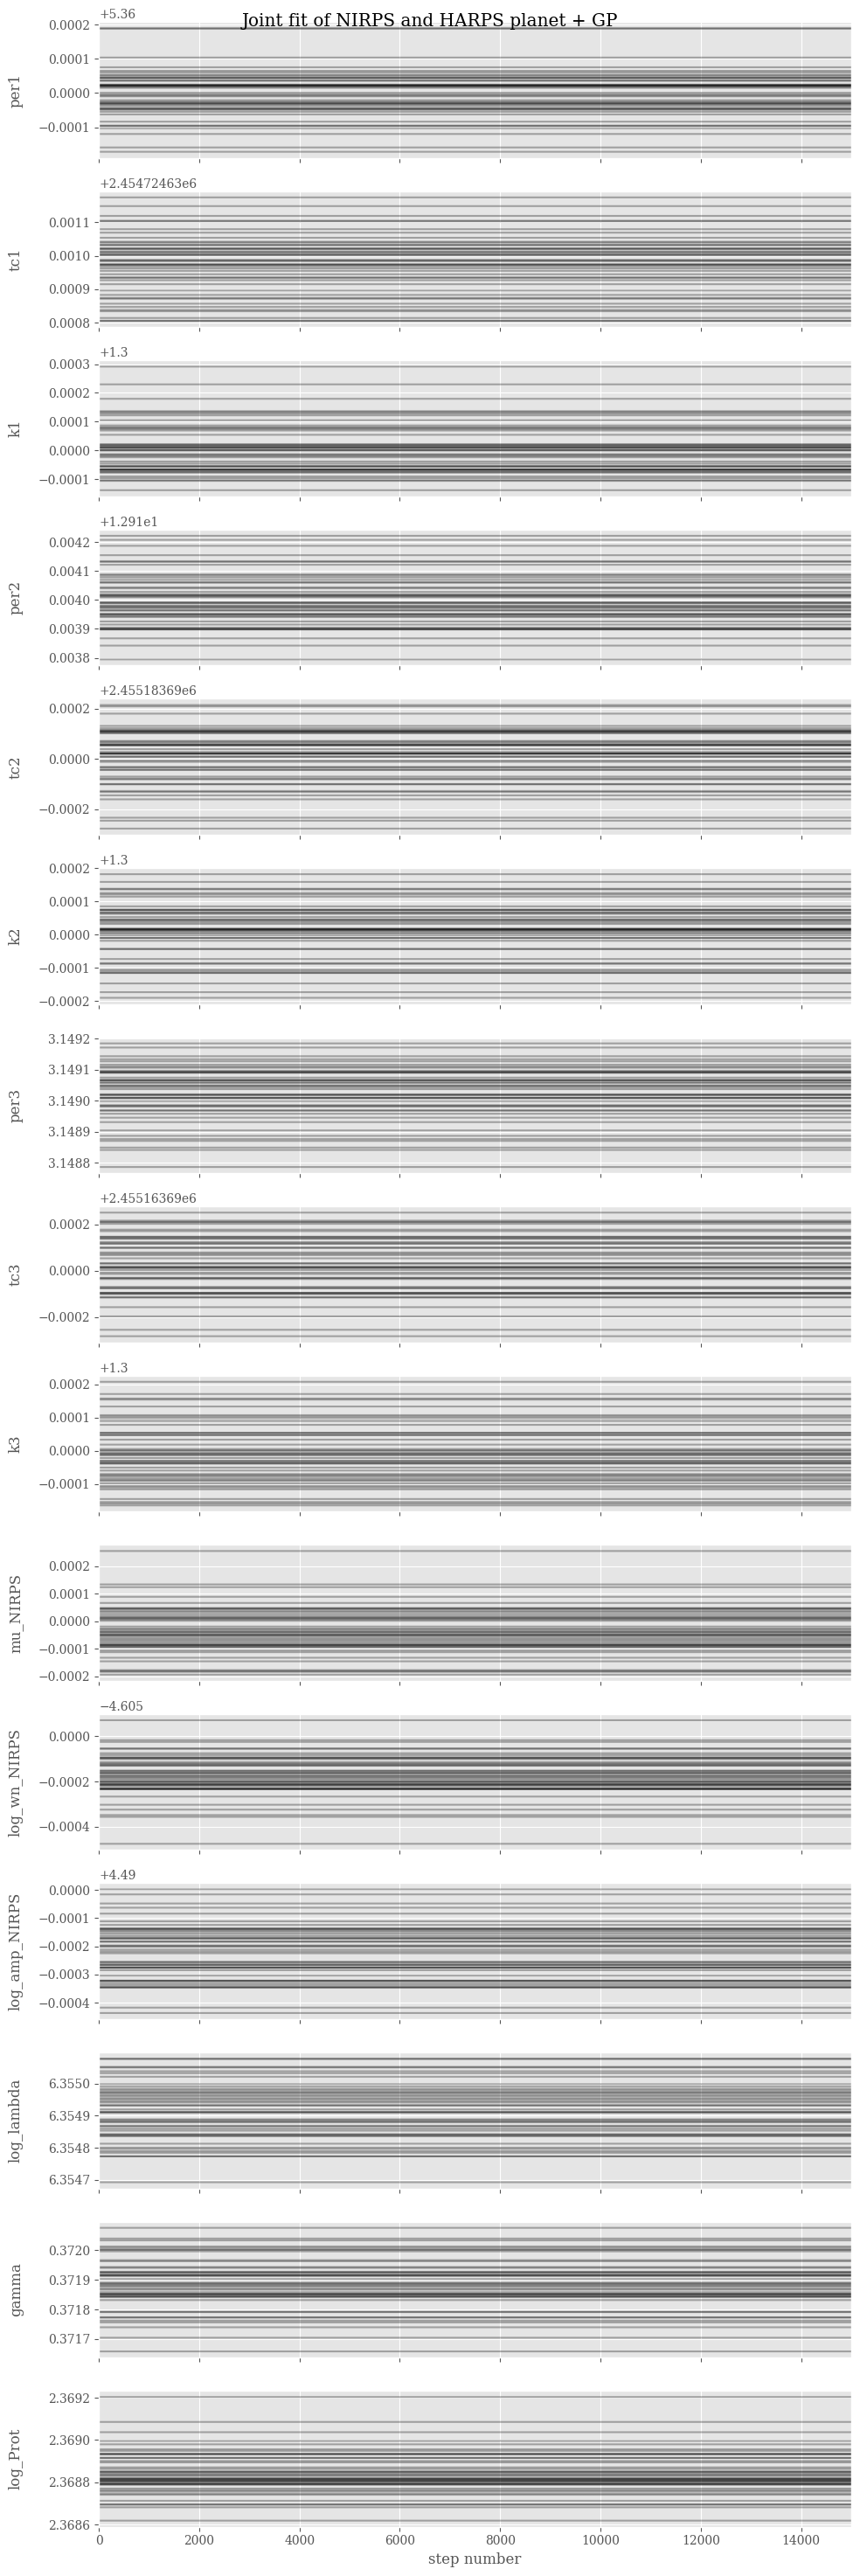

In [ ]:
print('Plotting traceplot...')

fig, axes = plt.subplots(ndim, figsize=(10, ndim*2), sharex=True)

# Save the posterior samples
np.save(f'stars/{star}/joint_fit/full_post_samples.npy', post_samples)

for i in range(ndim):
    ax = axes[i]
    ax.plot(post_samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(post_samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.set_ylabel(param_labels[i])
axes[-1].set_xlabel("step number")
plt.suptitle('Joint fit of NIRPS and HARPS planet + GP')
plt.savefig(f"stars/{star}/joint_fit/planet+GP_traceplot.png")

print('Done.')

In [ ]:
med_params = np.median(post_samples, axis=(0,1))

print('Median likelihood parameters')
print('--------------------------')
# Show the median likelihood parameters
for i, label in enumerate(param_labels):
    print(f'{label}: {med_params[i]:.3f}')


Median likelihood parameters
--------------------------
per1: 5.360
tc1: 2454724.631
k1: 1.300
per2: 12.914
tc2: 2455183.690
k2: 1.300
per3: 3.149
tc3: 2455163.690
k3: 1.300
mu_NIRPS: -0.000
log_wn_NIRPS: -4.605
log_amp_NIRPS: 4.490
log_lambda: 6.355
gamma: 0.372
log_Prot: 2.369


In [ ]:
print('Plotting corner plot...')

# Make a corner plot
fig = corner.corner(
    post_samples.reshape(-1, ndim),
    labels=param_labels,
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    color="blue",  # Set a color scheme (optional)
    hist_kwargs={"linewidth": 1.5, "alpha": 0.7},  # Adjust histogram appearance
    fill_contours=True,  # Show contours for data density
    fill_kw={"cmap": "Blues"},  # Set colormap for contours (optional)
    smooth=True,  # Improve smoothness of contours
    fontsize=10,  # Set font size for labels and tick marks
    truth_color = 'orange',
)

plt.tight_layout()
plt.savefig(f"stars/{star}/joint_fit/planet+GP_cornerplot.png")

print('Done.')

Plotting corner plot...


KeyboardInterrupt: 

In [ ]:
# Visualize posterior samples and max/median likelihood models
print('Creating posterior samples...')

num_display = 50
maxiter = 100
niter = 0

# Initialize dictionaries to store posterior samples for each instrument
model_post_samples = {instrument: [] for instrument in data.instruments}

while niter < maxiter and all(len(samples) < num_display for samples in model_post_samples.values()):
    w = np.random.randint(nwalkers)
    n = np.random.randint(num_post_samples)

    # Separate the parameters for each instrument
    planet_sample = post_samples[n, w, :3*num_planets]
    gp_samples, gp_samples_dict = rv.separate_gp_params(post_samples[n, w, 3*num_planets:], i_shared, data.instruments)
    try:
        params = np.concatenate([planet_sample, gp_samples])
        model.update_params(params)
        
        for instrument in data.instruments:
            model_post_samples[instrument].append(model.predict(data.t_mod)[instrument])
            
    except LinAlgError:
        print("LinAlgError")
        print(f"iteration {niter}")
        print("GP hyperparameters:")
        for instrument, gp_model in act_gp.items():
            pprint.pprint(gp_model.gp.get_parameter_dict())
    
    niter += 1

# Convert lists to numpy arrays
model_post_samples = {instrument: np.array(samples) for instrument, samples in model_post_samples.items()}

print('Done')

Creating posterior samples...


Done


Plot the final the planets + GP model

In [ ]:
# Separate the parameters for each instrument
med_gp_params, med_gp_params_dict = rv.separate_gp_params(med_params[3*num_planets:], i_shared, data.instruments)
separated_med_params = np.concatenate([med_params[:data.nplanets*3], med_gp_params])

# Update the model with the median likelihood parameters
model.update_params(separated_med_params)

# Fetch the noise term of each instrument
noise_terms = {instrument: np.sqrt(data.yerr_rv[instrument]**2 + np.exp(med_gp_params_dict[instrument][1])) for instrument in data.instruments}

Plotting the best-fit model and residuals


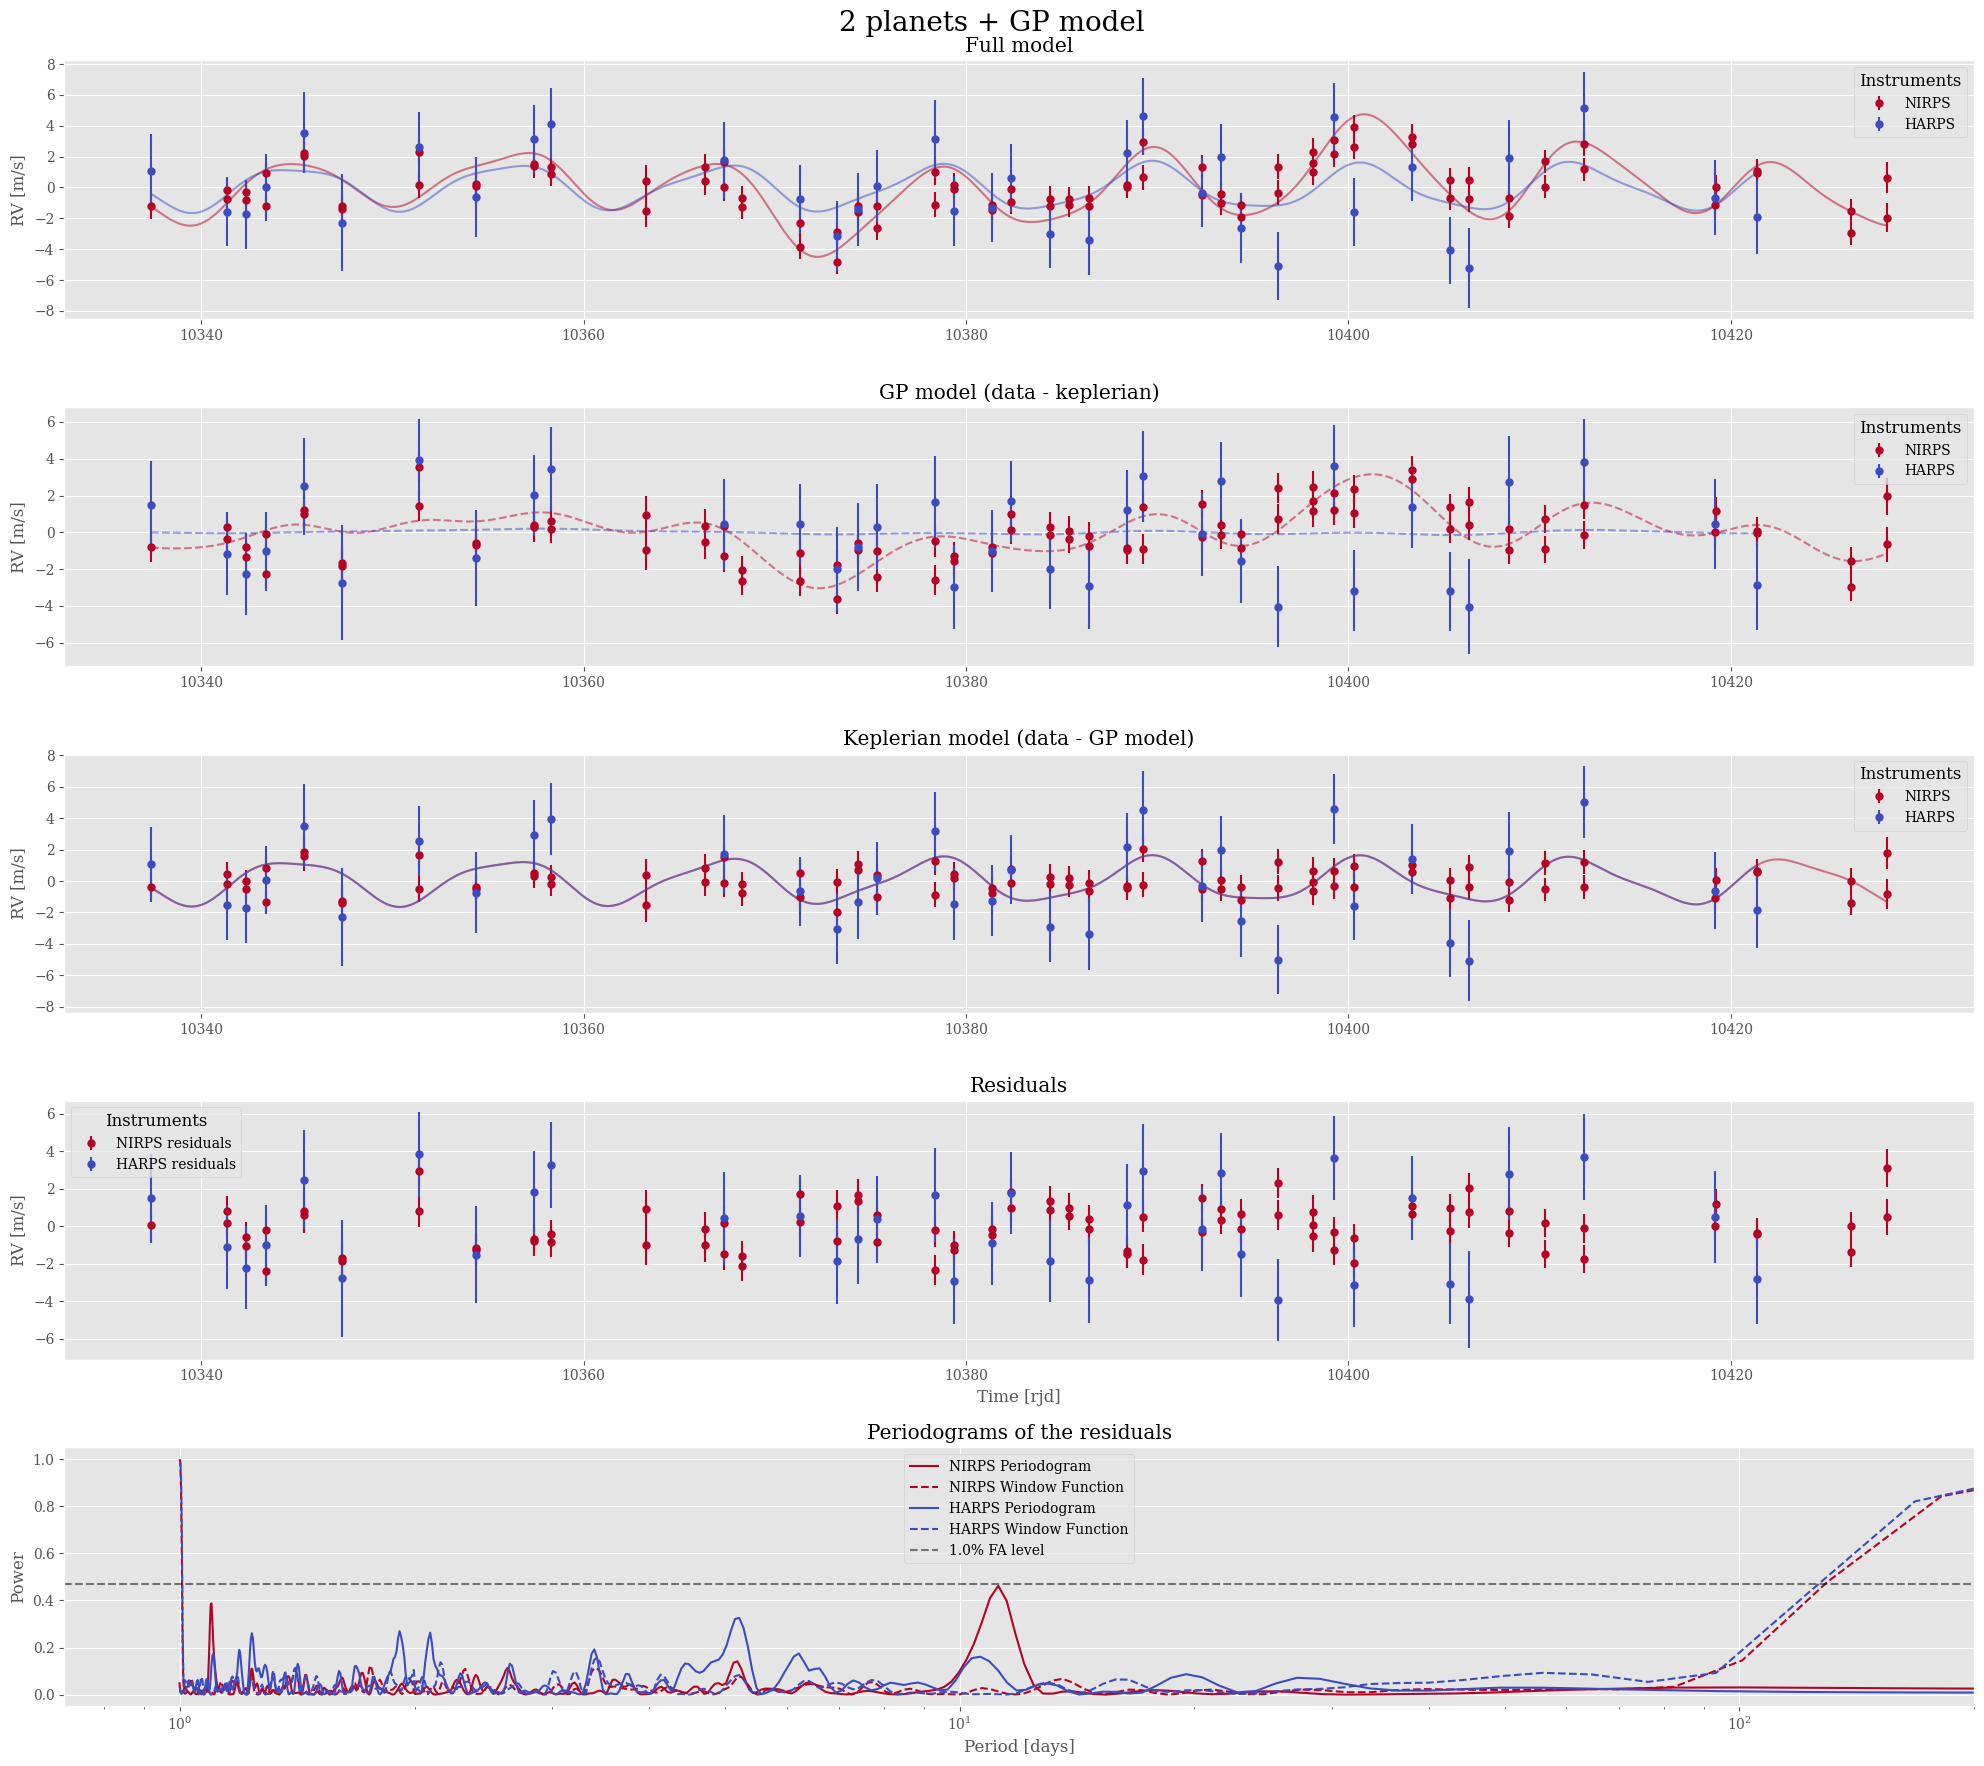

Done.


In [ ]:
print('Plotting the best-fit model and residuals')

# Plot the planets + GP model and the samples
fig, axes = plt.subplots(5, 1, figsize=(20, 18), sharex=False)
colors = cm.coolwarm(np.linspace(1, 0, len(data.instruments)))
rjd_off = 2450000
for idx, instrument in enumerate(data.instruments):
    # Plot data with error bars
    axes[0].errorbar(data.t_rv[instrument] - rjd_off, data.y_rv[instrument] - med_params[3*num_planets+idx], yerr=noise_terms[instrument], fmt="o", ms=5, label=f'{instrument}', color=colors[idx])
    axes[1].errorbar(data.t_rv[instrument] - rjd_off, data.y_rv[instrument] - model.predict(data.t_rv, return_components=True)[instrument]['planet'] - med_params[3*num_planets+idx], yerr=noise_terms[instrument], fmt="o", ms=5, label=f'{instrument}', color=colors[idx])
    axes[2].errorbar(data.t_rv[instrument] - rjd_off, data.y_rv[instrument] - model.predict(data.t_rv, return_components=True)[instrument]['GP'], yerr=noise_terms[instrument], fmt="o", ms=5, label=f'{instrument}', color=colors[idx])
    
    # Plot median likelihood
    axes[2].plot(data.t_mod[instrument] - rjd_off, model.predict(data.t_mod, return_components=True)[instrument]['planet'], color=colors[idx], linewidth=1.5, alpha=0.5)  # Keplerian
    axes[1].plot(data.t_mod[instrument] - rjd_off, model.predict(data.t_mod, return_components=True)[instrument]['GP'] - med_params[3*num_planets+idx], color=colors[idx], linestyle='--', linewidth=1.5, alpha=0.5)  # GP
    axes[0].plot(data.t_mod[instrument] - rjd_off, model.predict(data.t_mod, return_components=True)[instrument]['planet'] + model.predict(data.t_mod, return_components=True)[instrument]['GP'] - med_params[3*num_planets+idx], color=colors[idx], linewidth=1.5, alpha=0.5)  # Full model
    
    # Plot residuals
    axes[3].errorbar(data.t_rv[instrument] - rjd_off, data.y_rv[instrument] - model.predict(data.t_rv)[instrument], yerr=noise_terms[instrument], fmt='o', color=colors[idx], label=f'{instrument} residuals')
    
    # Plot the periodogram of the residuals
    ls = LombScargle(data.t_rv[instrument] - rjd_off, data.y_rv[instrument] - model.predict(data.t_rv)[instrument], dy=noise_terms[instrument])
    target_fap = 0.01
    fap = ls.false_alarm_level(target_fap)
    freq, power = ls.autopower(maximum_frequency=1.0)
    period = 1 / freq

    ls_window = LombScargle(data.t_rv[instrument] - rjd_off, np.ones_like(data.y_rv[instrument]), dy=noise_terms[instrument], fit_mean=False, center_data=False)
    power_window = ls_window.power(freq)

    axes[4].plot(period, power, color=colors[idx], label=f'{instrument} Periodogram')
    axes[4].plot(period, power_window, color=colors[idx], linestyle='--', label=f'{instrument} Window Function')

axes[4].axhline(fap, linestyle="--", color="black", label=f"{target_fap * 100}% FA level", alpha=0.5)

axes[0].set_title('Full model')
axes[1].set_title('GP model (data - keplerian)')
axes[2].set_title('Keplerian model (data - GP model)')
axes[3].set_title('Residuals')
axes[4].set_title('Periodograms of the residuals')
axes[3].set_xlabel('Time [rjd]')
axes[0].set_ylabel('RV [m/s]')
axes[1].set_ylabel('RV [m/s]')
axes[2].set_ylabel('RV [m/s]')
axes[3].set_ylabel('RV [m/s]')
axes[0].legend(title='Instruments')
axes[1].legend(title='Instruments')
axes[2].legend(title='Instruments')
axes[3].legend(title='Instruments')
axes[4].set_xlabel('Period [days]')
axes[4].set_ylabel('Power')
axes[4].legend()
axes[4].set_xscale('log')
axes[4].set_xlim(0, 200)
plt.suptitle(f'{num_planets} planets + GP model', fontsize=20)
plt.savefig(f'stars/{star}/joint_fit/planets+GP_best_fit.png')
plt.show()

print('Done.')

Plotting the random samples 

Plotting model samples
Done.


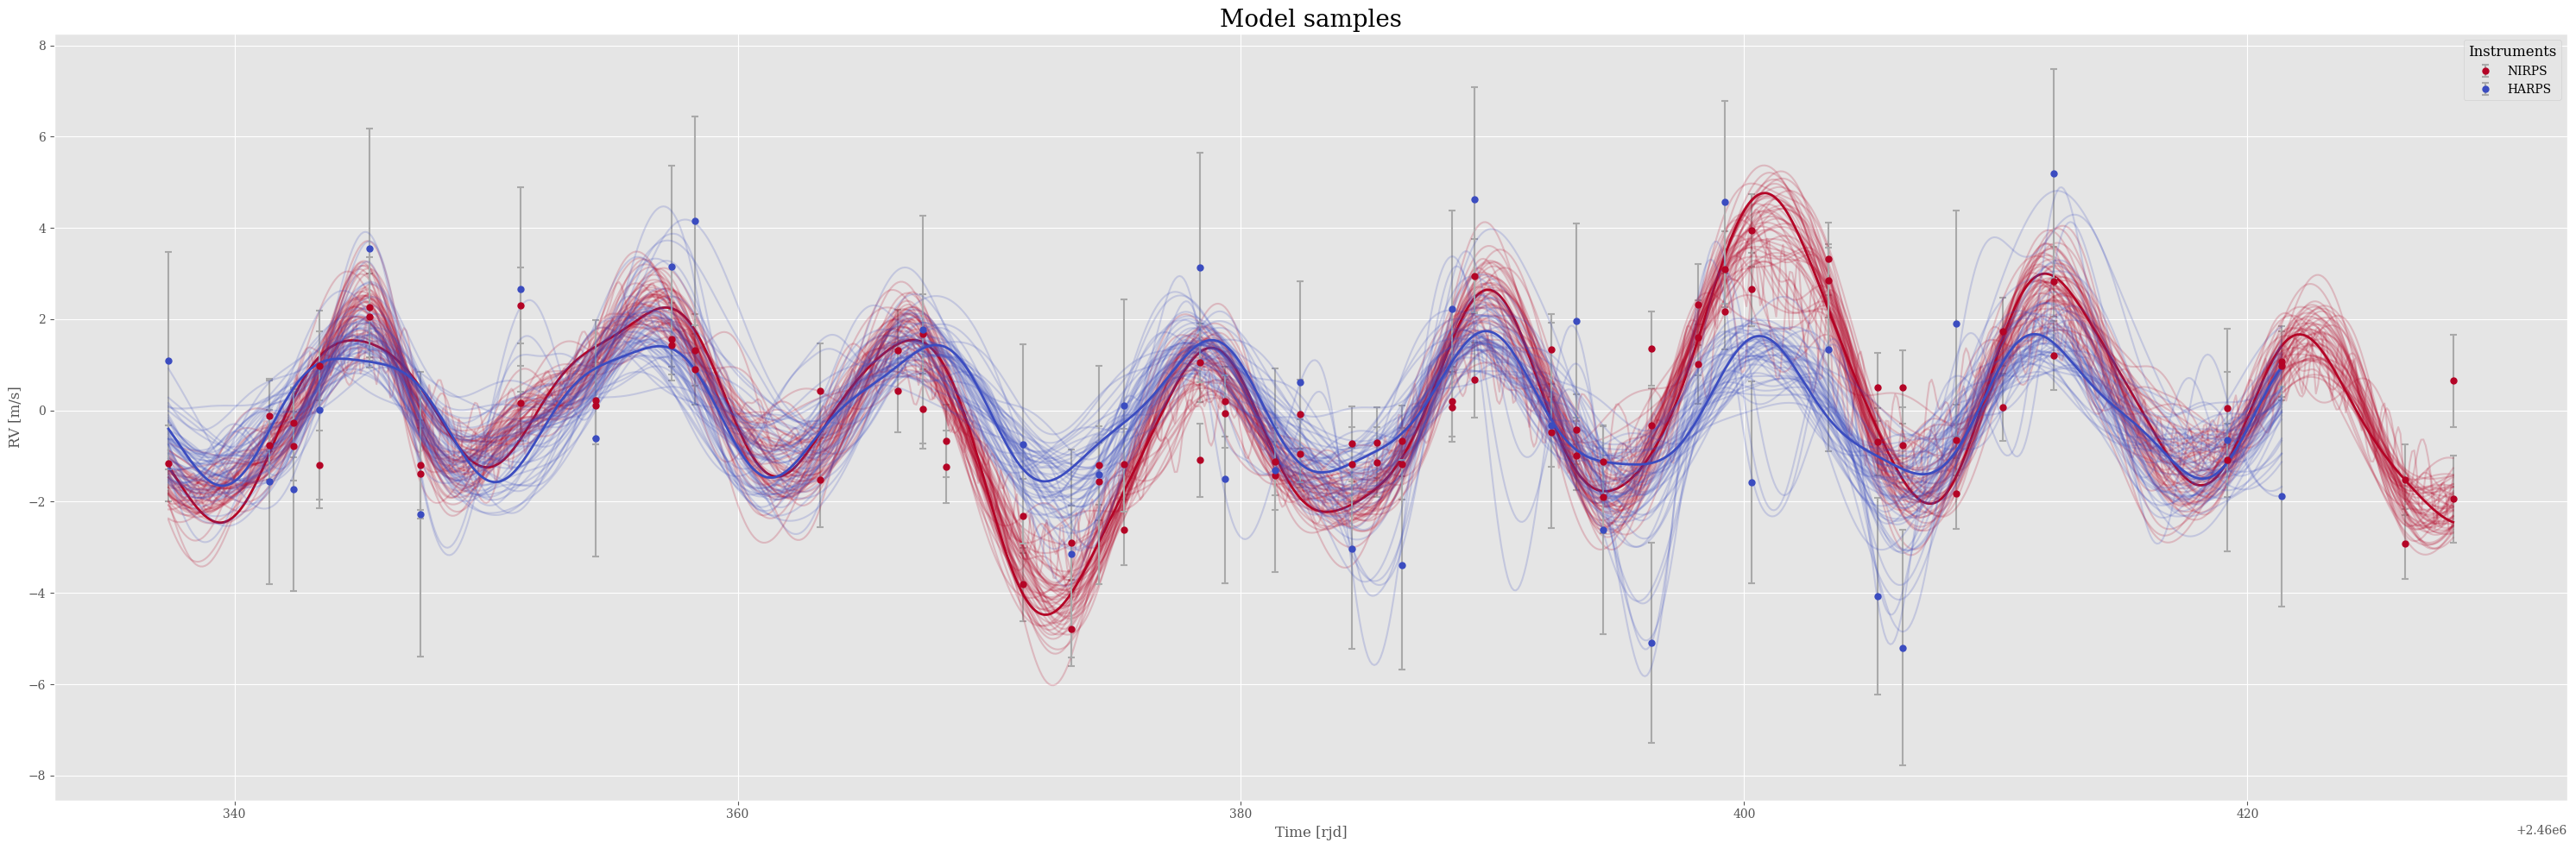

In [ ]:
print('Plotting model samples')

fig, ax = plt.subplots(1, 1, figsize=(30, 10))

for idx, instrument in enumerate(data.instruments):
    # Subtler error bars
    ax.errorbar(data.t_rv[instrument], data.y_rv[instrument], yerr=noise_terms[instrument], fmt='o', 
                label=instrument, color=colors[idx], 
                ecolor='darkgray', elinewidth=1.5, capsize=3, capthick=1.5)
    ax.plot(data.t_mod[instrument], model_post_samples[instrument].T, alpha = 0.2, color = colors[idx])
    ax.plot(data.t_mod[instrument], model.predict(data.t_mod)[instrument], color=colors[idx], lw=2)
    
ax.set_xlabel('Time [rjd]')
ax.set_ylabel('RV [m/s]')
ax.legend(title='Instruments')
ax.set_title('Model samples', fontsize = 20)

plt.savefig(f'stars/{star}/joint_fit/planet_model_samples.png')
print('Done.')

Plotting phase-folded RV curves of our planets...


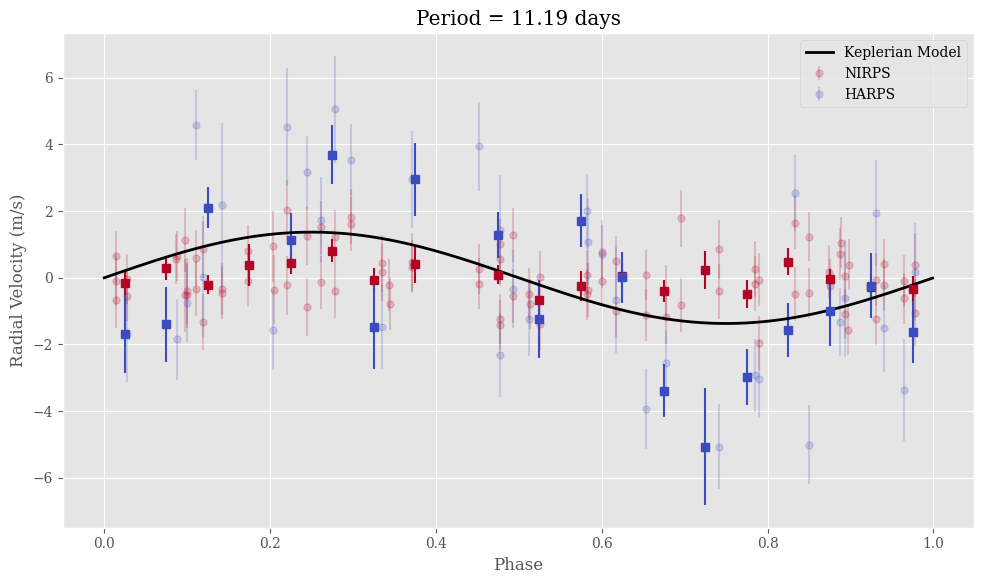

<Figure size 640x480 with 0 Axes>

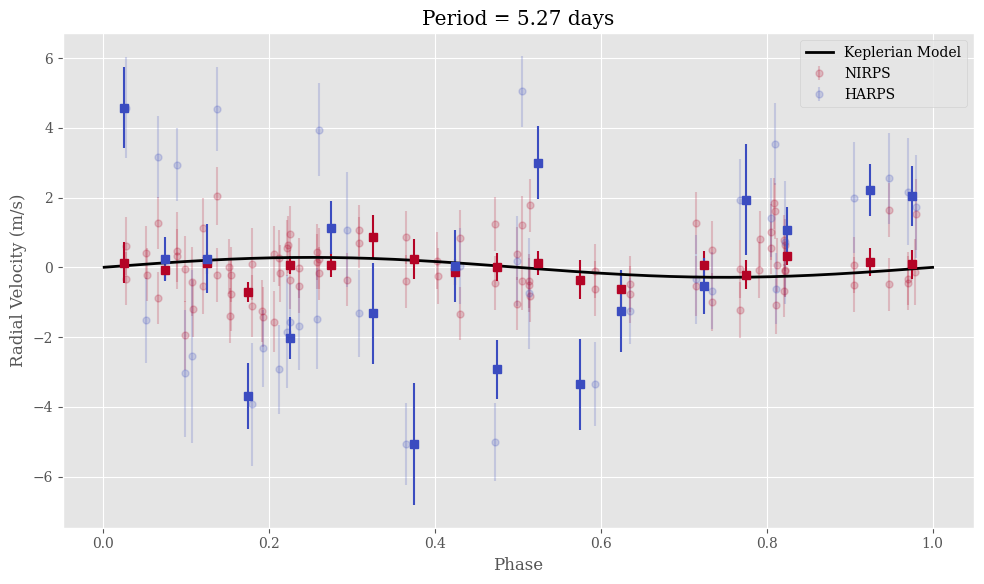

Done.


<Figure size 640x480 with 0 Axes>

In [ ]:
print('Plotting phase-folded RV curves of our planets...')

def foldAt(time, period, t0):
    return ((time - t0 + 0.5 * period) % period) / period

def bin_data(phases, RVs, RV_errs, num_bins=20):
    bins = np.linspace(0, 1, num_bins + 1)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    binned_RVs = np.zeros(num_bins)
    binned_errs = np.zeros(num_bins)
    
    for i in range(num_bins):
        in_bin = (phases >= bins[i]) & (phases < bins[i+1])
        if np.any(in_bin):
            weights = 1 / RV_errs[in_bin]**2
            binned_RVs[i] = np.sum(RVs[in_bin] * weights) / np.sum(weights)
            binned_errs[i] = np.sqrt(1 / np.sum(weights))
        else:
            binned_RVs[i] = np.nan
            binned_errs[i] = np.nan
    
    return bin_centers, binned_RVs, binned_errs

def phase_folded_plot(data_times, model_times, RVs, RV_errs, keplerian_model_RVs, period, t0, instrument_names):
    colors = plt.cm.coolwarm(np.linspace(1, 0, len(data_times)))
    
    # Plotting the data
    plt.figure(figsize=(10, 6))
    
    for i, instrument in enumerate(instrument_names):
        # Fold the data and model times to get the phases
        phases_data = foldAt(data_times[instrument], period, t0)
        phases_model = foldAt(model_times[instrument], period, t0)

        # Sort the phases for plotting
        sort_indices_data = np.argsort(phases_data)
        sort_indices_model = np.argsort(phases_model)

        phases_data_sorted = phases_data[sort_indices_data]
        RV_sorted = RVs[instrument][sort_indices_data]
        
        phases_model_sorted = phases_model[sort_indices_model]
        keplerian_model_RVs_sorted = keplerian_model_RVs[instrument][sort_indices_model]

        # Plot the observed data
        plt.errorbar(phases_data_sorted, RV_sorted, yerr=RV_errs[instrument], fmt='o', color=colors[i], label=f'{instrument}', zorder=1, alpha = 0.2)
        
        # Bin the data and plot the binned points
        bin_centers, binned_RVs, binned_errs = bin_data(phases_data_sorted, RV_sorted, RV_errs[instrument][sort_indices_data])
        plt.errorbar(bin_centers, binned_RVs, yerr=binned_errs, fmt='s', color=colors[i], zorder=2, markersize = 6)
    
    # Plot the model
    plt.plot(phases_model_sorted, keplerian_model_RVs_sorted, color='black', label='Keplerian Model', lw=2)

    # Add labels and title
    plt.xlabel('Phase')
    plt.ylabel('Radial Velocity (m/s)')
    plt.title(f'Period = {period:.2f} days')
    plt.legend()
    plt.grid(True)
    
    # Show the plot
    plt.show()

# Loop through each planet and plot the data
for idx_planet in range(model.num_planets):
    planet_params = radvel.Parameters(1, basis='per tc secosw sesinw k')
    planet_params['per1'].value = med_params[3*idx_planet]
    planet_params['tc1'].value  = med_params[3*idx_planet+1]
    planet_params['k1'].value  = med_params[3*idx_planet+2]
    planet_params['secosw1'].value  = 0.0
    planet_params['sesinw1'].value  = 0.0

    # Create a Keplerian orbit model
    radvel_model = radvel.RVModel(planet_params)

    data_times = {instrument: data.t_rv[instrument] for instrument in data.instruments}
    model_times = {instrument: data.t_mod[instrument] for instrument in data.instruments}
    RVs = {instrument: data.y_rv[instrument] - model.predict(data.t_rv, return_components=True)[instrument]['GP'] for instrument in data.instruments}
    RV_errs = {instrument: data.yerr_rv[instrument] for instrument in data.instruments}
    keplerian_model_RVs = {instrument: radvel_model(data.t_mod[instrument]) for instrument in data.instruments}
    
    phase_folded_plot(data_times, model_times, RVs, RV_errs, keplerian_model_RVs, med_params[3*idx_planet], med_params[3*idx_planet+1], data.instruments)
    
    plt.savefig(f'stars/{star}/joint_fit/phase_folded_planet_{idx_planet+1}.png')

print('Done.')

In [ ]:
print('All done! Hope you will be happy with your results')

All done! Hope you will be happy with your results
